# TODO 
- Dropni gi kaj site modeli Index,ID kolonata.

# Scripts

In [1]:
%run '../shared-code/utils.py'

# Dependencies

In [134]:
import pandas as pd
import tensorflow as tf
import keras
import joblib
import tensorflow.math as tf_math
import numpy as np
import matplotlib.pyplot as plt
from keras.initializers import GlorotUniform
import keras.activations as activations
import keras.layers as layers 
import keras.models as models 
import datetime
import keras.constraints as layer_constraints
import copy 
from sklearn.preprocessing import StandardScaler 


%matplotlib inline 

# Utils

$$RMSLE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(y_{i}+1) - log(\hat{y_{i}}+1))^{2}}$$

In [14]:
def cast_tesnor(tensor: tf.Tensor):
    if tensor.dtype != tf.float32:
        return tf.cast(tensor, dtype=tf.float32)
    return tensor


def tf_rmsle(y_true, y_pred):
    y_true = cast_tesnor(y_true)
    y_pred = cast_tesnor(y_pred)

    return tf.sqrt(
        tf_math.reduce_mean(
            tf_math.pow(tf_math.log(y_true + 1) - tf_math.log(y_pred + 1), 2)
        )
    )


def train_nn(
        nn: keras.Sequential,
        X: pd.DataFrame,
        y: pd.DataFrame,
        epochs: list,
        additional_print_msg:str='', 
        figsize: tuple[int, int] = (50, 20),
        loss_fn=tf_rmsle,
        metric=tf_rmsle,
        callbacks=None, 
        should_print_epoch_losses: bool = False,
        should_print_summary: bool = False,
):
    if should_print_summary:
        print(nn.summary())

    nn.compile(optimizer="adam", loss=loss_fn, metrics=[metric])

    if callbacks is not None: 
        hist = nn.fit(
            x=X, y=y, epochs=epochs, batch_size=32, validation_split=0.25, shuffle=False,verbose=0,callbacks=[callbacks]
        )
    else: 
        hist = nn.fit(
            x=X, y=y, epochs=epochs, batch_size=32, validation_split=0.25, shuffle=False,verbose=0
        )

    if should_print_epoch_losses:
        epochs = list(range(epochs))

        plt.figure(figsize=figsize)
        plt.title("Loss/Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")

        plt.plot(epochs, hist.history['val_loss'], label='Validation')
        plt.plot(epochs, hist.history['loss'], label='Train')

        plt.legend()
        plt.show()

    print('===================')
    
    if len(additional_print_msg)>0:
        print(additional_print_msg) 
    
    print('Last epoch train error {}'.format(hist.history['loss'][-1]))
    print('Last epoch validation error {}'.format(hist.history['val_loss'][-1]))
    print('===================')
    
    return hist.history['loss'][-1],hist.history['val_loss'][-1]

def plot_avrg_grads_layer(nn,X,y,loss_fn=tf_rmsle):
    with tf.GradientTape() as tape:
        output = nn(X)
        y_tf=tf.constant(y)
        loss = loss_fn(output, y_tf)

    grads = tape.gradient(loss, nn.trainable_variables)
    grads_avrg=[]
    for var, g in zip(nn.trainable_variables, grads):
        if not 'bias' in var.name:
            grads_avrg.append(tf.reduce_mean(tf_math.abs(g)))

    layers=[f'layer{i}' for i in range(len(grads_avrg))]

    layers.reverse()
    grads_avrg.reverse()

    plt.figure(figsize=(20,6))
    plt.title("Average gradient per layer")
    plt.xlabel("Layer")
    plt.ylabel("Gradient vals")
    plt.plot(
        layers,
        grads_avrg
    )
    plt.show()

# Load & Process 

In [4]:
pipe_data = joblib.load('../pipelines/data_pipeline.pkl')
df_tr = pd.read_csv('../data/train.csv')
df_tst = pd.read_csv('../data/test.csv')
X_tr, Y_tr = df_tr.drop(TARGET_COL, axis=1), df_tr[TARGET_COL]
X_tst, Y_tst = df_tst.drop(TARGET_COL, axis=1), df_tst[TARGET_COL]

In [5]:
X_tr_proc, X_tst_proc = pipe_data.transform(X_tr), pipe_data.transform(X_tst)

In [6]:
i_from=(1-.25) * X_tr_proc.shape[0]
X_val=X_tr_proc.loc[i_from:]
Y_val=Y_tr.loc[i_from:]

# Ordinary

Vo posledniot layer sekogash ke koristime Relu deka outputot ne smet da ni e nekoja vrednost < 0.

I0000 00:00:1750930805.169576  169076 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750930805.209122  169076 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750930805.211345  169076 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750930805.214682  169076 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

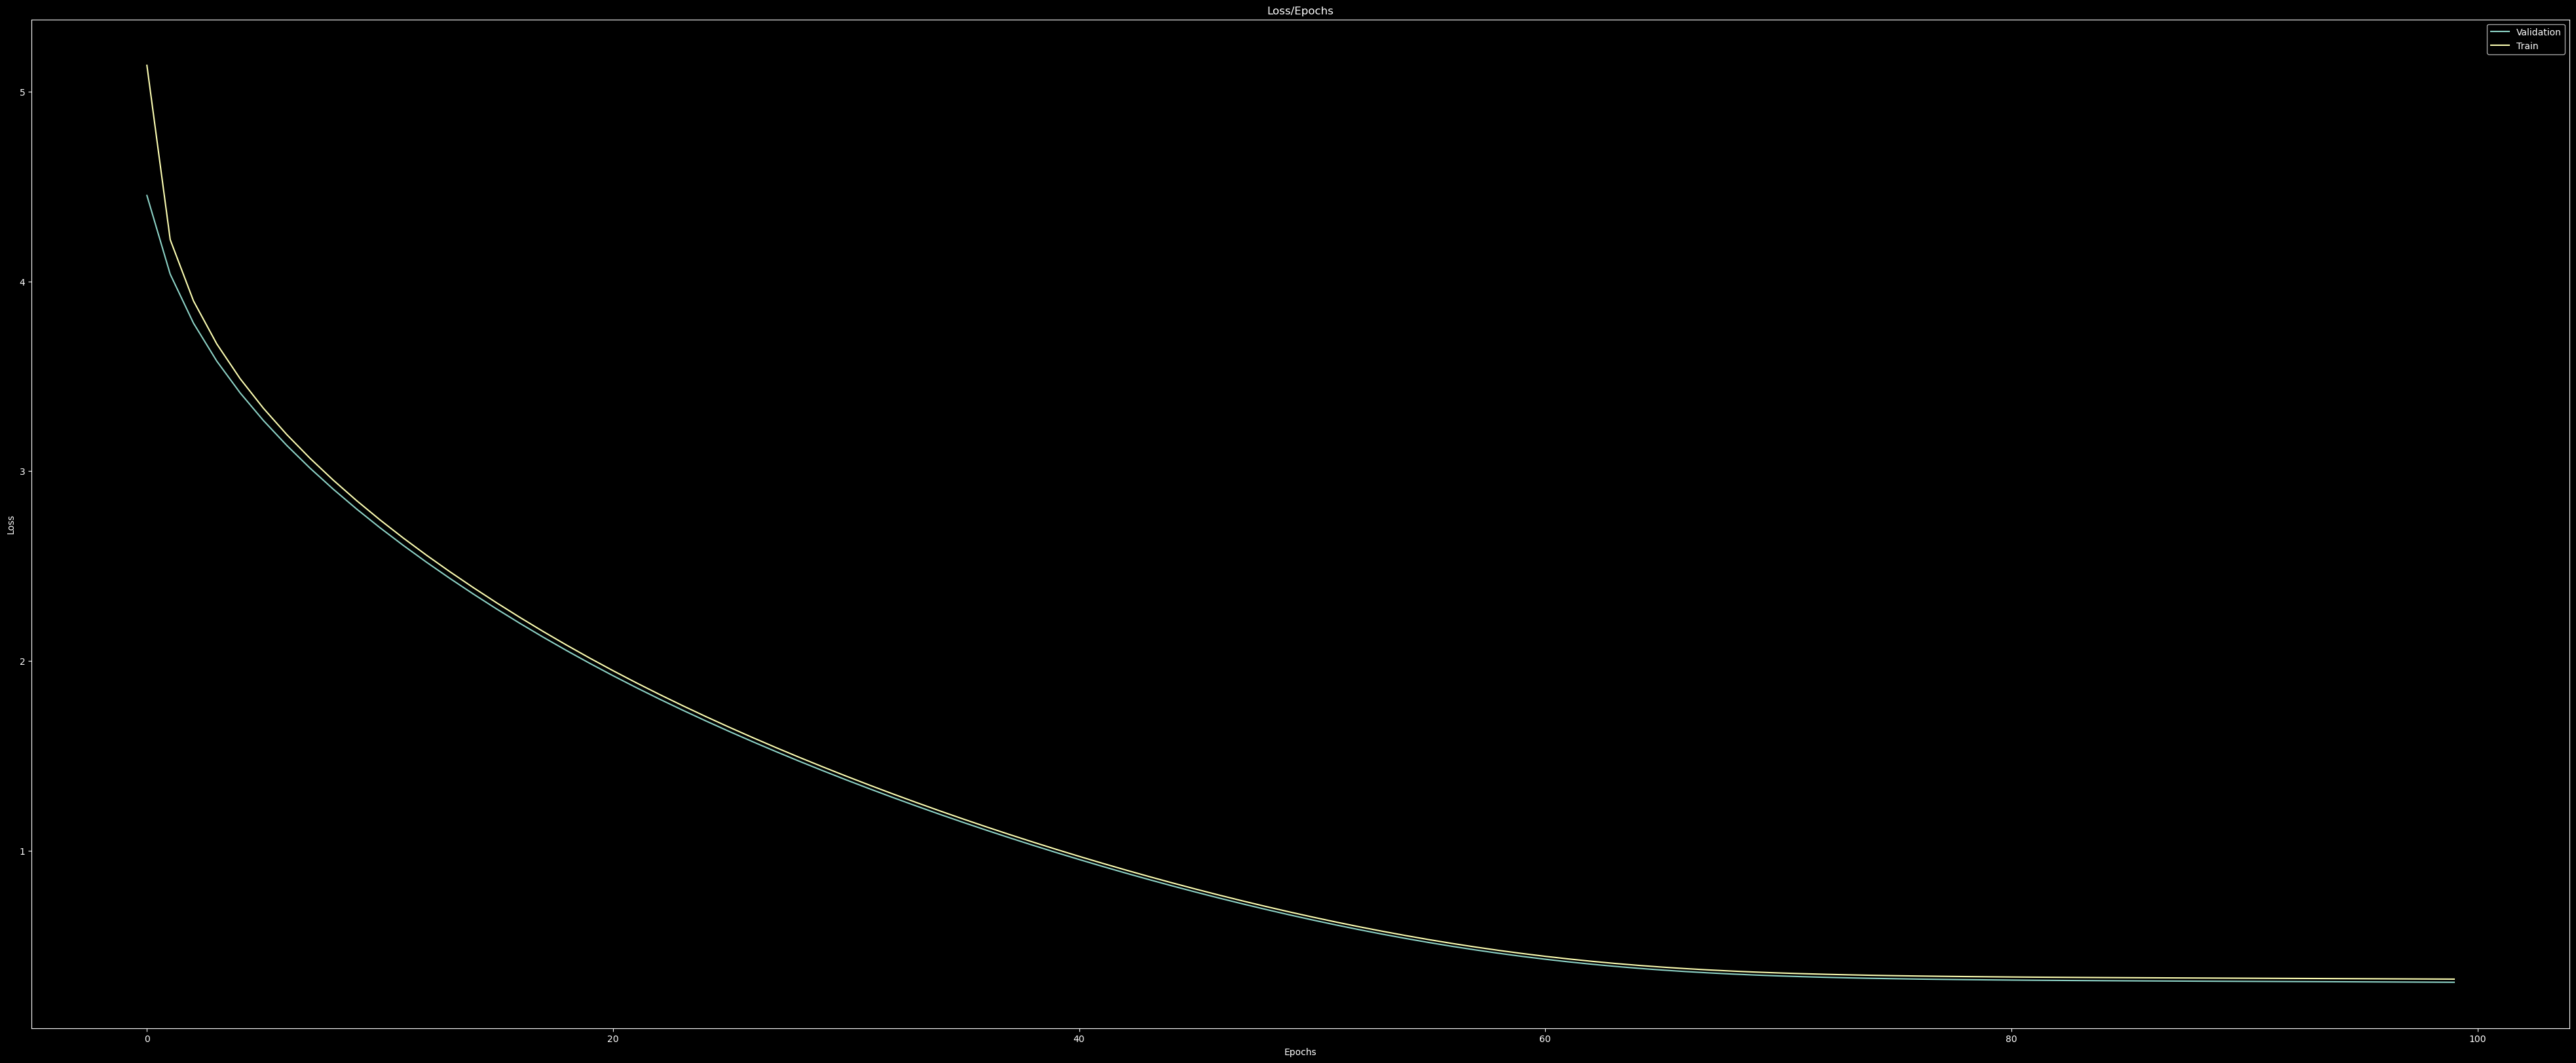

Last epoch train error 0.3219502866268158
Last epoch validation error 0.3053864538669586


(0.3219502866268158, 0.3053864538669586)

In [7]:
nn=models.Sequential([
    layers.Input((X_tr_proc.shape[1],)),
    layers.Dense(30,activation=activations.leaky_relu,kernel_initializer=GlorotUniform(0)),
    layers.Dense(1,activation=activations.relu,kernel_initializer=GlorotUniform(0))
])
train_nn(
    epochs=100,
    nn=nn,
    X=X_tr_proc,
    y=Y_tr,
    should_print_epoch_losses=True
)

Bidejki go izmaksimiziravme preformancot na ovaj model, a ne dobivame dovolno dobri rezultati, ke se obidime so ushte pojke. 

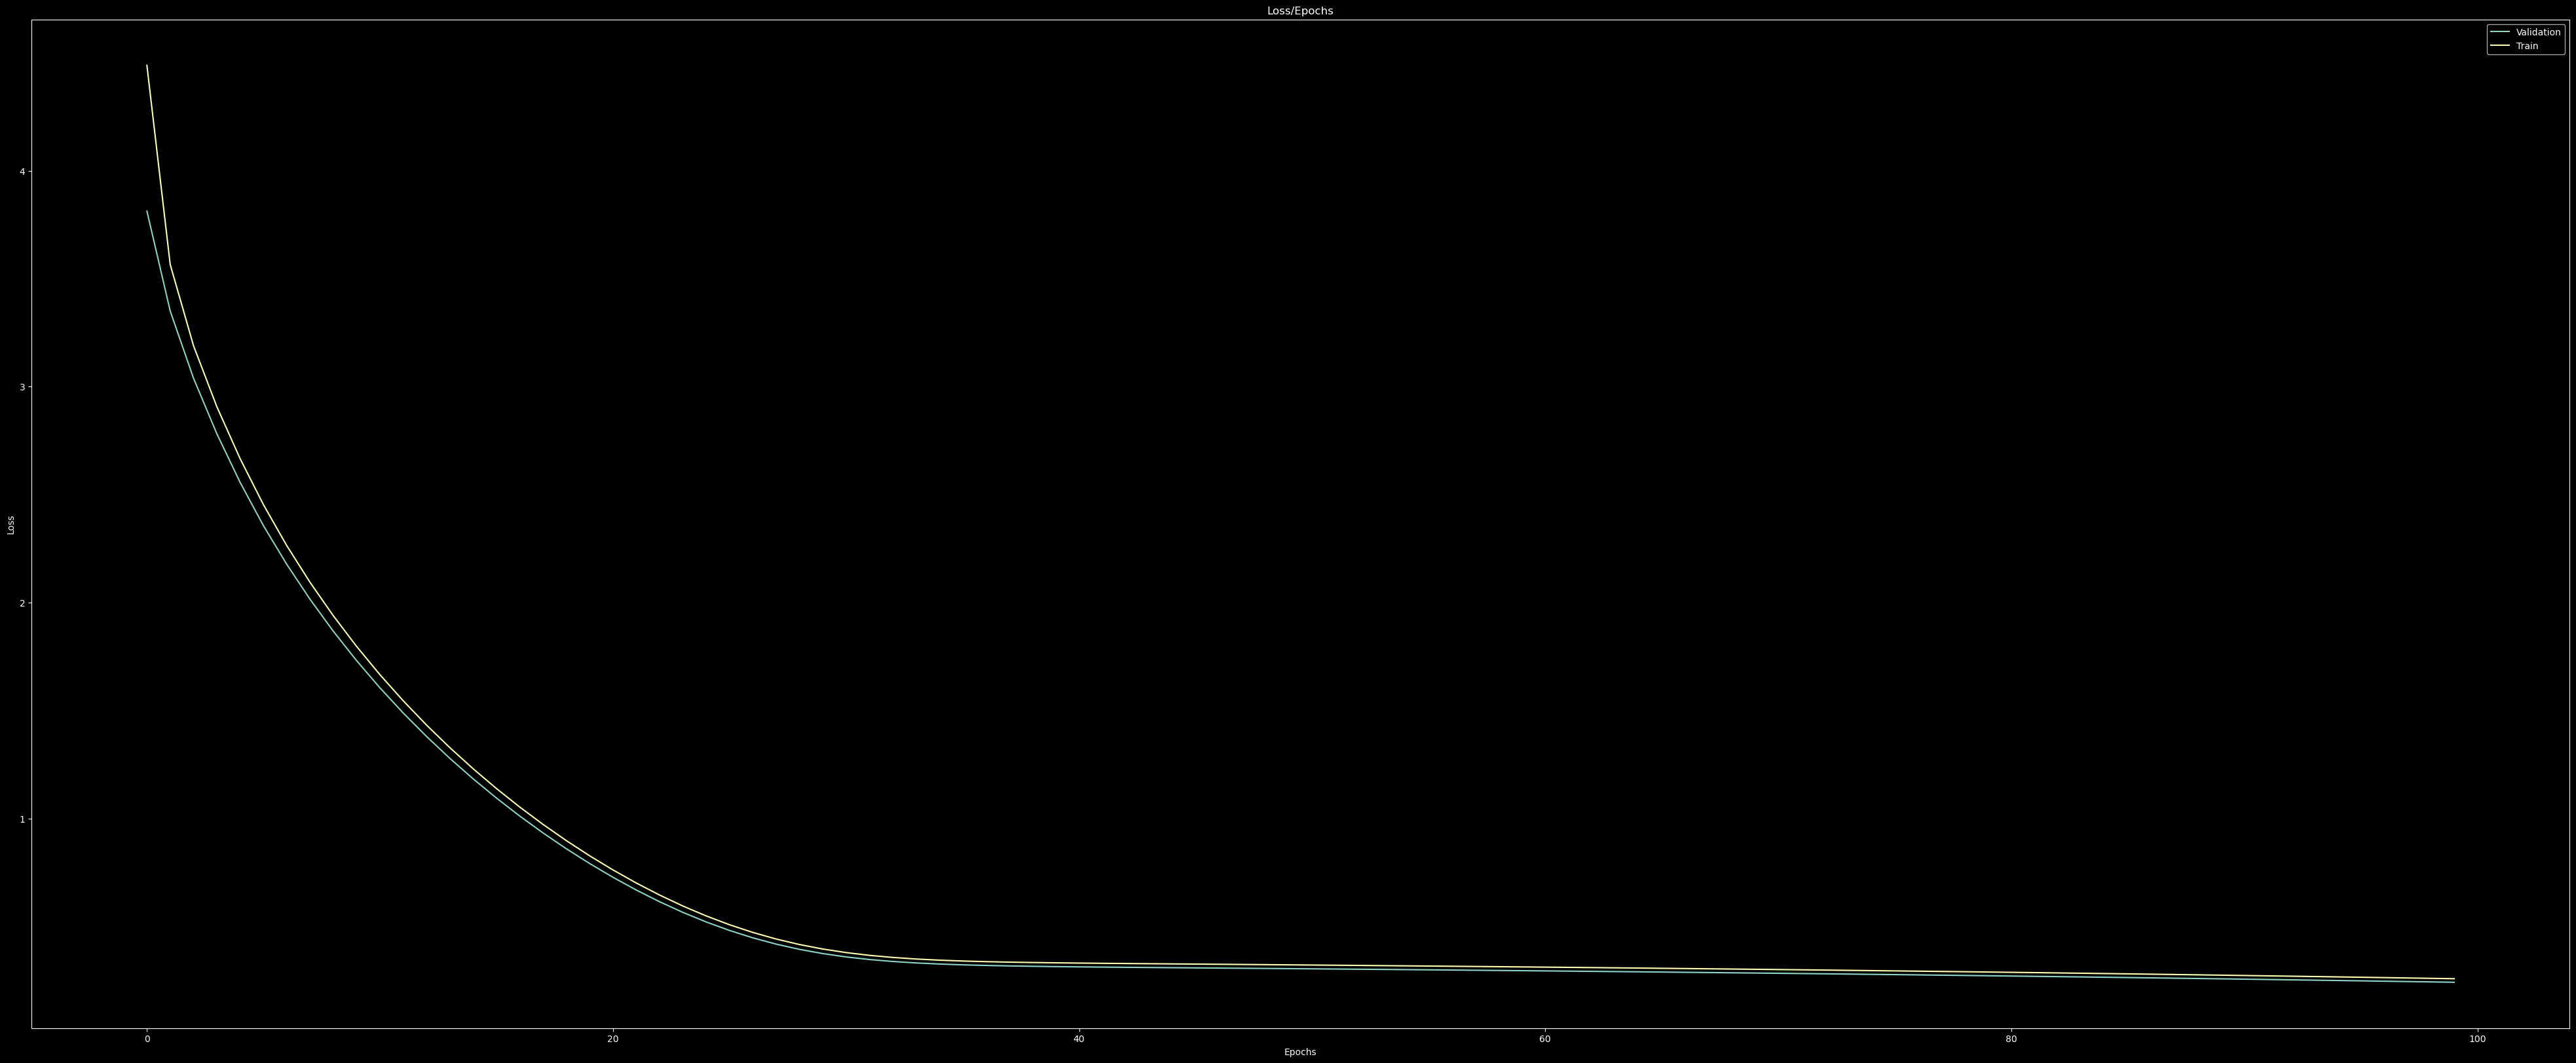

NN with 100.0 neurons
Last epoch train error 0.257815420627594
Last epoch validation error 0.2414168268442154


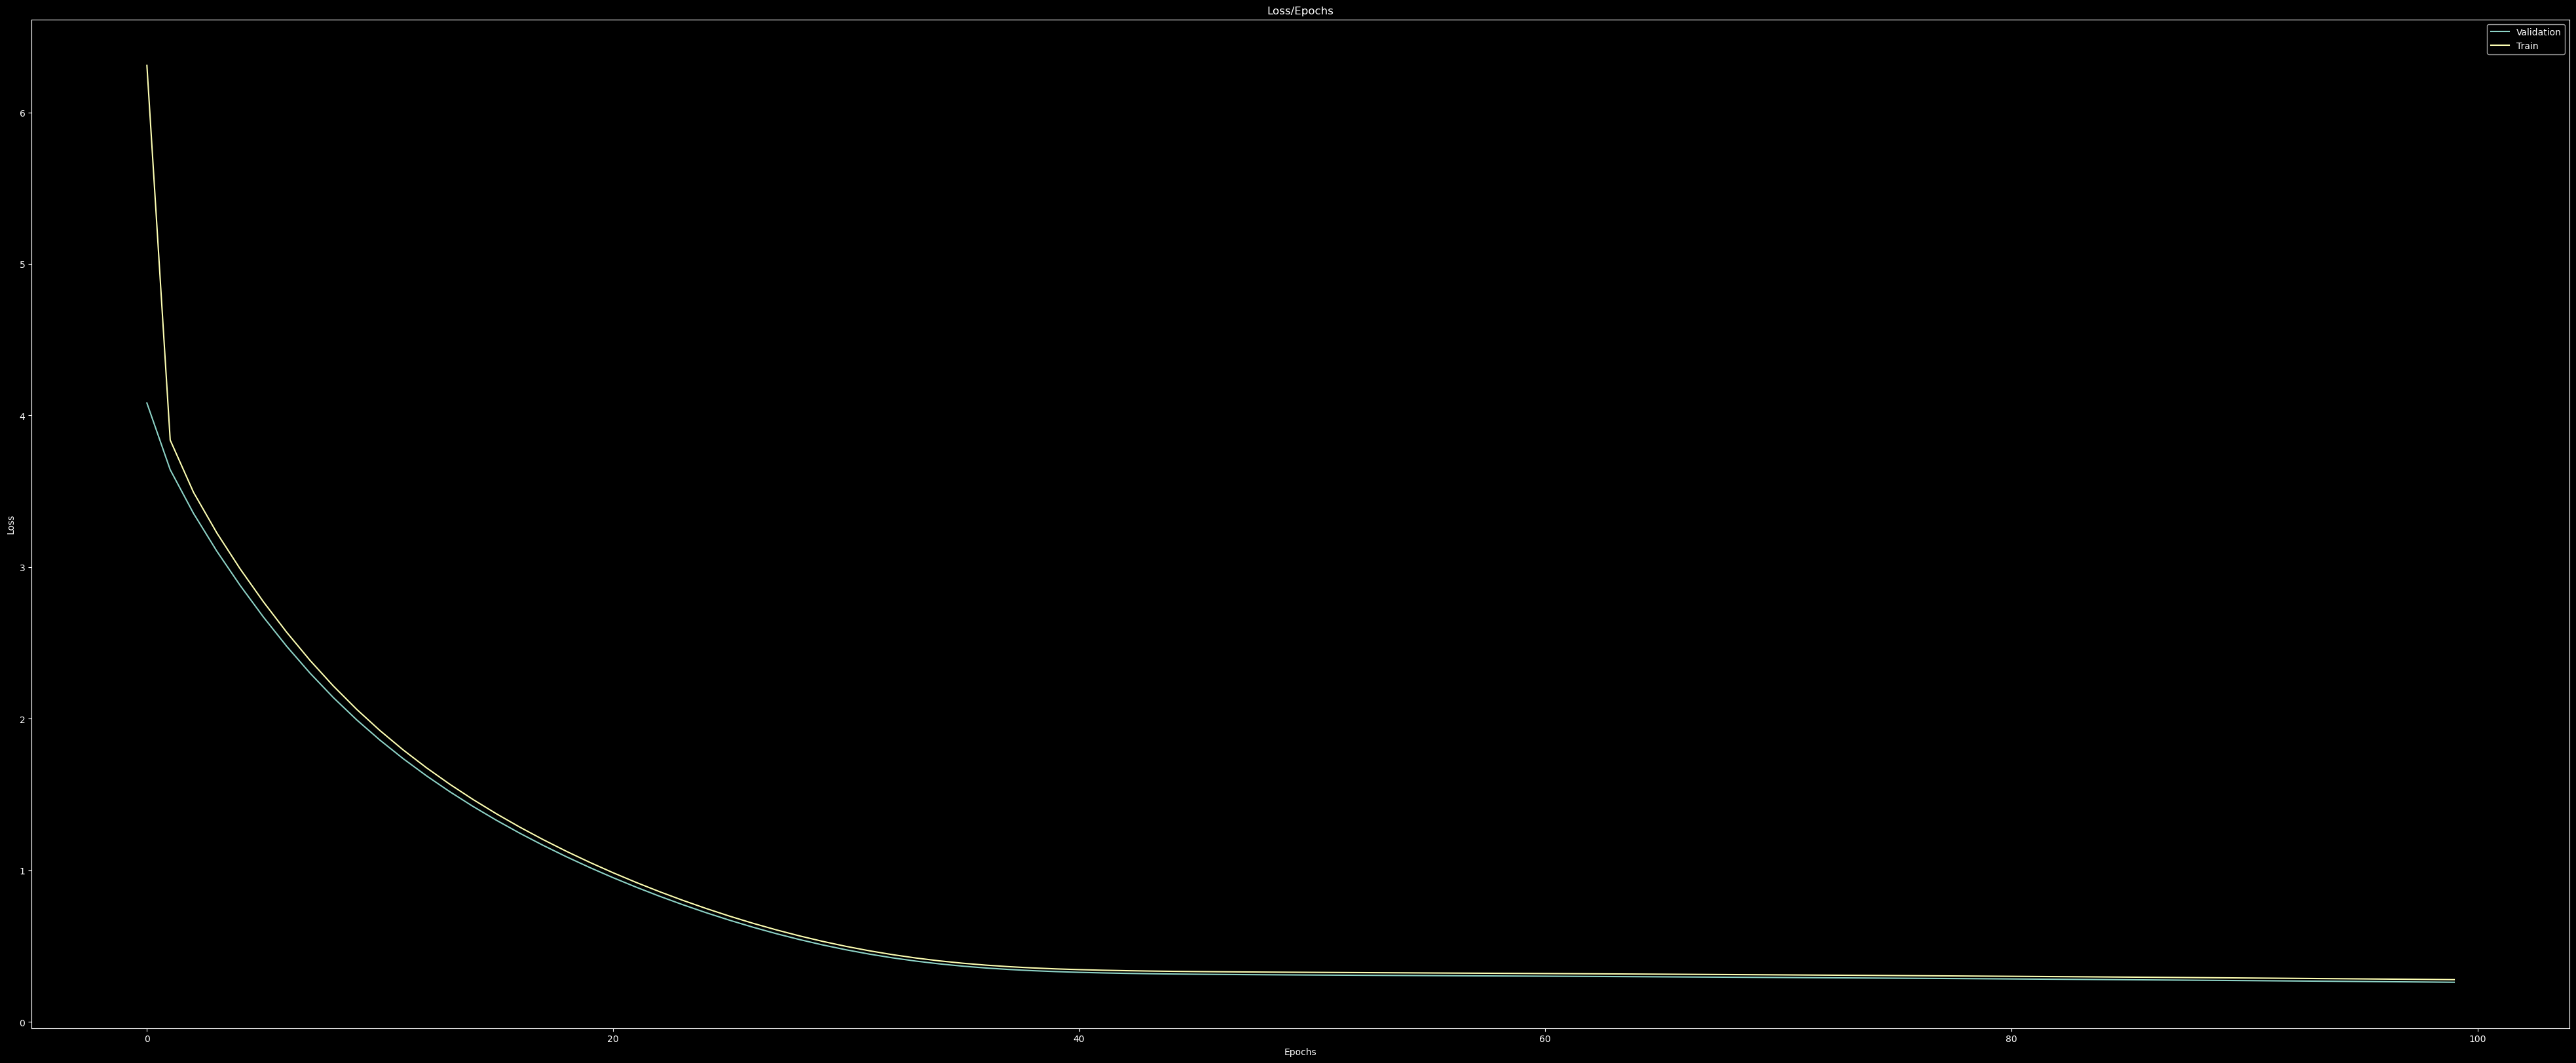

NN with 177.82794100389228 neurons
Last epoch train error 0.2794070243835449
Last epoch validation error 0.26225271821022034


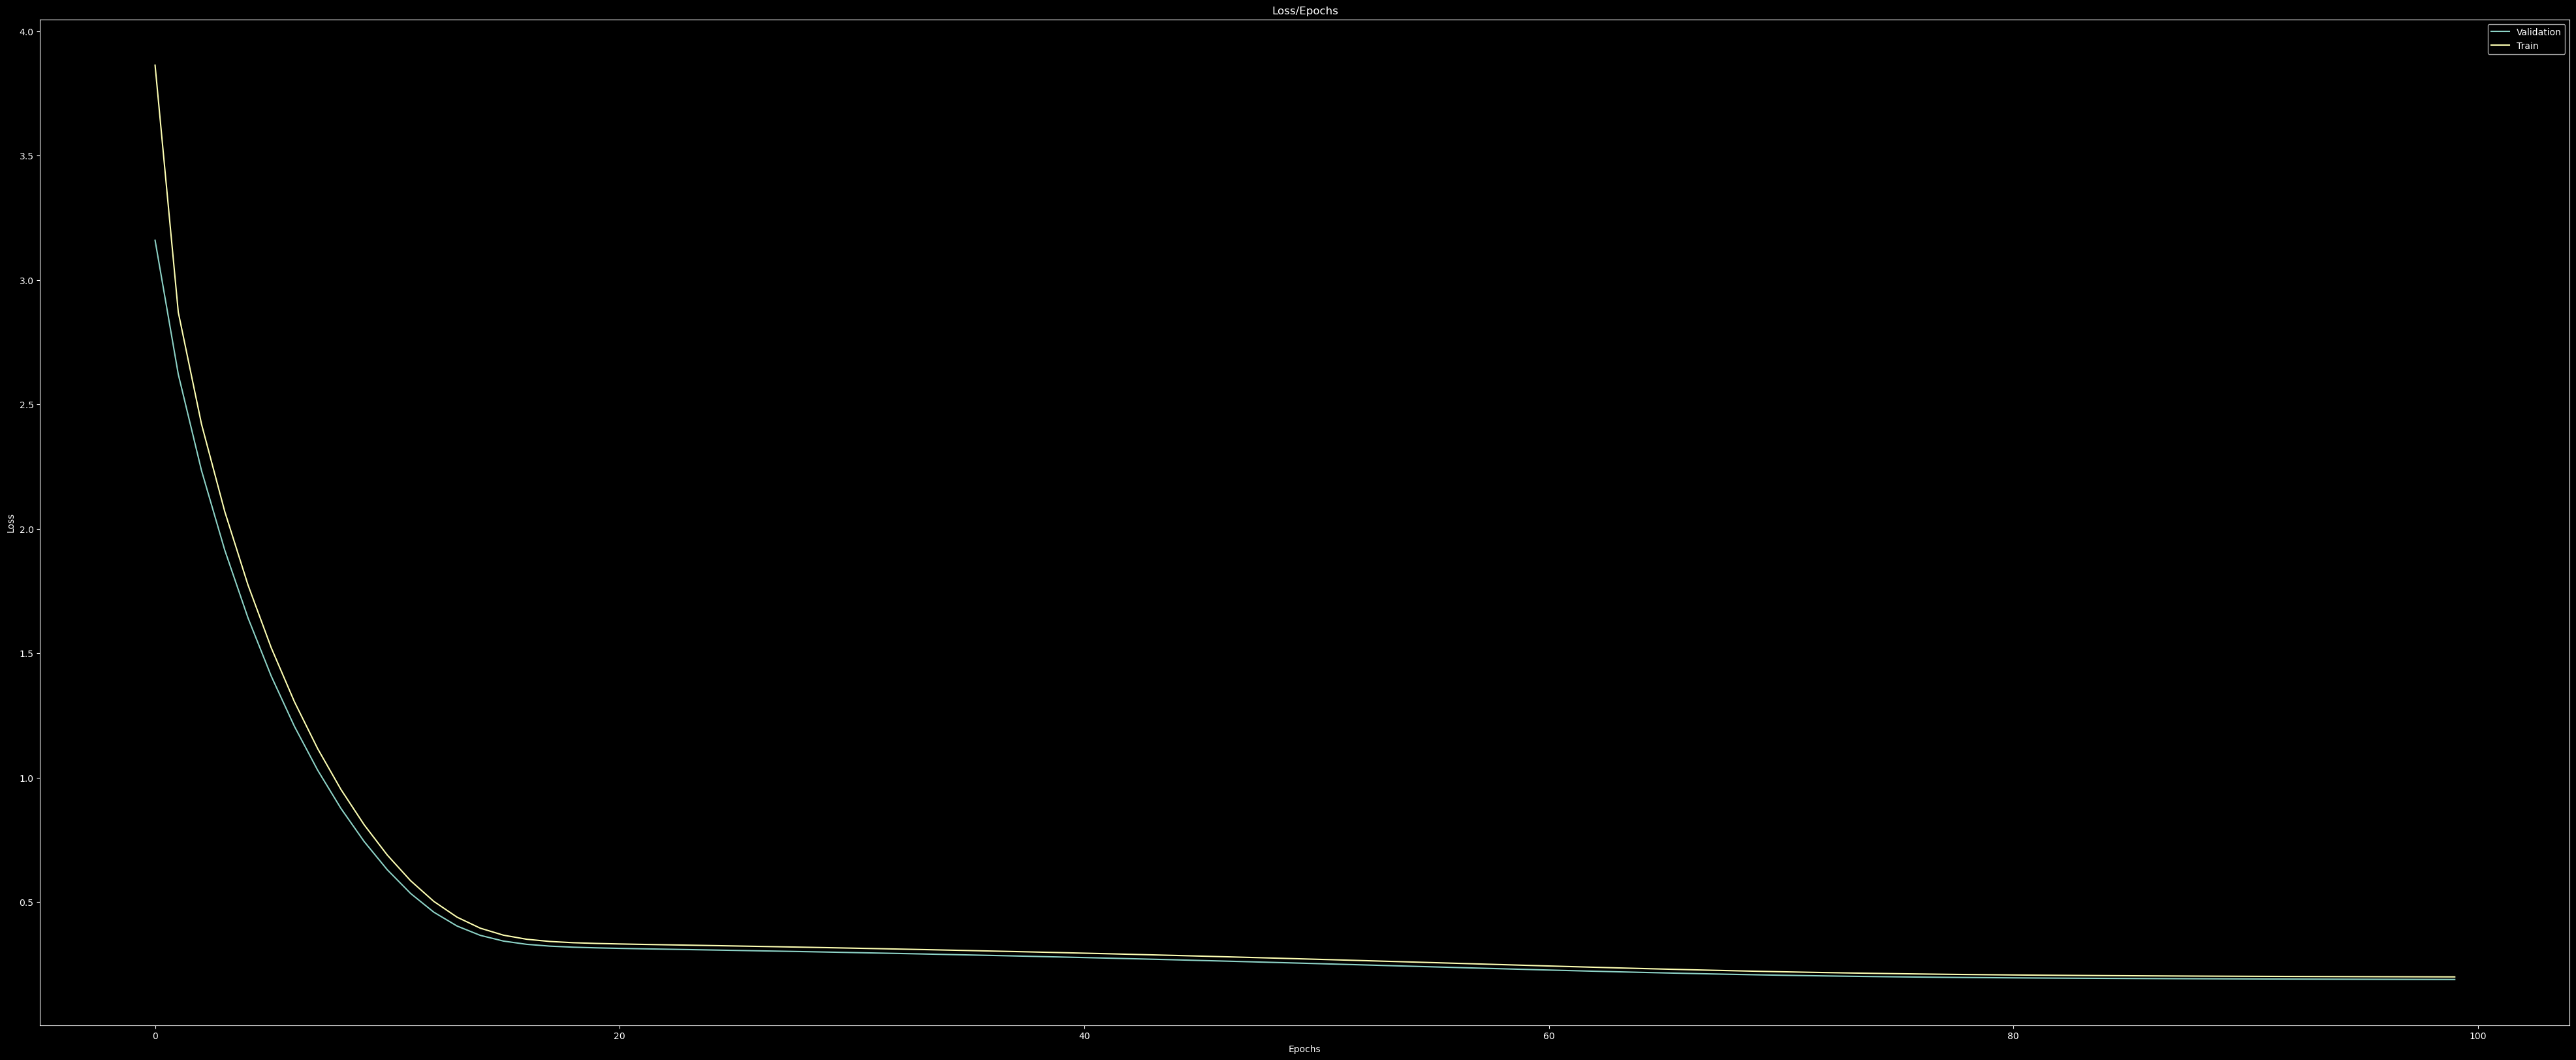

NN with 316.22776601683796 neurons
Last epoch train error 0.1988808810710907
Last epoch validation error 0.18844209611415863


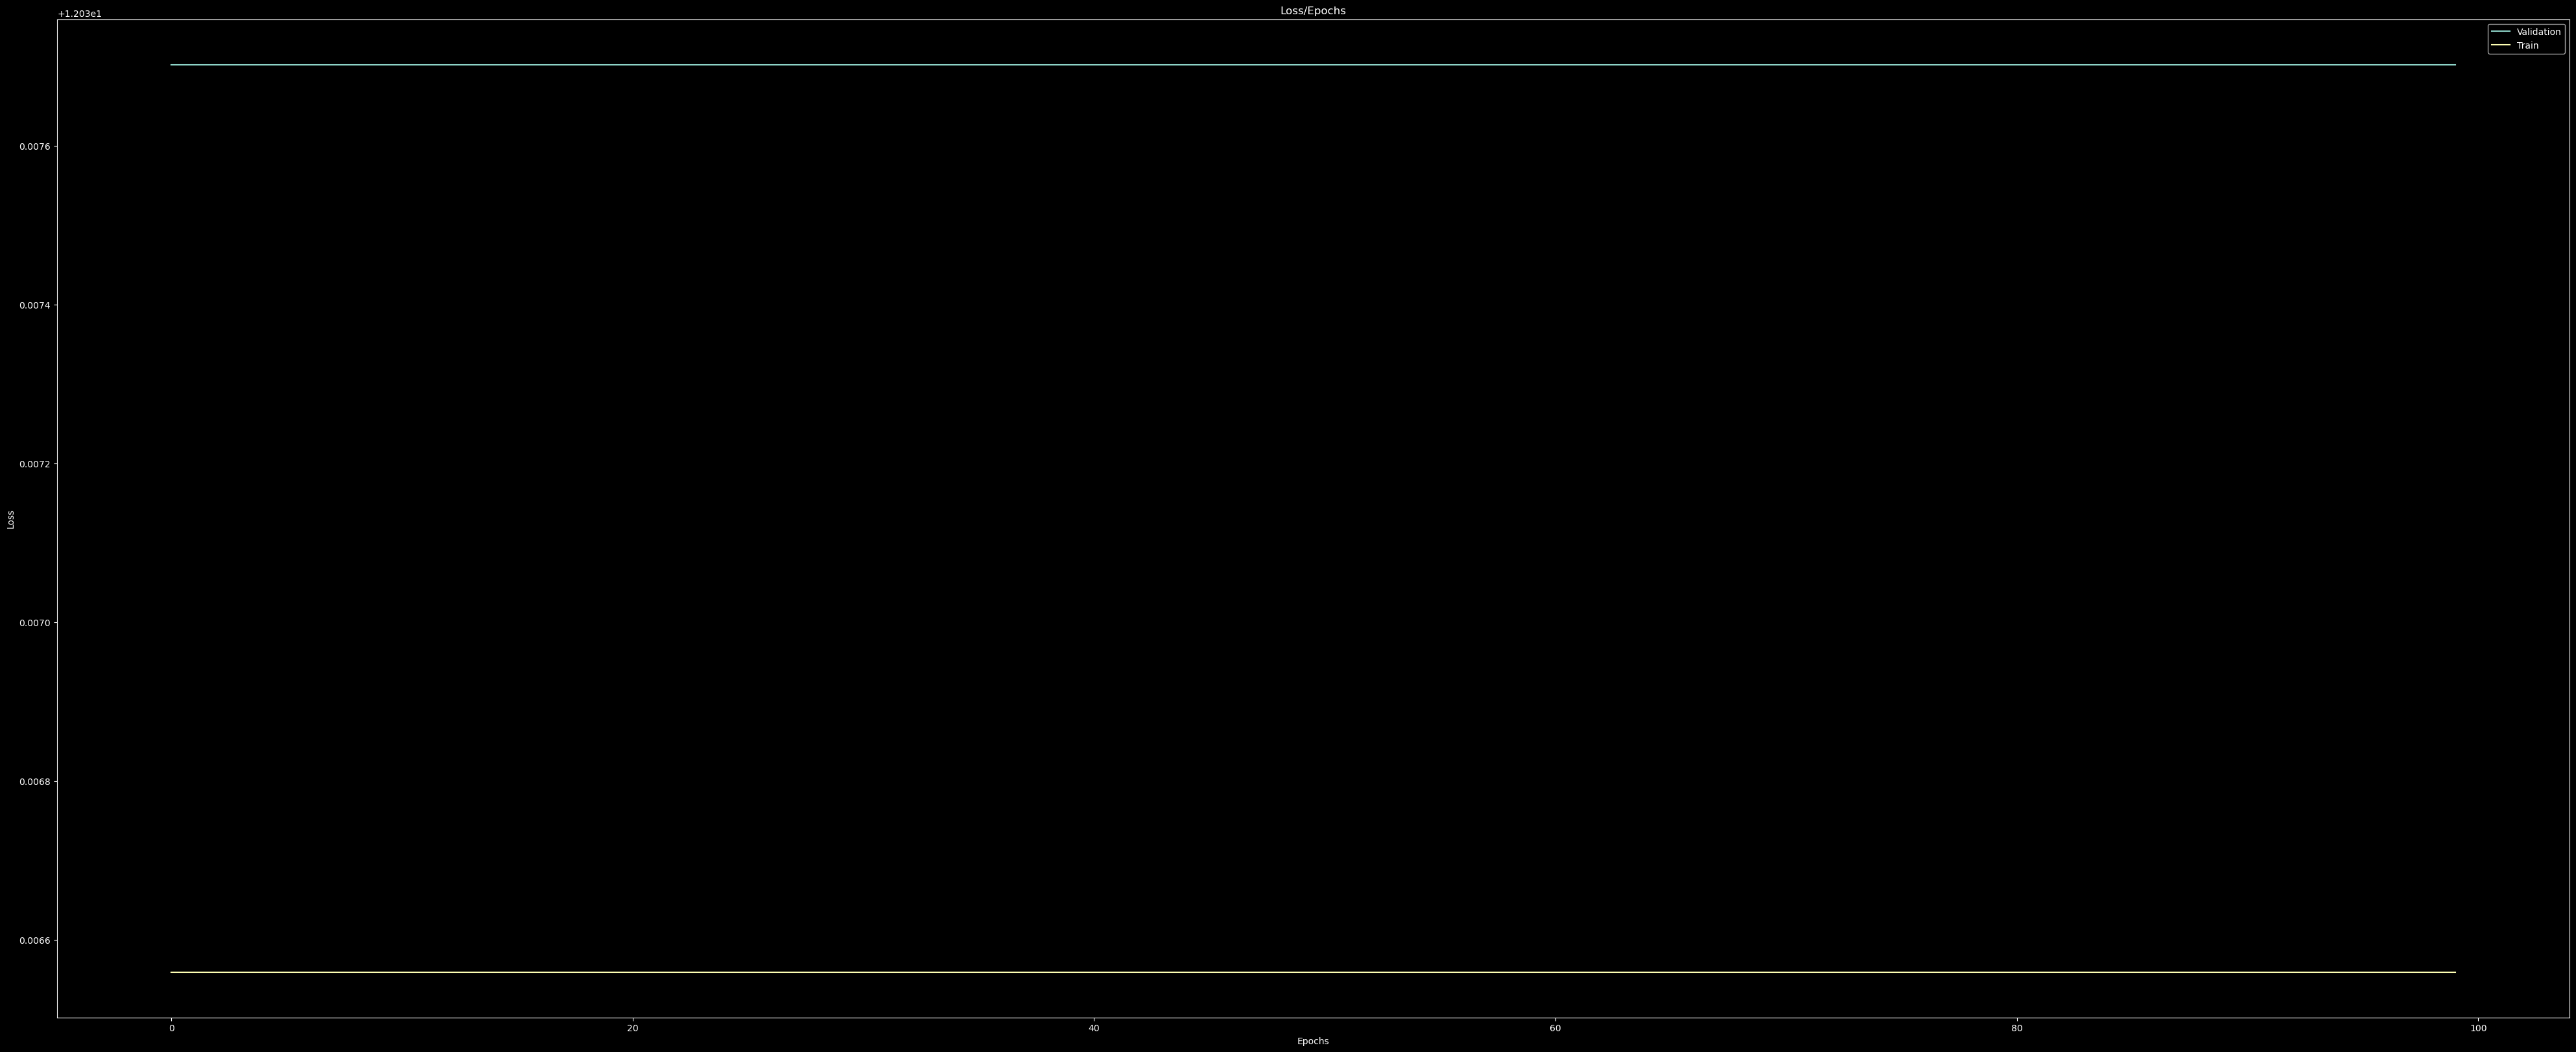

NN with 562.341325190349 neurons
Last epoch train error 12.036559104919434
Last epoch validation error 12.037702560424805


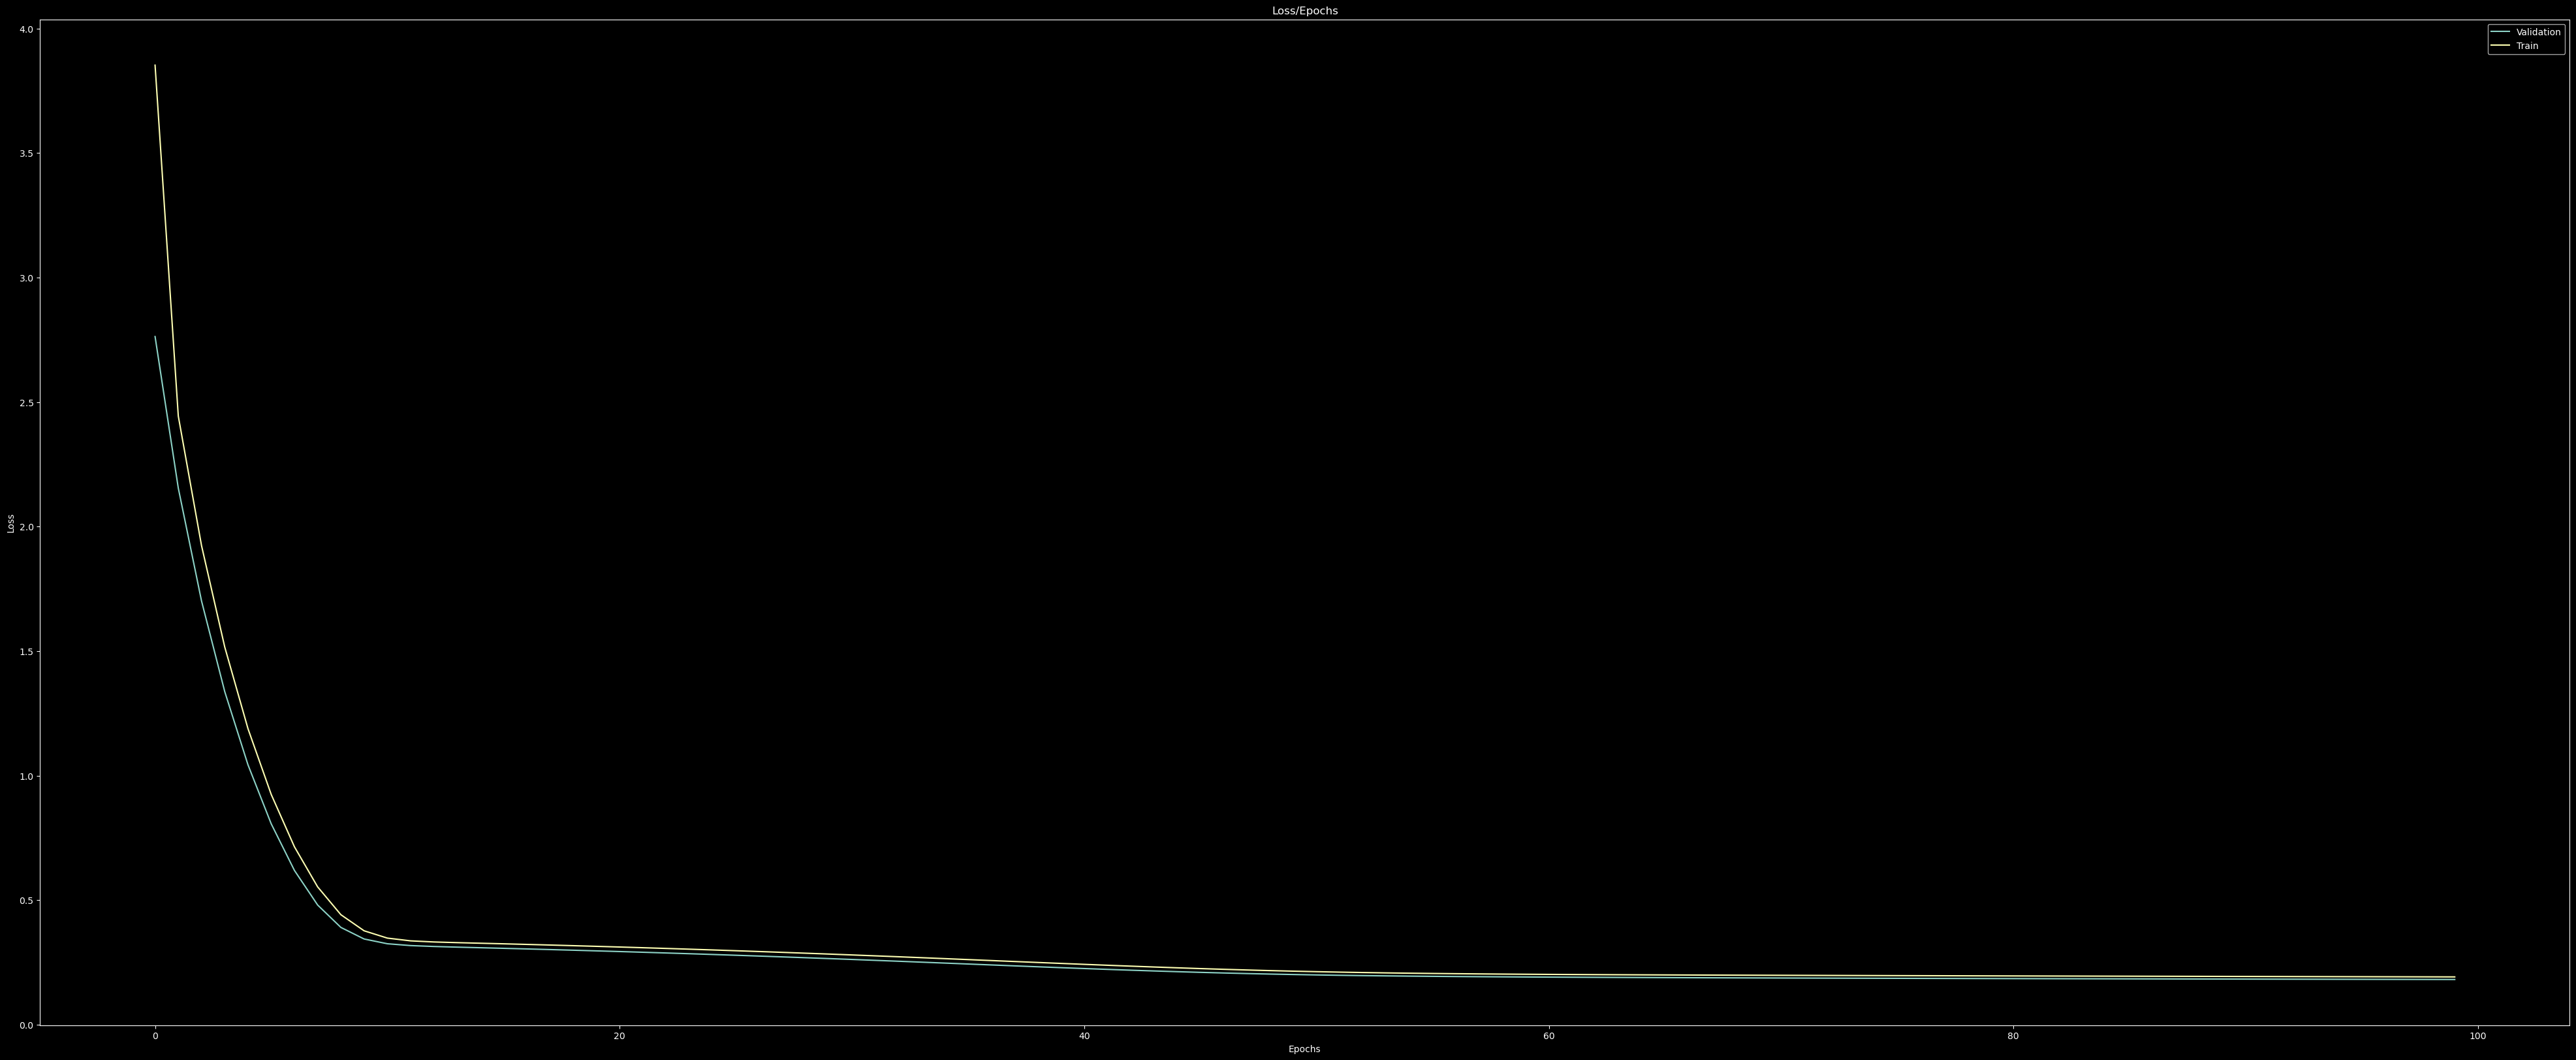

NN with 1000.0 neurons
Last epoch train error 0.19185838103294373
Last epoch validation error 0.1814596801996231


In [8]:
param_space_hidden_layer_size = np.logspace(start=2, stop=3, base=10, num=5)
results={}
for p in param_space_hidden_layer_size:
    nn = models.Sequential(
        [
            layers.Input((X_tr_proc.shape[1],)),
            layers.Dense(
                int(p),
                activation=activations.leaky_relu,
                kernel_initializer=GlorotUniform(0),
            ),
            layers.Dense(
                1, activation=activations.relu, kernel_initializer=GlorotUniform(0)
            ),
        ]
    )
    tr_err,_=train_nn(epochs=100, nn=nn, X=X_tr_proc, y=Y_tr, should_print_epoch_losses=True,additional_print_msg=f'NN with {p} neurons')
    results[p]=tr_err

Vredit da poistrazhime sho se deshavat so modelot so 516 neurons. 

In [31]:
built_nn1hid=lambda num_hidden_neurons: models.Sequential(
        [
            layers.Input((X_tr_proc.shape[1],)),
            layers.Dense(
                num_hidden_neurons,
                activation=activations.leaky_relu,
                kernel_initializer=GlorotUniform(0),
            ),
            layers.Dense(
                1, activation=activations.relu, kernel_initializer=GlorotUniform(0)
            ),
        ]
    )

Last epoch train error 12.036559104919434
Last epoch validation error 12.037702560424805


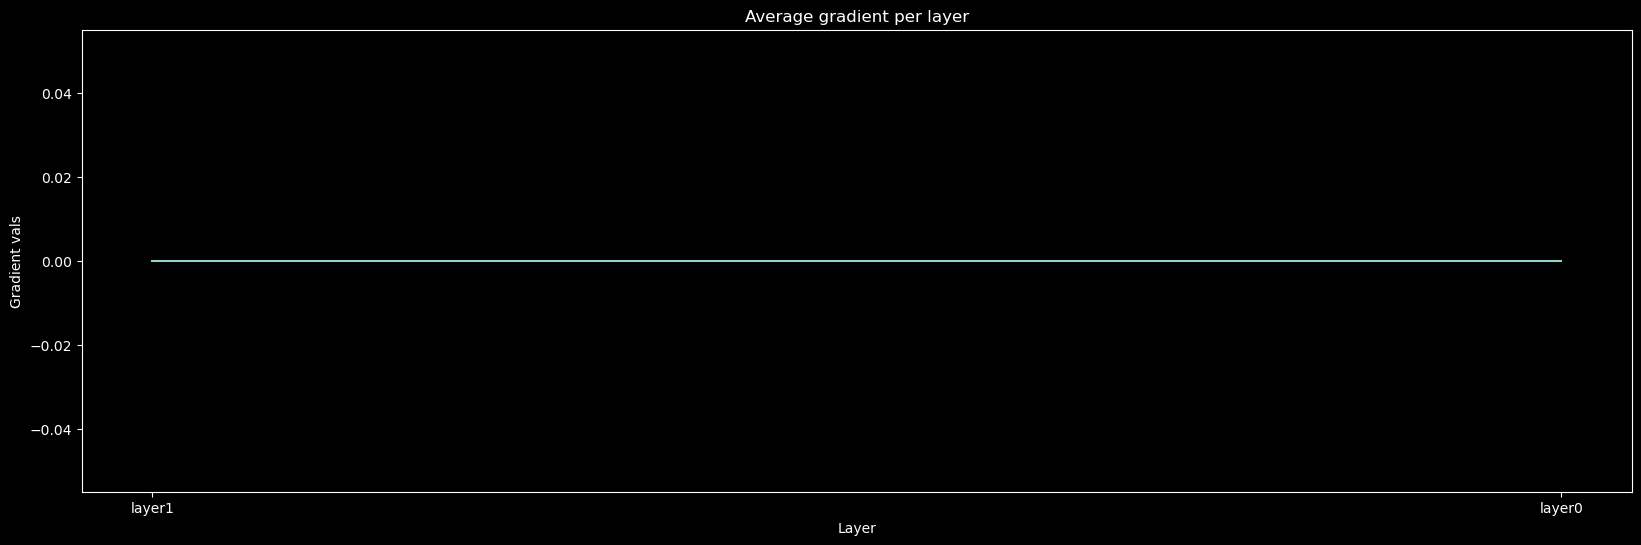

In [40]:
nn=built_nn1hid(562)
tr_err,_=train_nn(epochs=100, nn=nn, X=X_tr_proc, y=Y_tr)
plot_avrg_grads_layer(nn=nn,X=X_val,y=Y_val)

Ochekuvano, sepak ne se mevnit errorot vo train i validation splitot. 

In [33]:
hidden,last=nn.get_layer(index=0),nn.get_layer(index=1) 
hidden,last

(<Dense name=dense_16, built=True>, <Dense name=dense_17, built=True>)

In [39]:
w,bias=hidden.get_weights()
print(w) 
print('============')
print(bias)

[[-0.05591795  0.03986254  0.05806168 ...  0.08460426  0.00856552
  -0.01477595]
 [ 0.06494697  0.07047439  0.03323046 ...  0.04067353 -0.00894052
  -0.07565743]
 [ 0.07626814 -0.03271232 -0.0845197  ...  0.04103617 -0.0016689
   0.05306266]
 ...
 [ 0.01566681 -0.03443589 -0.03545    ... -0.03669782  0.01882672
  -0.04206852]
 [-0.03996128 -0.02106434 -0.06935702 ...  0.04189626 -0.04212264
  -0.01043956]
 [-0.07063147 -0.04114742 -0.03223182 ... -0.01626864  0.02040599
   0.09396823]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [41]:
with tf.GradientTape() as gradient_recording: 
    output=nn(X_val) 
    loss=tf_rmsle(Y_tr,output)

gradient=gradient_recording.gradient(loss,nn.trainable_variables)
gradient

[<tf.Tensor: shape=(79, 562), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(562,), dtype=float32, numpy=
 array([ 0., -0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
         0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,
         0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0.,
        -0., -0., -0.,  0., -0., -0., -0., -0.,  0.,  0.,  0., -0.,  0.,
        -0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0., -0., -0.,  0., -0.,
        -0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0.,  0., -0.,
         0., -0., -0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,  0.,  0.,
         0., -0., -0.,  0., -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,
        -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0

Chudno e zsh bias matricata e 0la celata. 

In [65]:
nn1=built_nn1hid(562)
hid,output=nn1.get_layer(index=0),nn1.get_layer(index=1) 

batch1_X=next(tf.data.Dataset.from_tensor_slices(tf.constant(X_tr_proc.values)).batch(batch_size=32).as_numpy_iterator())
batch1_y=Y_tr[:32]

with tf.GradientTape() as grad_tape: 
    loss=tf_rmsle(batch1_y,nn1(batch1_X))

gradients=grad_tape.gradient(loss,[hid.trainable_variables,output.trainable_variables])
gradients[0],gradients[1]

([<tf.Tensor: shape=(79, 562), dtype=float32, numpy=
  array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
  <tf.Tensor: shape=(562,), dtype=float32, numpy=
  array([ 0., -0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,
          0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0.,
         -0., -0., -0.,  0., -0., -0., -0., -0.,  0.,  0.,  0., -0.,  0.,
         -0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0., -0., -0.,  0., -0.,
         -0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0.,  0., -0.,
          0., -0., -0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,  0.,  0.,
          0., -0., -0.,  0., -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,
         -0.,  0.,  0.,  0.,  0.,

In [84]:
leaky_relu=keras.activations.leaky_relu
relu=keras.activations.relu

hid(batch1_X)

<tf.Tensor: shape=(32, 562), dtype=float32, numpy=
array([[  48.899807,   75.530334,  -82.20367 , ...,  -45.86897 ,
        -129.31017 ,  344.17792 ],
       [  48.377747,  147.9932  ,  -75.59942 , ...,  -61.152363,
        -119.58994 ,  387.27277 ],
       [  99.09359 ,  108.79673 ,  -72.53759 , ...,  -45.78488 ,
        -150.72957 ,  383.43353 ],
       ...,
       [  97.40745 ,   69.65797 ,  -75.587975, ...,  -48.989697,
        -143.84785 ,  316.77133 ],
       [ 106.61254 ,   71.592026,  -87.76022 , ...,  -60.58694 ,
        -185.61613 ,  593.9895  ],
       [  50.632324,   80.71417 ,  -56.87266 , ...,  -36.18404 ,
         -86.991325,  221.3256  ]], dtype=float32)>

In [97]:
hid(batch1_X) @  output.weights[0].numpy() 

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-266.03992],
       [-267.01672],
       [-252.22246],
       [-256.20227],
       [-181.64142],
       [-350.58618],
       [-342.16916],
       [-232.04971],
       [-358.7479 ],
       [-260.23056],
       [-264.29306],
       [-395.7088 ],
       [-396.3107 ],
       [-416.12738],
       [-277.63992],
       [-254.06514],
       [-546.6205 ],
       [-248.3863 ],
       [-292.0932 ],
       [-412.15564],
       [-309.73315],
       [-418.89282],
       [-208.29504],
       [-328.1238 ],
       [-361.99487],
       [-149.43411],
       [-614.80066],
       [-252.7927 ],
       [-291.58795],
       [-215.13583],
       [-365.37653],
       [-167.09657]], dtype=float32)>

In [98]:
relu(hid(batch1_X) @  output.weights[0].numpy() )

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

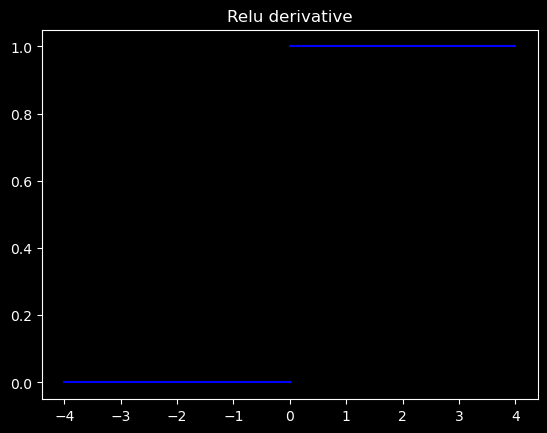

In [109]:
plt.title("Relu derivative")
plt.plot([-1 * i for i in range(5)], [0 for _ in range(5)],c='b')
plt.plot([1 * i for i in range(5)], [1 for _ in range(5)],c='b')
plt.show() 

Znachit deka imame dying relu problem tuka. Sega ke mu udrime relu na ovie outputs ke dobijame 0lki sekade i nemat da imat update nikade. 

Relu tuka ni e dobra activaciska funckija, bidejki gi gi clipvit rezultatite na 0la, kako najmala vrednost. Spored to sakam nekako da napram da ta ostanit na outputot. Bidejki gore ovie 2ve layers imat negativni weights, od pochetokot, mozhit da ja smenime inicijalizacijata na weights so to sho samo pozitivni ke assigvime na pochetok. Ova nemat vo sekoja situacija celosno da go reshit problemot, bidejki pak e vozmozhno vo updejtvenjeto na weights tie da stanat takvi sho ke naprat da se outputvit negativna vrednost za linearniot del.  

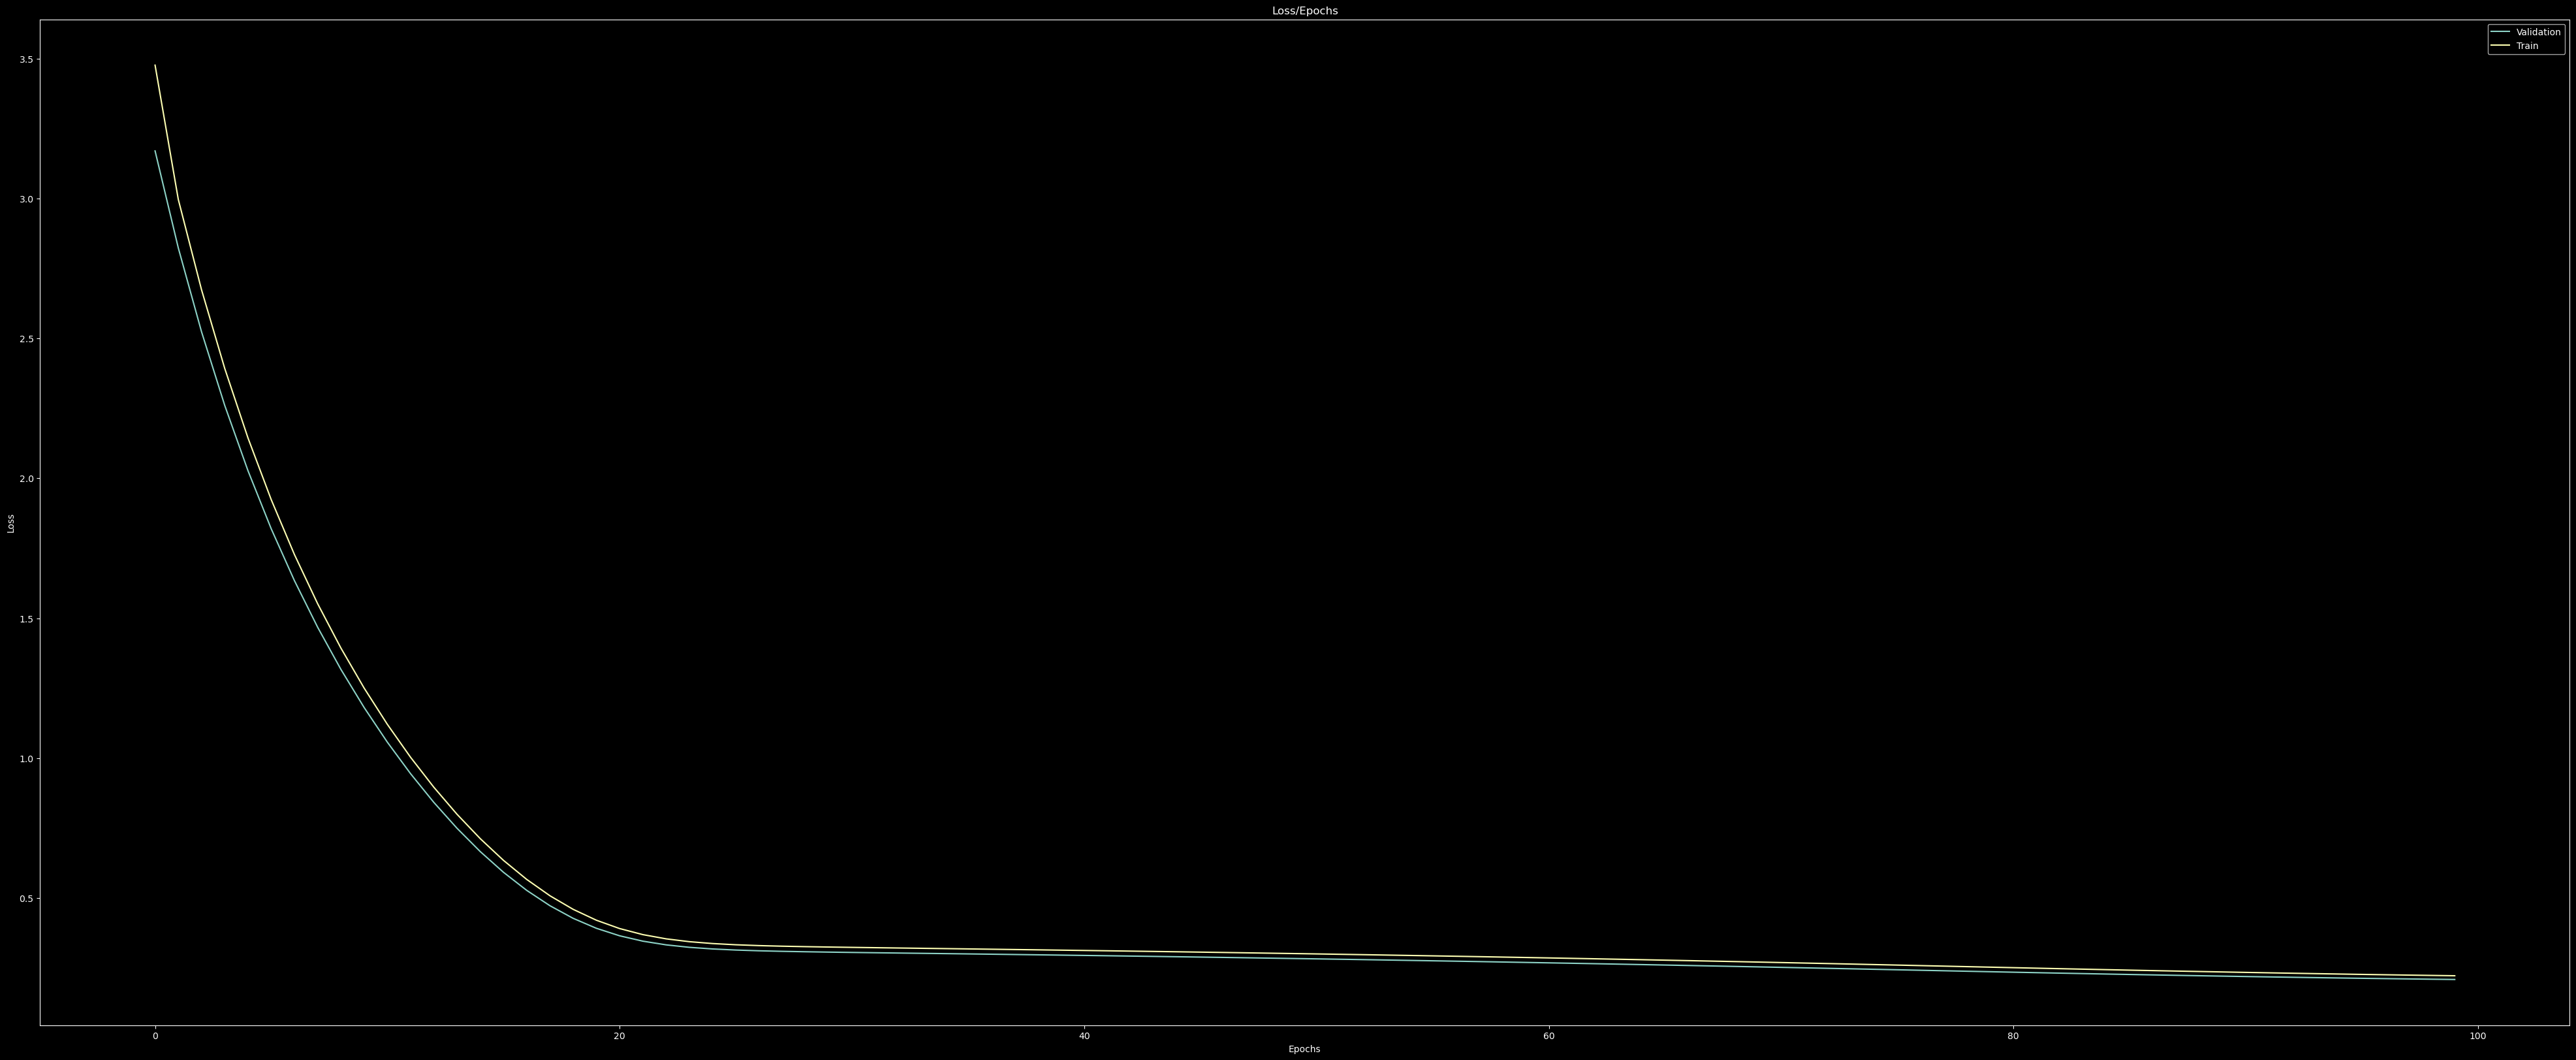

NN with 100.0 neurons
Last epoch train error 0.22216689586639404
Last epoch validation error 0.208811953663826


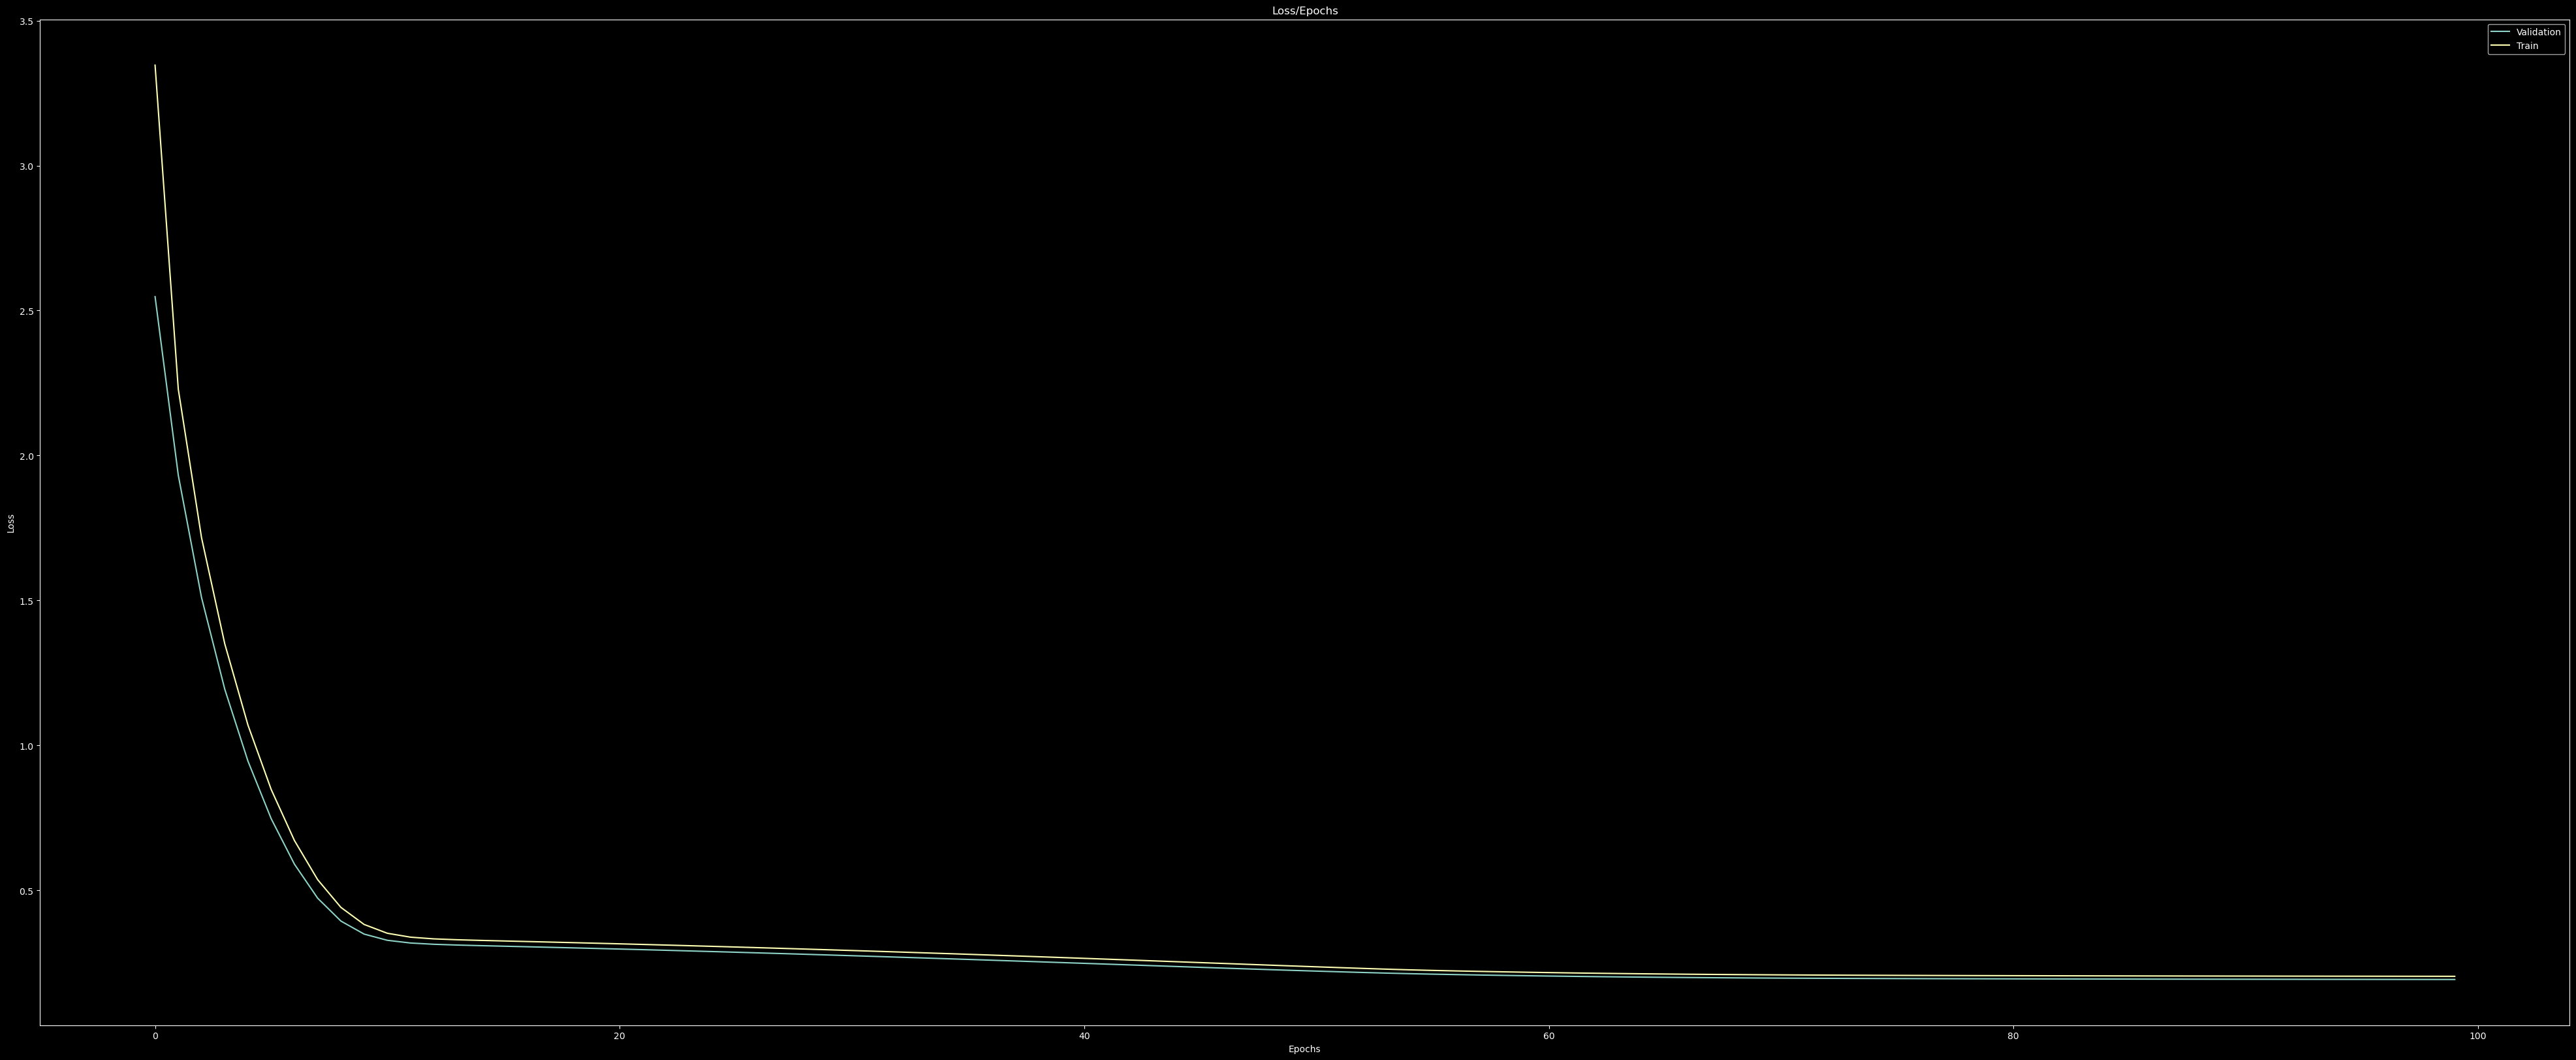

NN with 177.82794100389228 neurons
Last epoch train error 0.20387151837348938
Last epoch validation error 0.19293463230133057


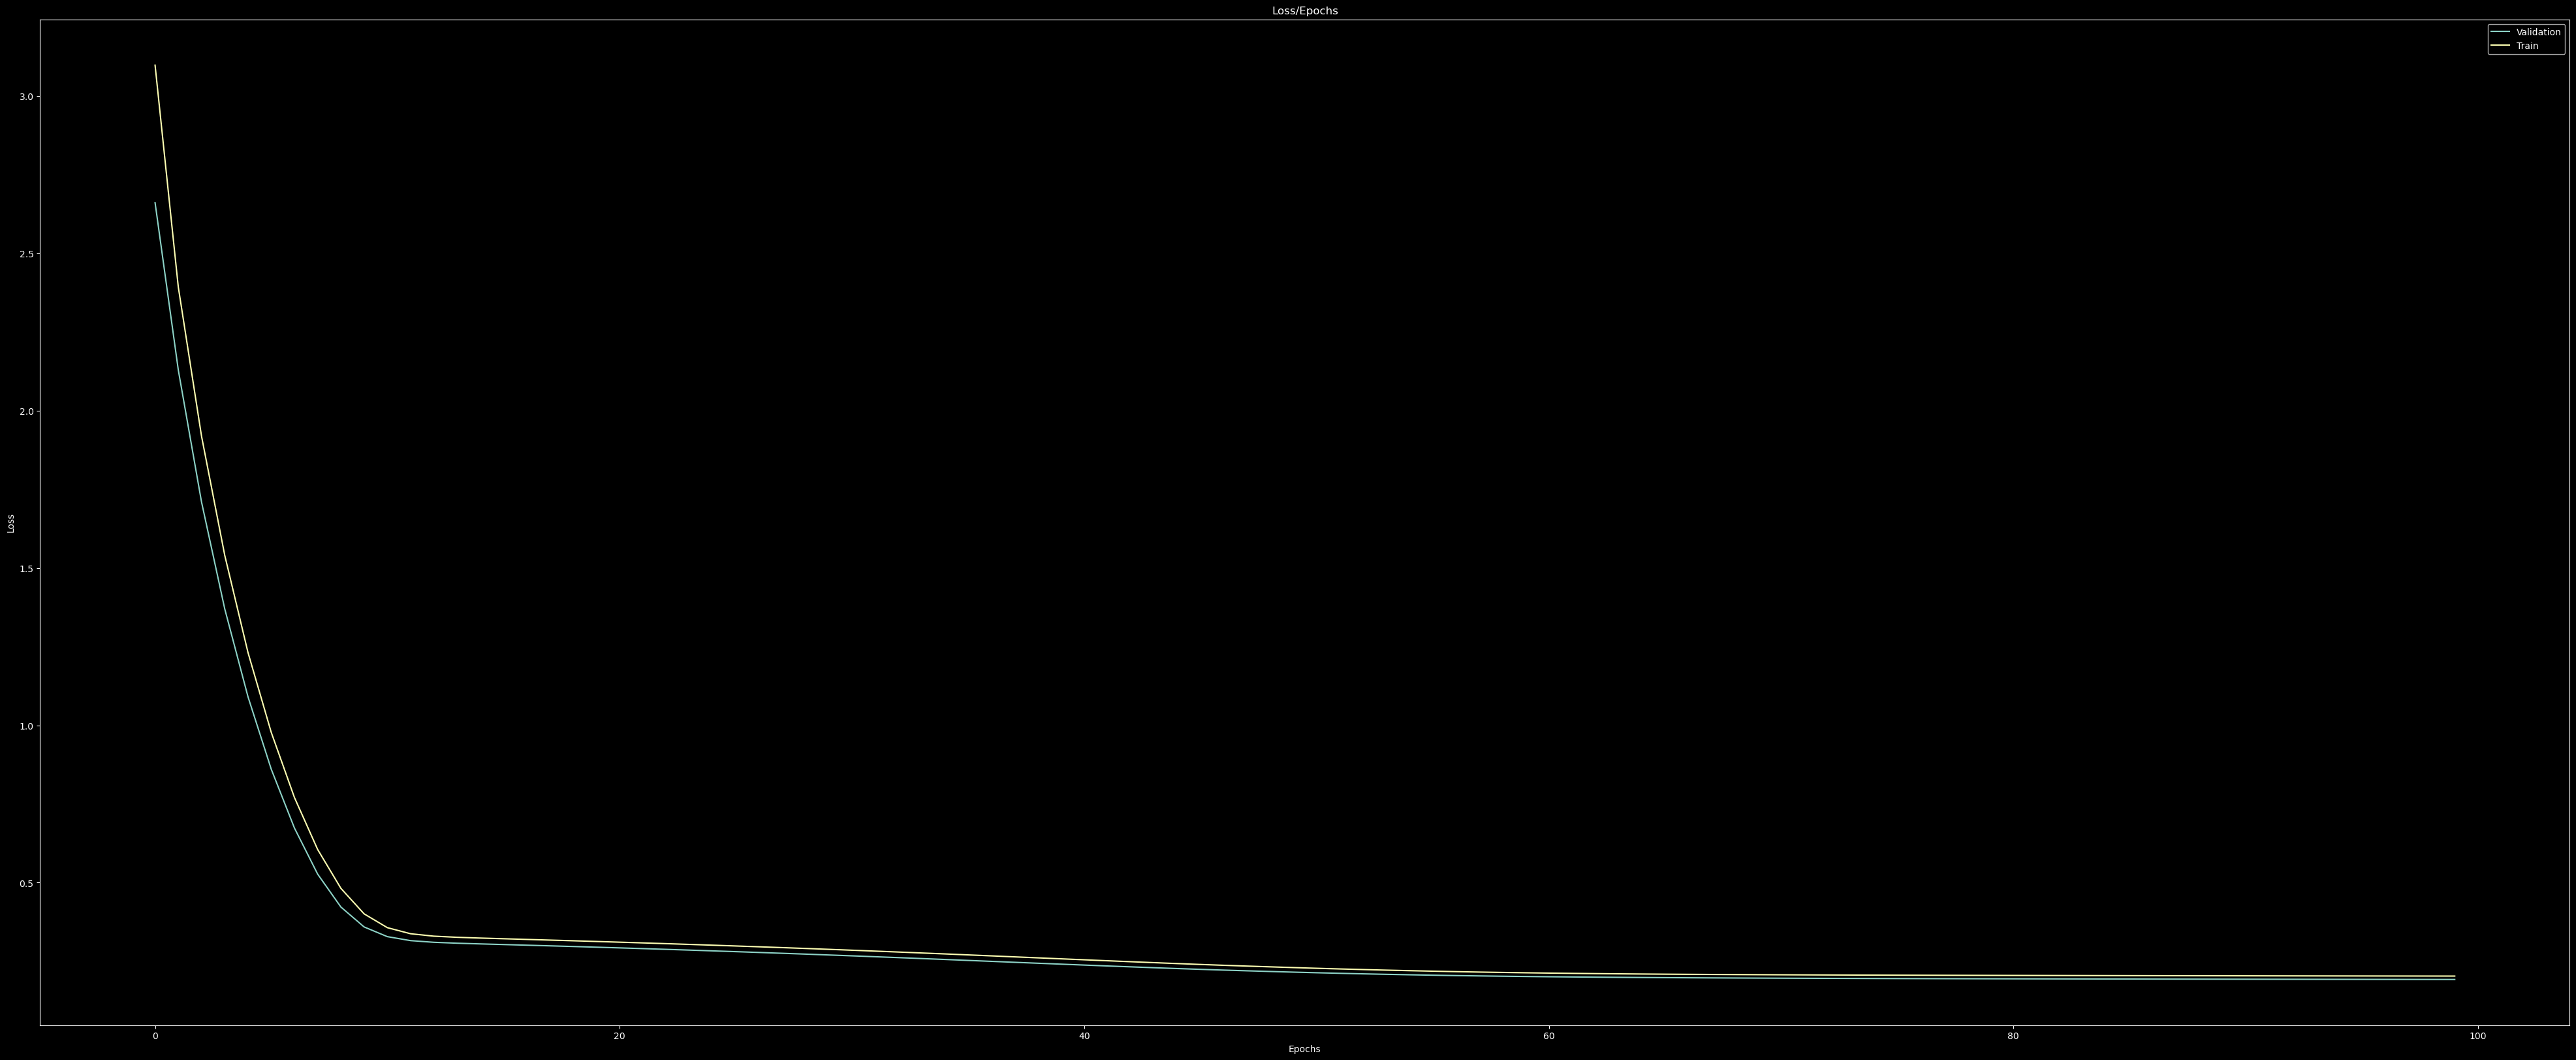

NN with 316.22776601683796 neurons
Last epoch train error 0.20328591763973236
Last epoch validation error 0.1924528181552887


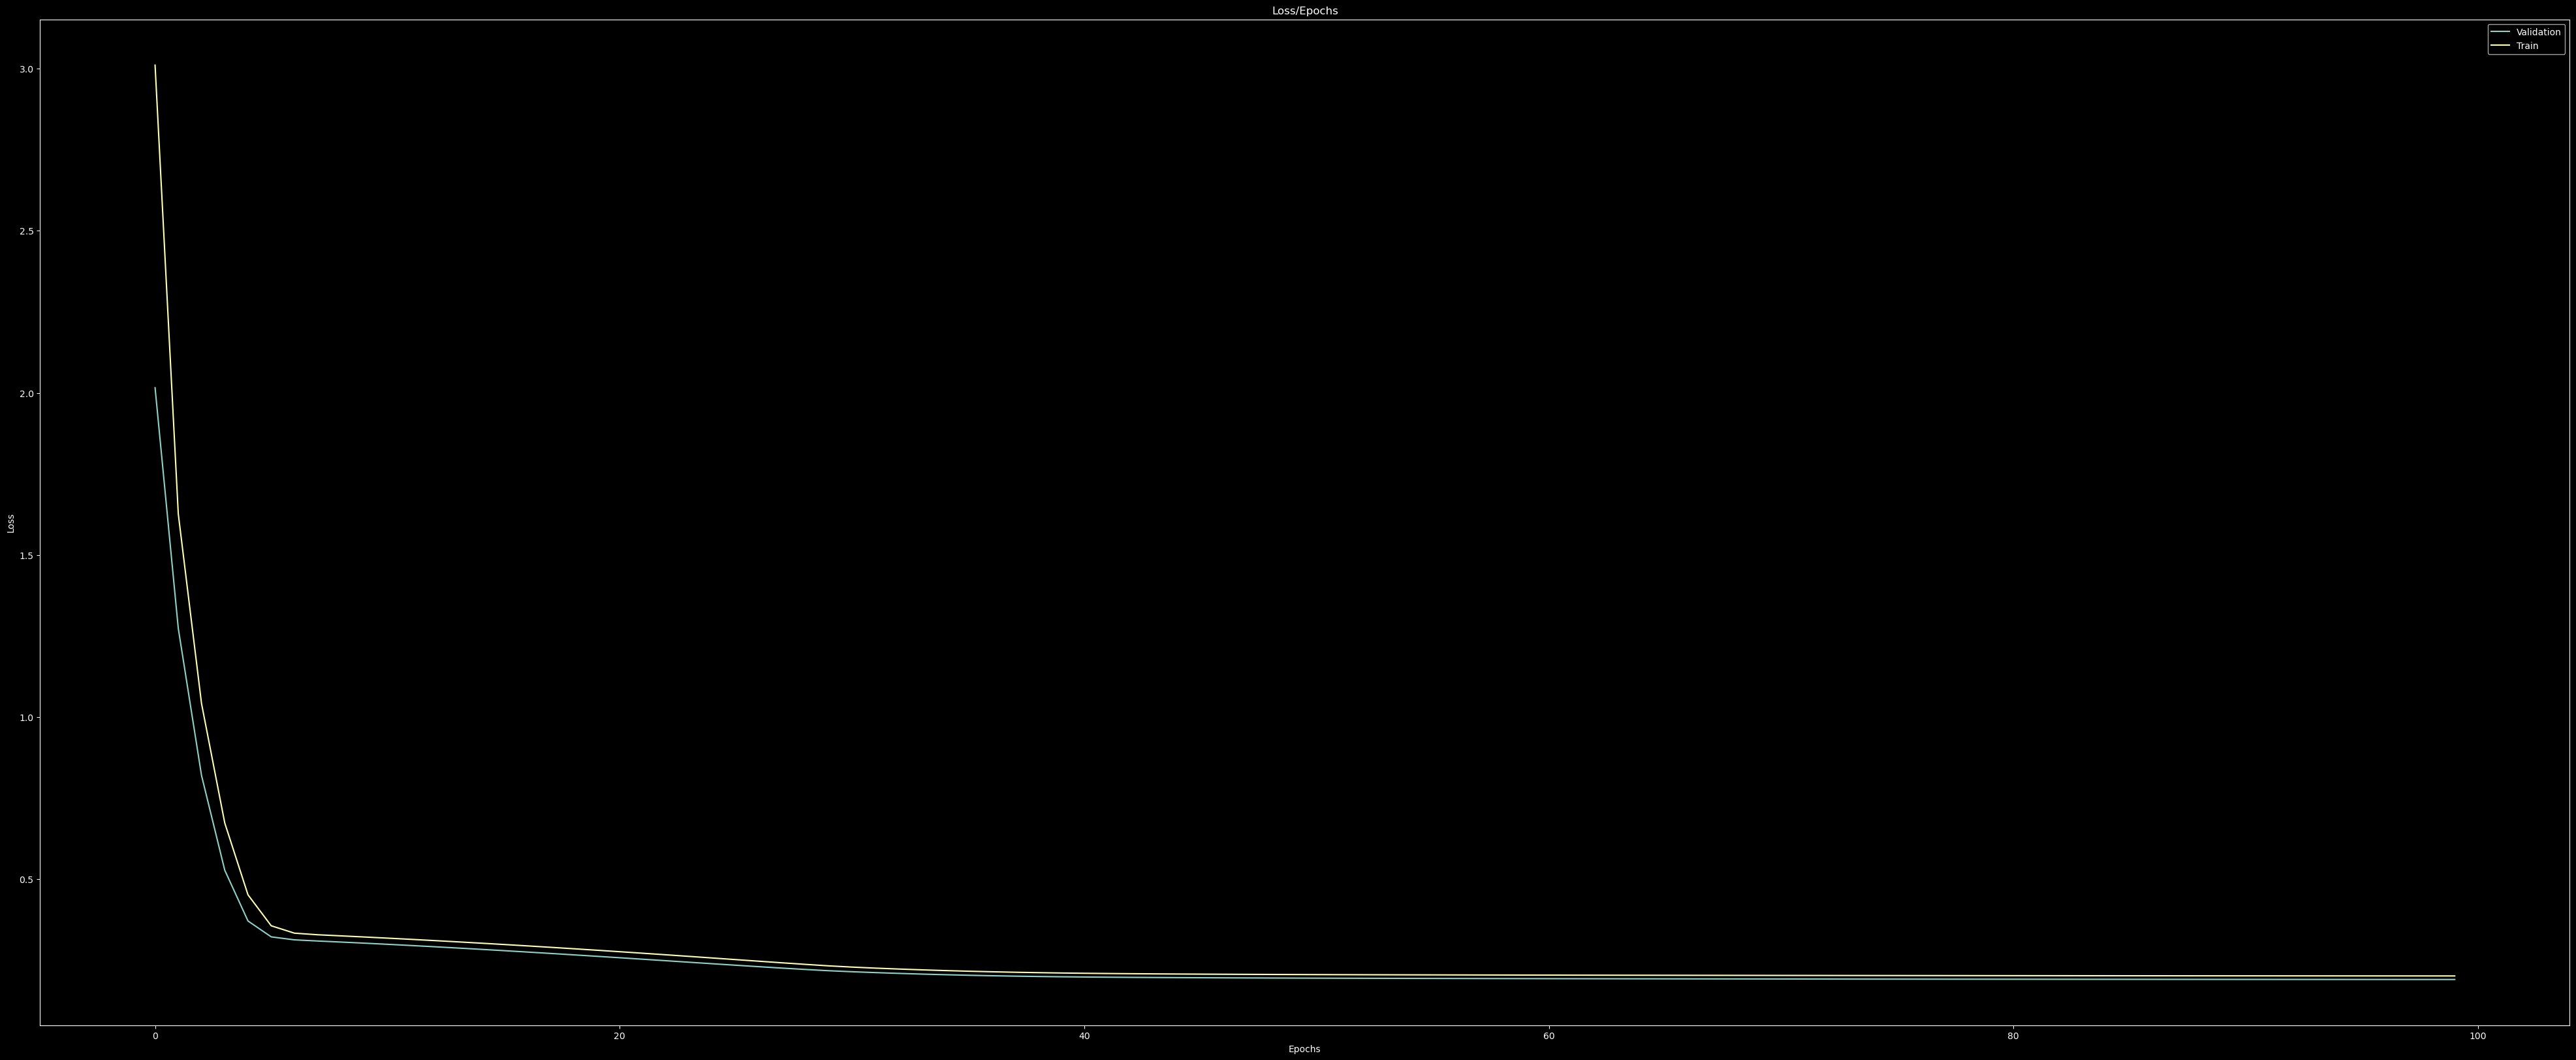

NN with 562.341325190349 neurons
Last epoch train error 0.20143933594226837
Last epoch validation error 0.19048652052879333


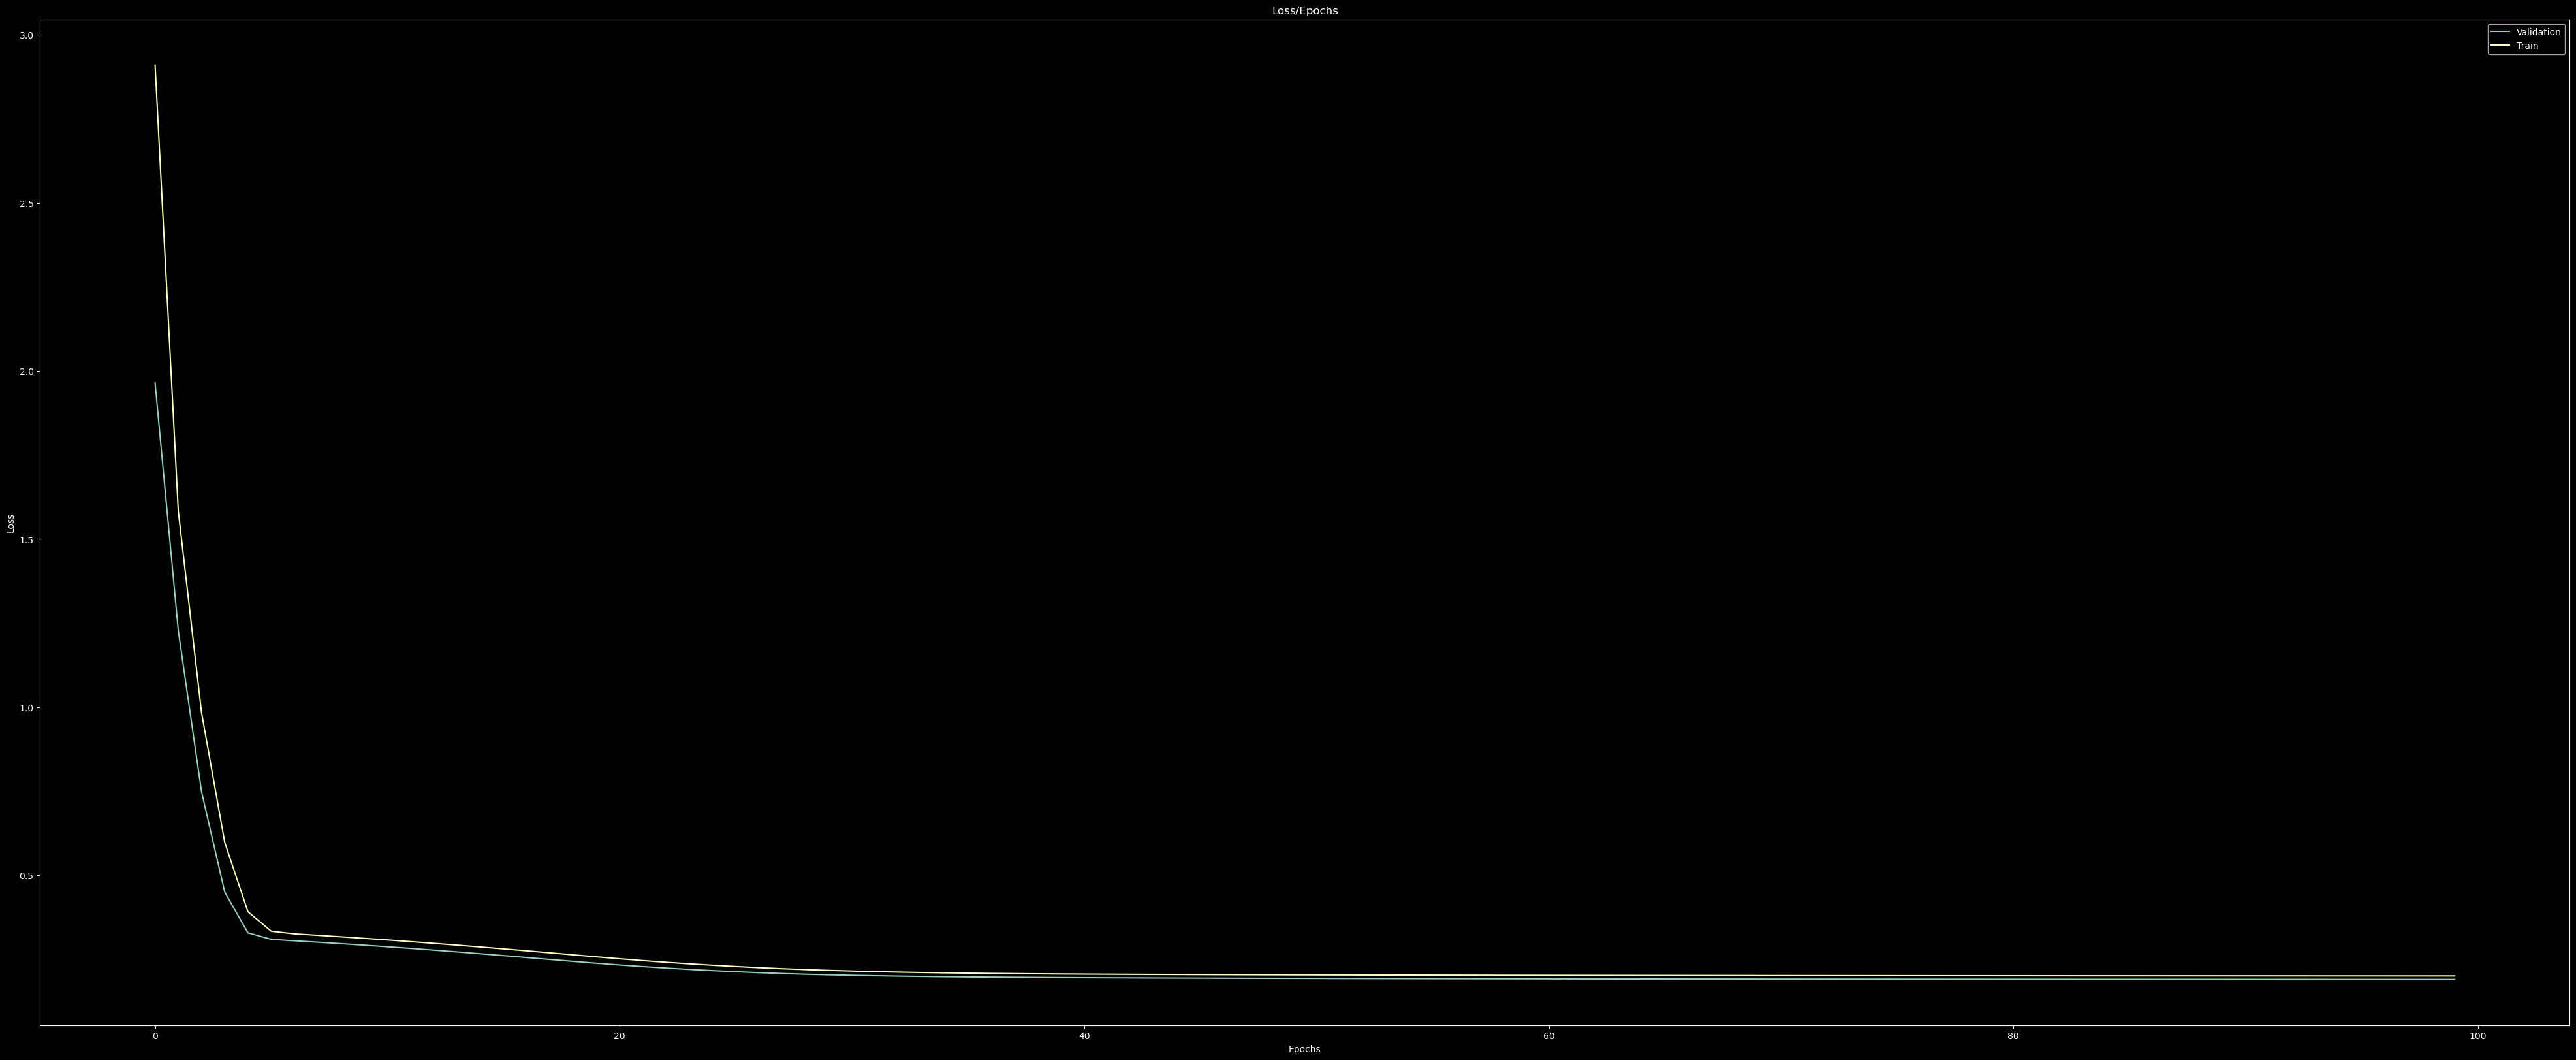

NN with 1000.0 neurons
Last epoch train error 0.20093993842601776
Last epoch validation error 0.1904384046792984


In [111]:
param_space_hidden_layer_size = np.logspace(start=2, stop=3, base=10, num=5)
results = {}
for p in param_space_hidden_layer_size:
    nn = models.Sequential(
        [
            layers.Input((X_tr_proc.shape[1],)),
            layers.Dense(
                int(p),
                activation=activations.leaky_relu,
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg(),
            ),
            layers.Dense(
                1, 
                activation=activations.relu,
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg() 
            ),
        ]
    )
    tr_err, _ = train_nn(
        epochs=100,
        nn=nn,
        X=X_tr_proc,
        y=Y_tr,
        should_print_epoch_losses=True,
        additional_print_msg=f"NN with {p} neurons",
    )
    results[p] = tr_err

So ova uspevme da go popreme problemot so dying relu. 

In [135]:
pipe_scalling=copy.deepcopy(pipe_data) 
pipe_scalling.steps.append(("Scalling",StandardScaler())) 
pipe_scalling.fit(X_tr)
X_tr_scalled,X_test_scalled=pipe_scalling.transform(X_tr),pipe_scalling.transform(X_tst)

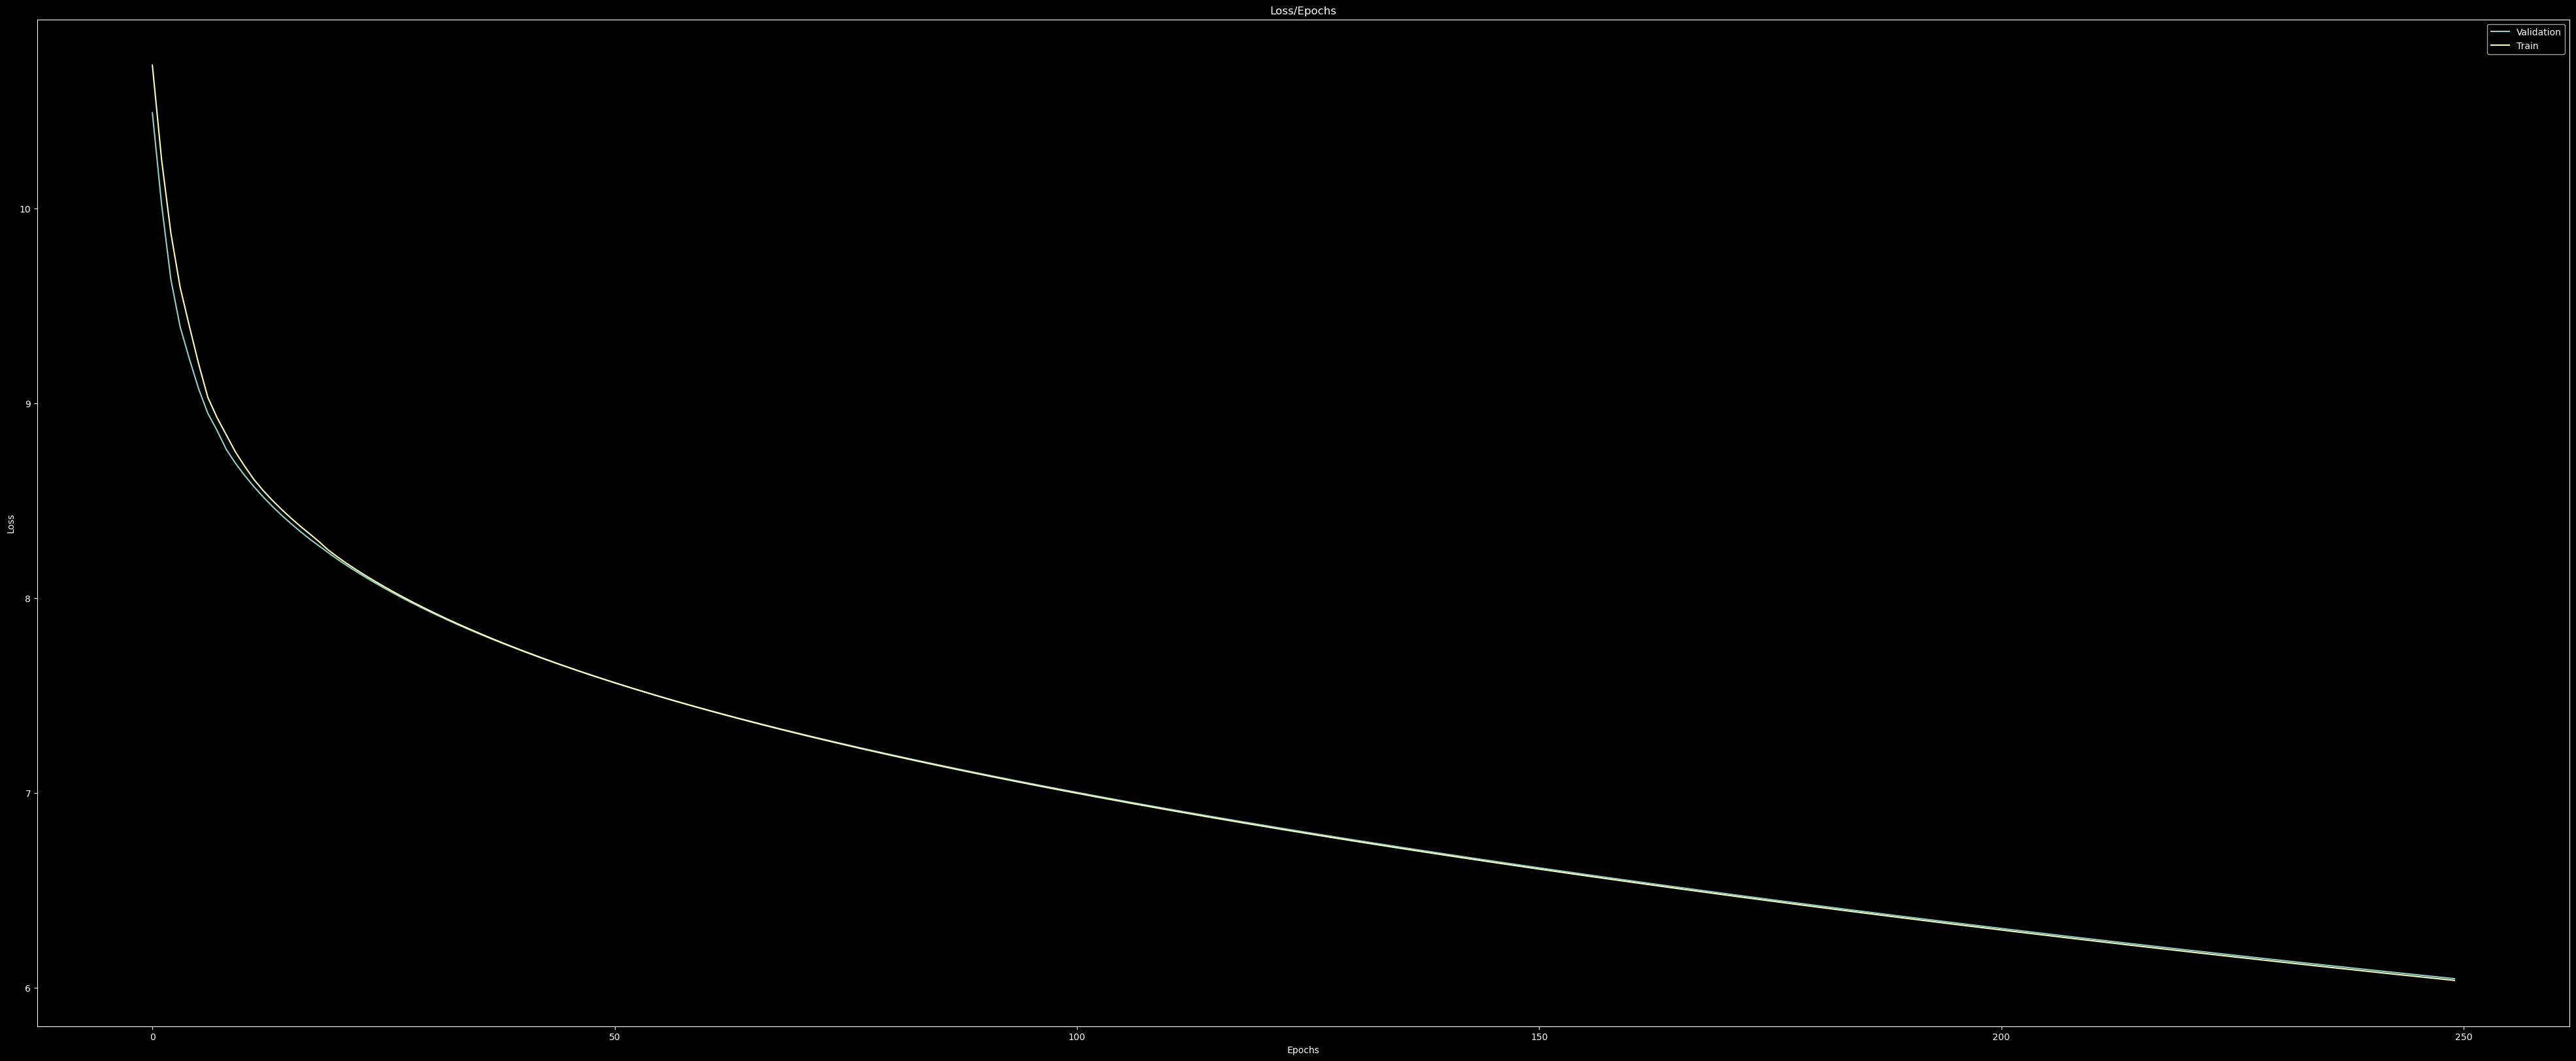

NN with 100 and <function tanh at 0x7e1f012cfeb0>
Last epoch train error 6.038288116455078
Last epoch validation error 6.04723596572876


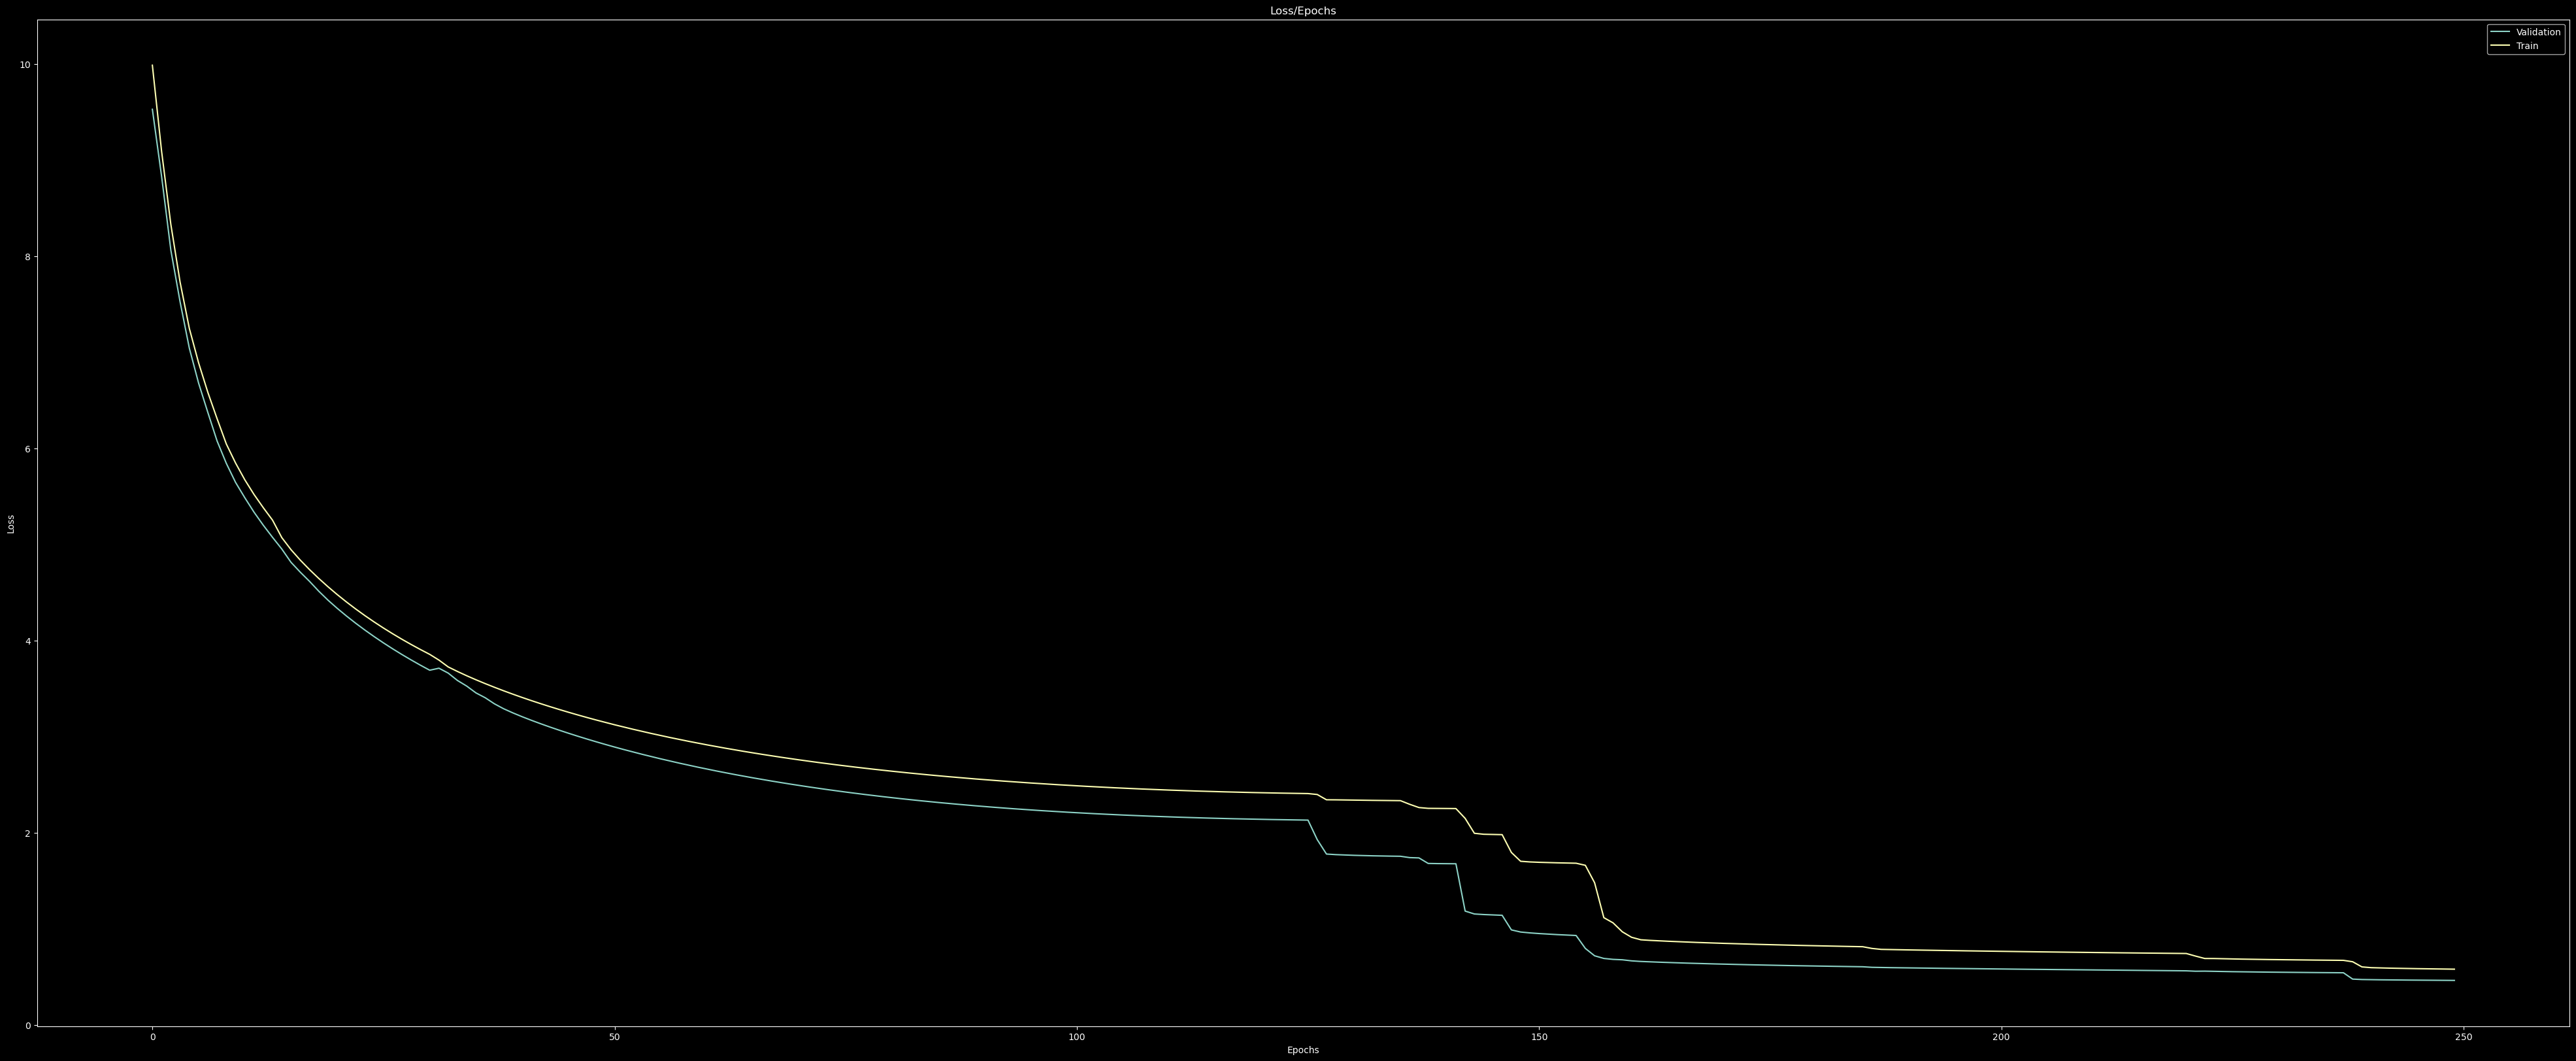

NN with 100 and <function leaky_relu at 0x7e1f013623b0>
Last epoch train error 0.5825694799423218
Last epoch validation error 0.46559640765190125


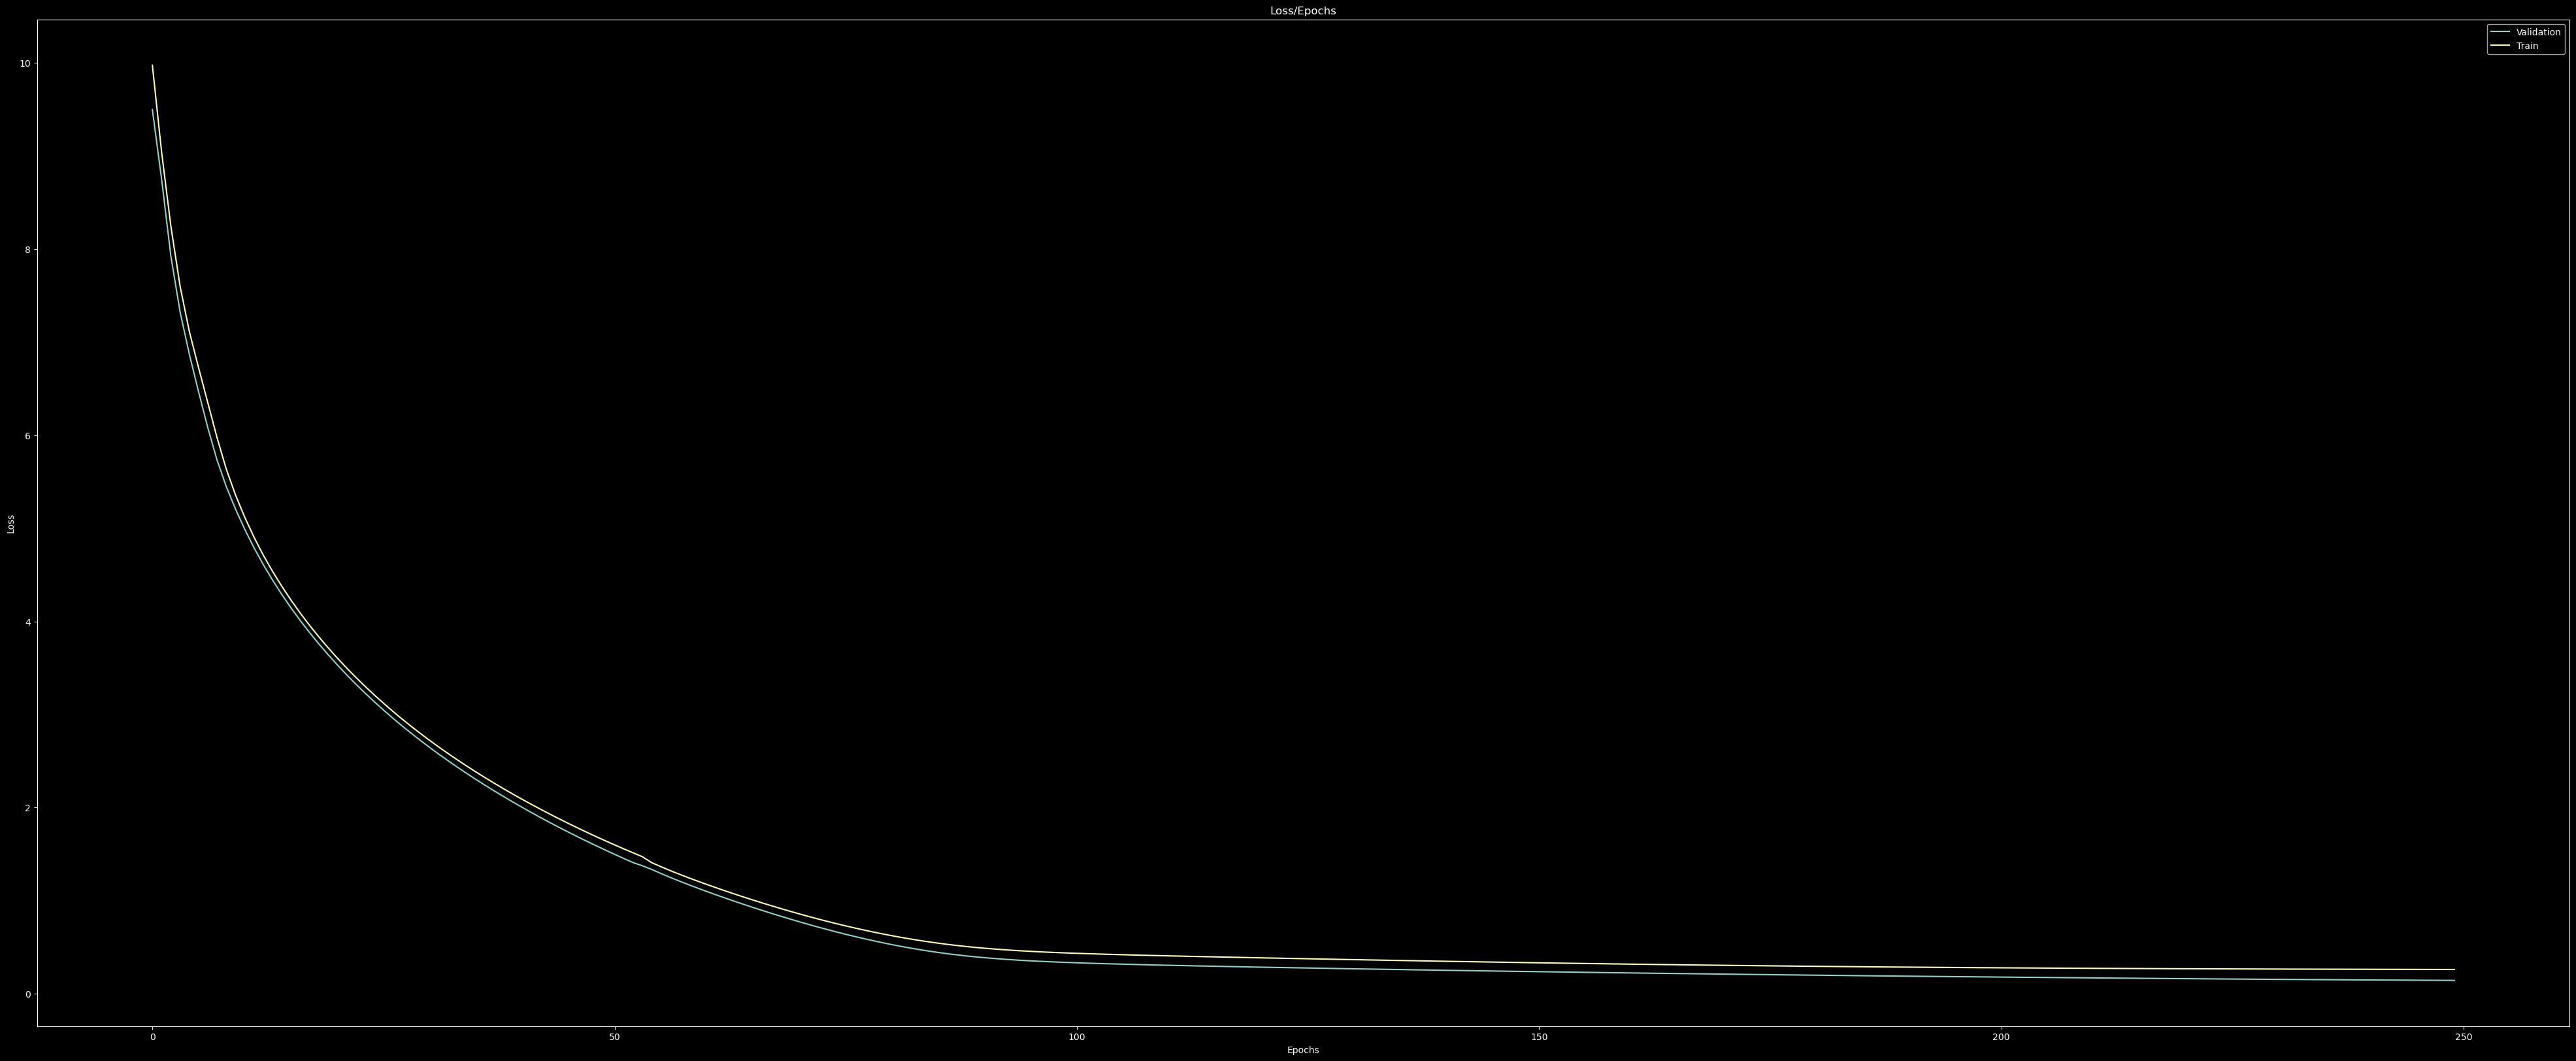

NN with 100 and <function relu at 0x7e1f01917d00>
Last epoch train error 0.25987178087234497
Last epoch validation error 0.14247599244117737


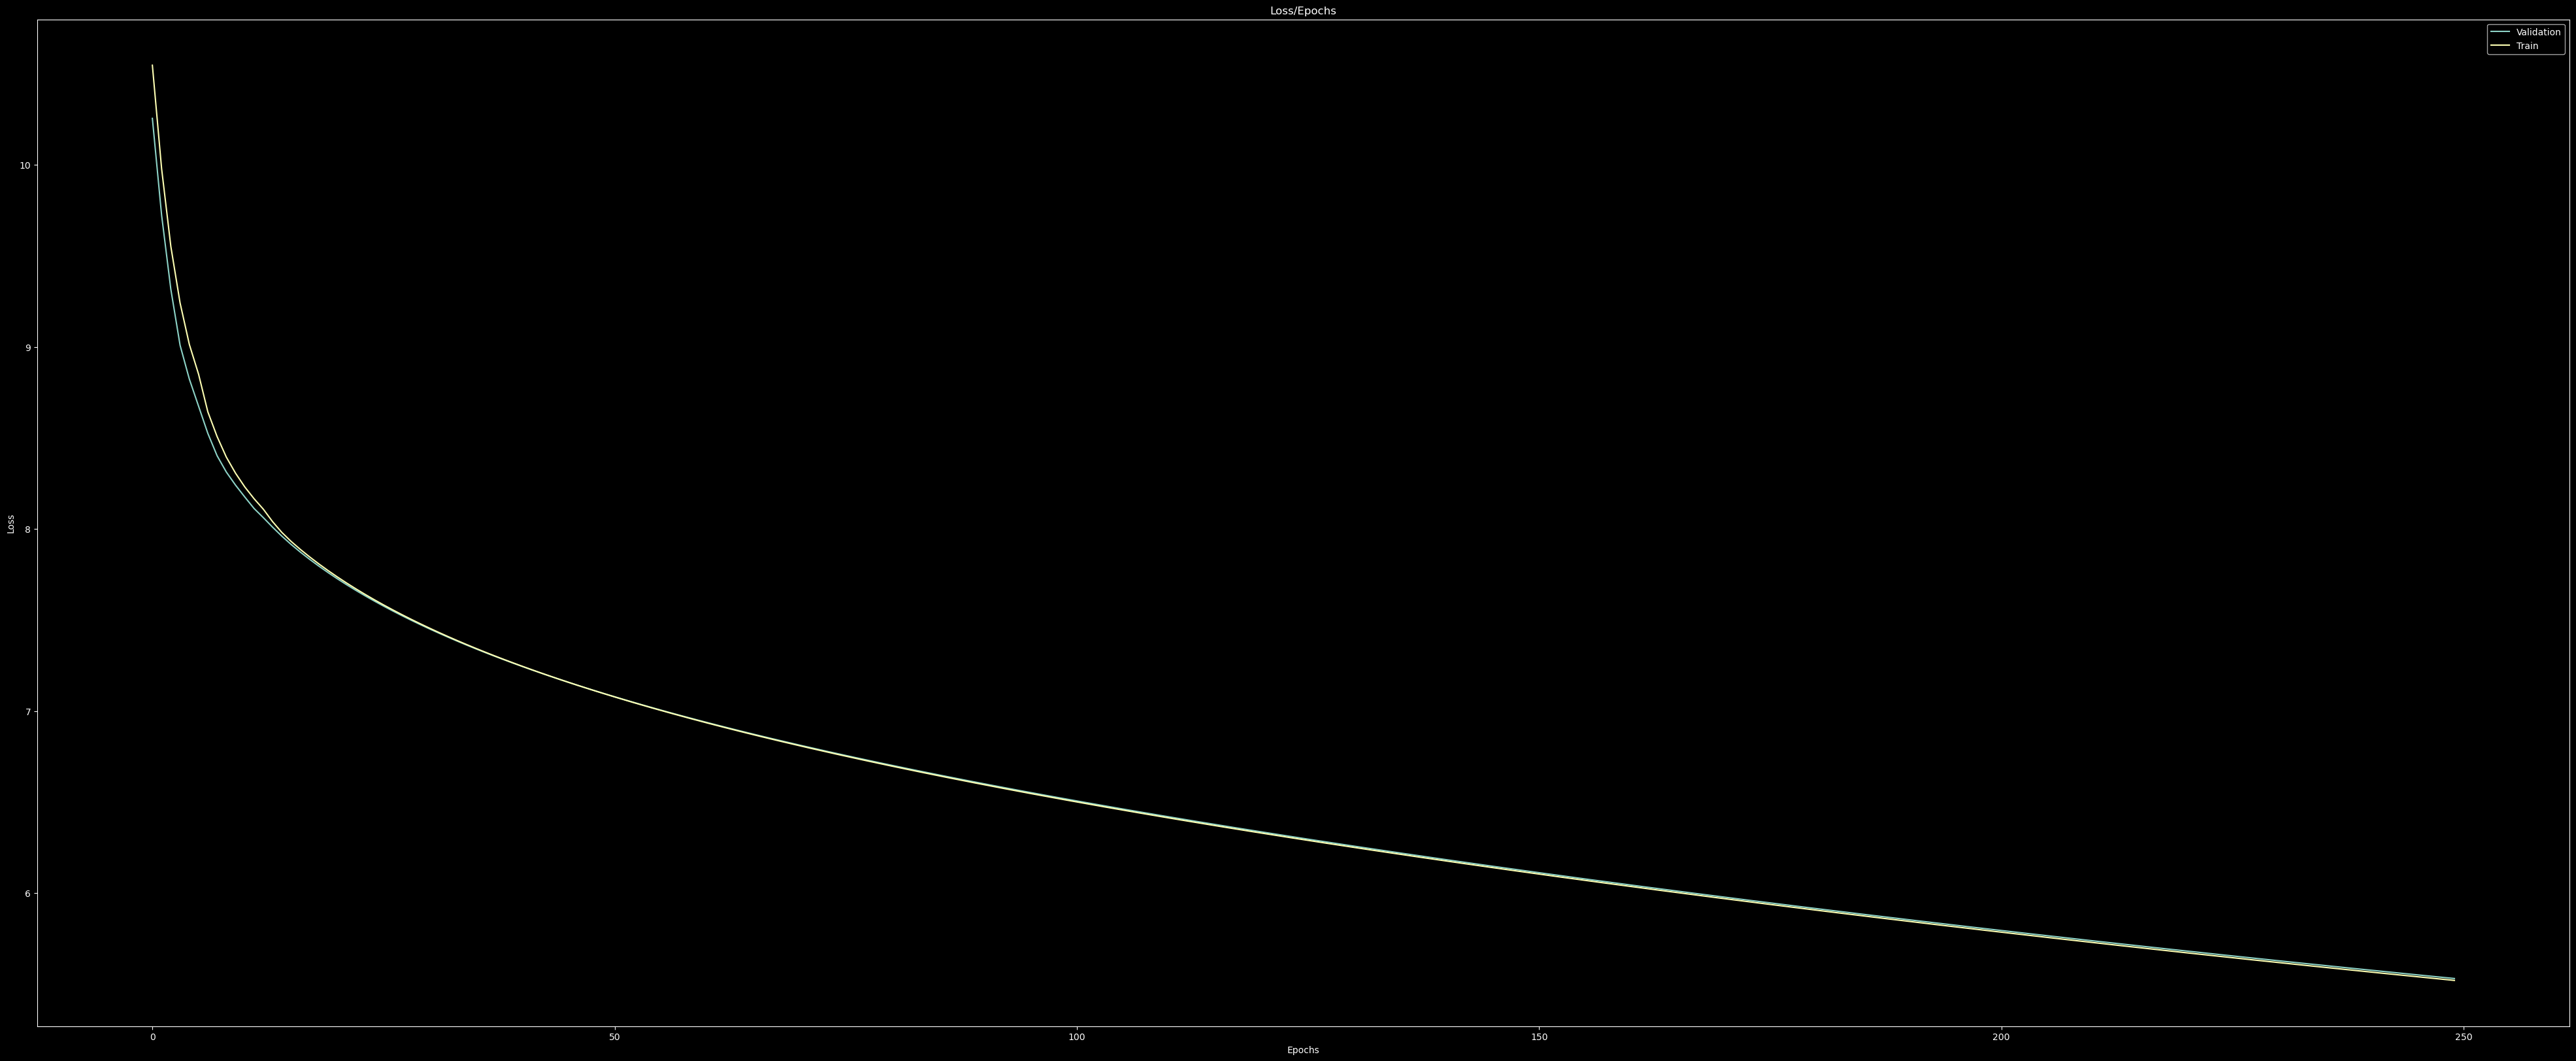

NN with 177 and <function tanh at 0x7e1f012cfeb0>
Last epoch train error 5.520864486694336
Last epoch validation error 5.531285762786865


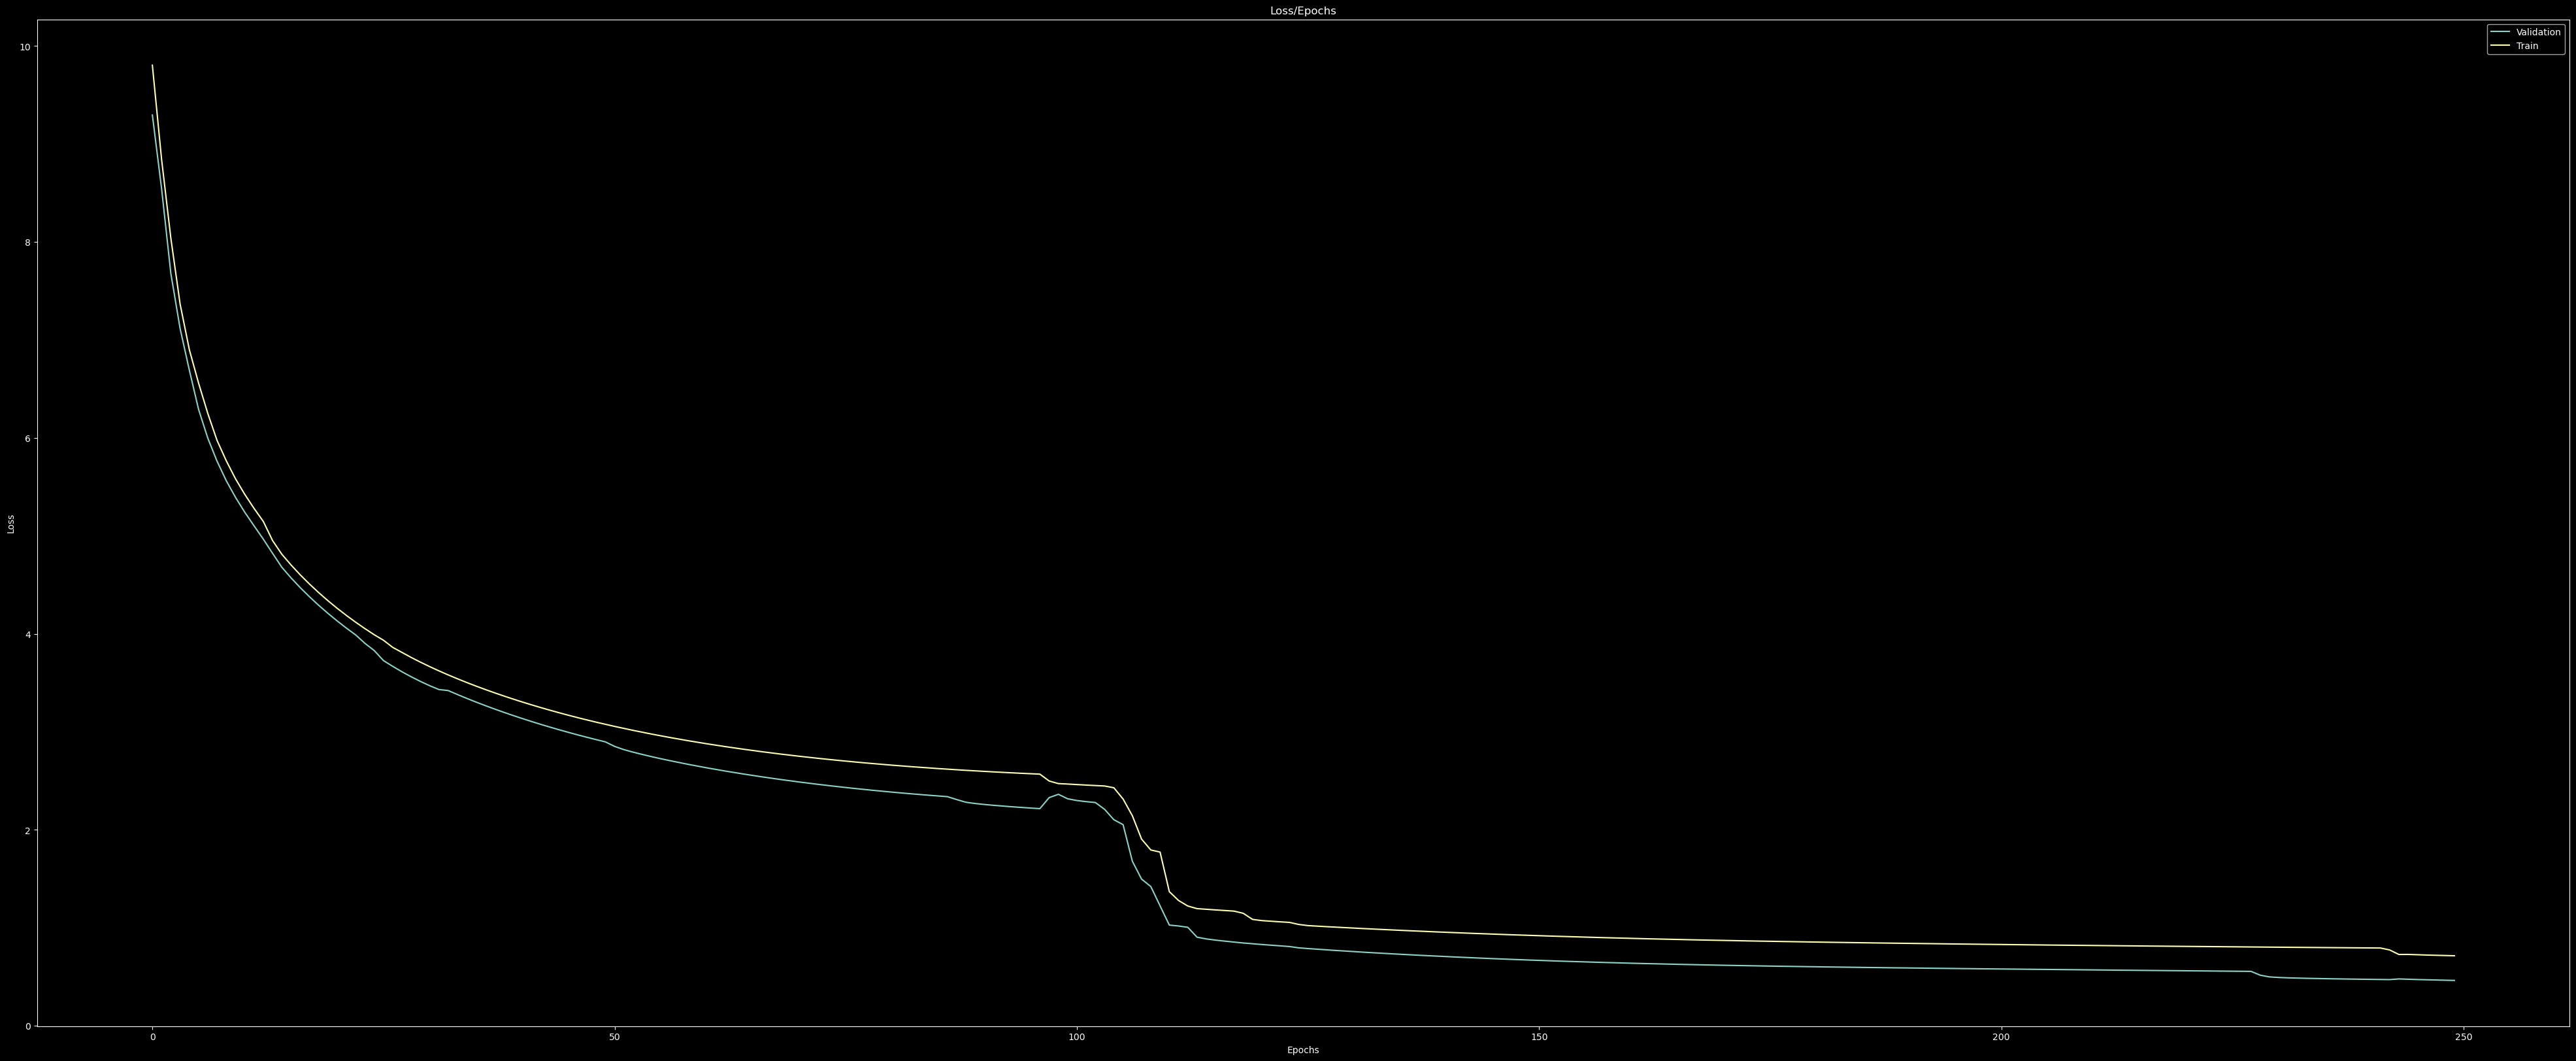

NN with 177 and <function leaky_relu at 0x7e1f013623b0>
Last epoch train error 0.7147785425186157
Last epoch validation error 0.4631081223487854


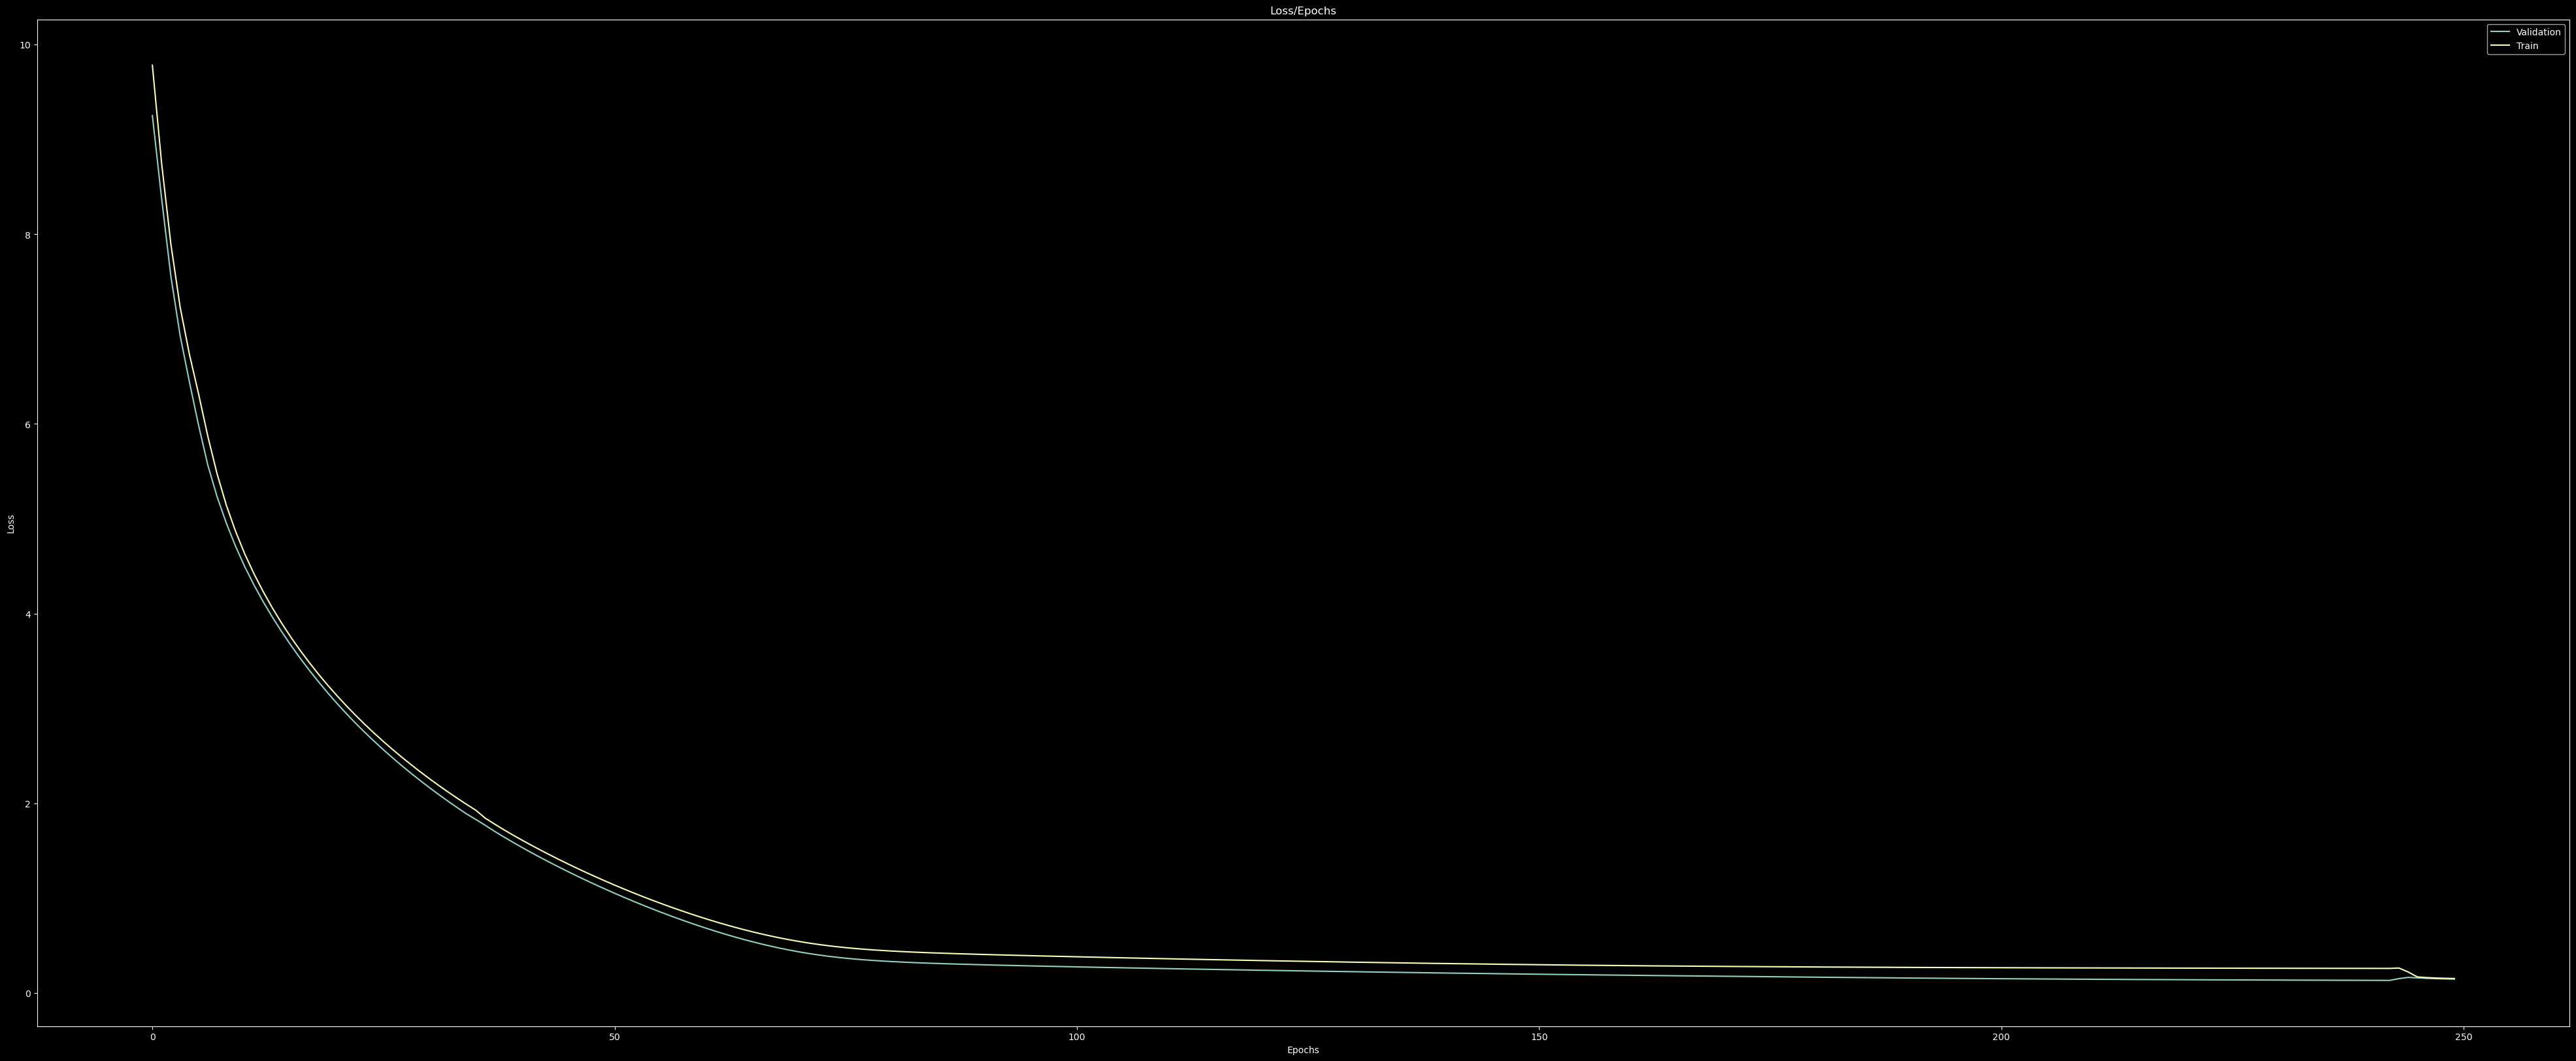

NN with 177 and <function relu at 0x7e1f01917d00>
Last epoch train error 0.15025916695594788
Last epoch validation error 0.14373722672462463


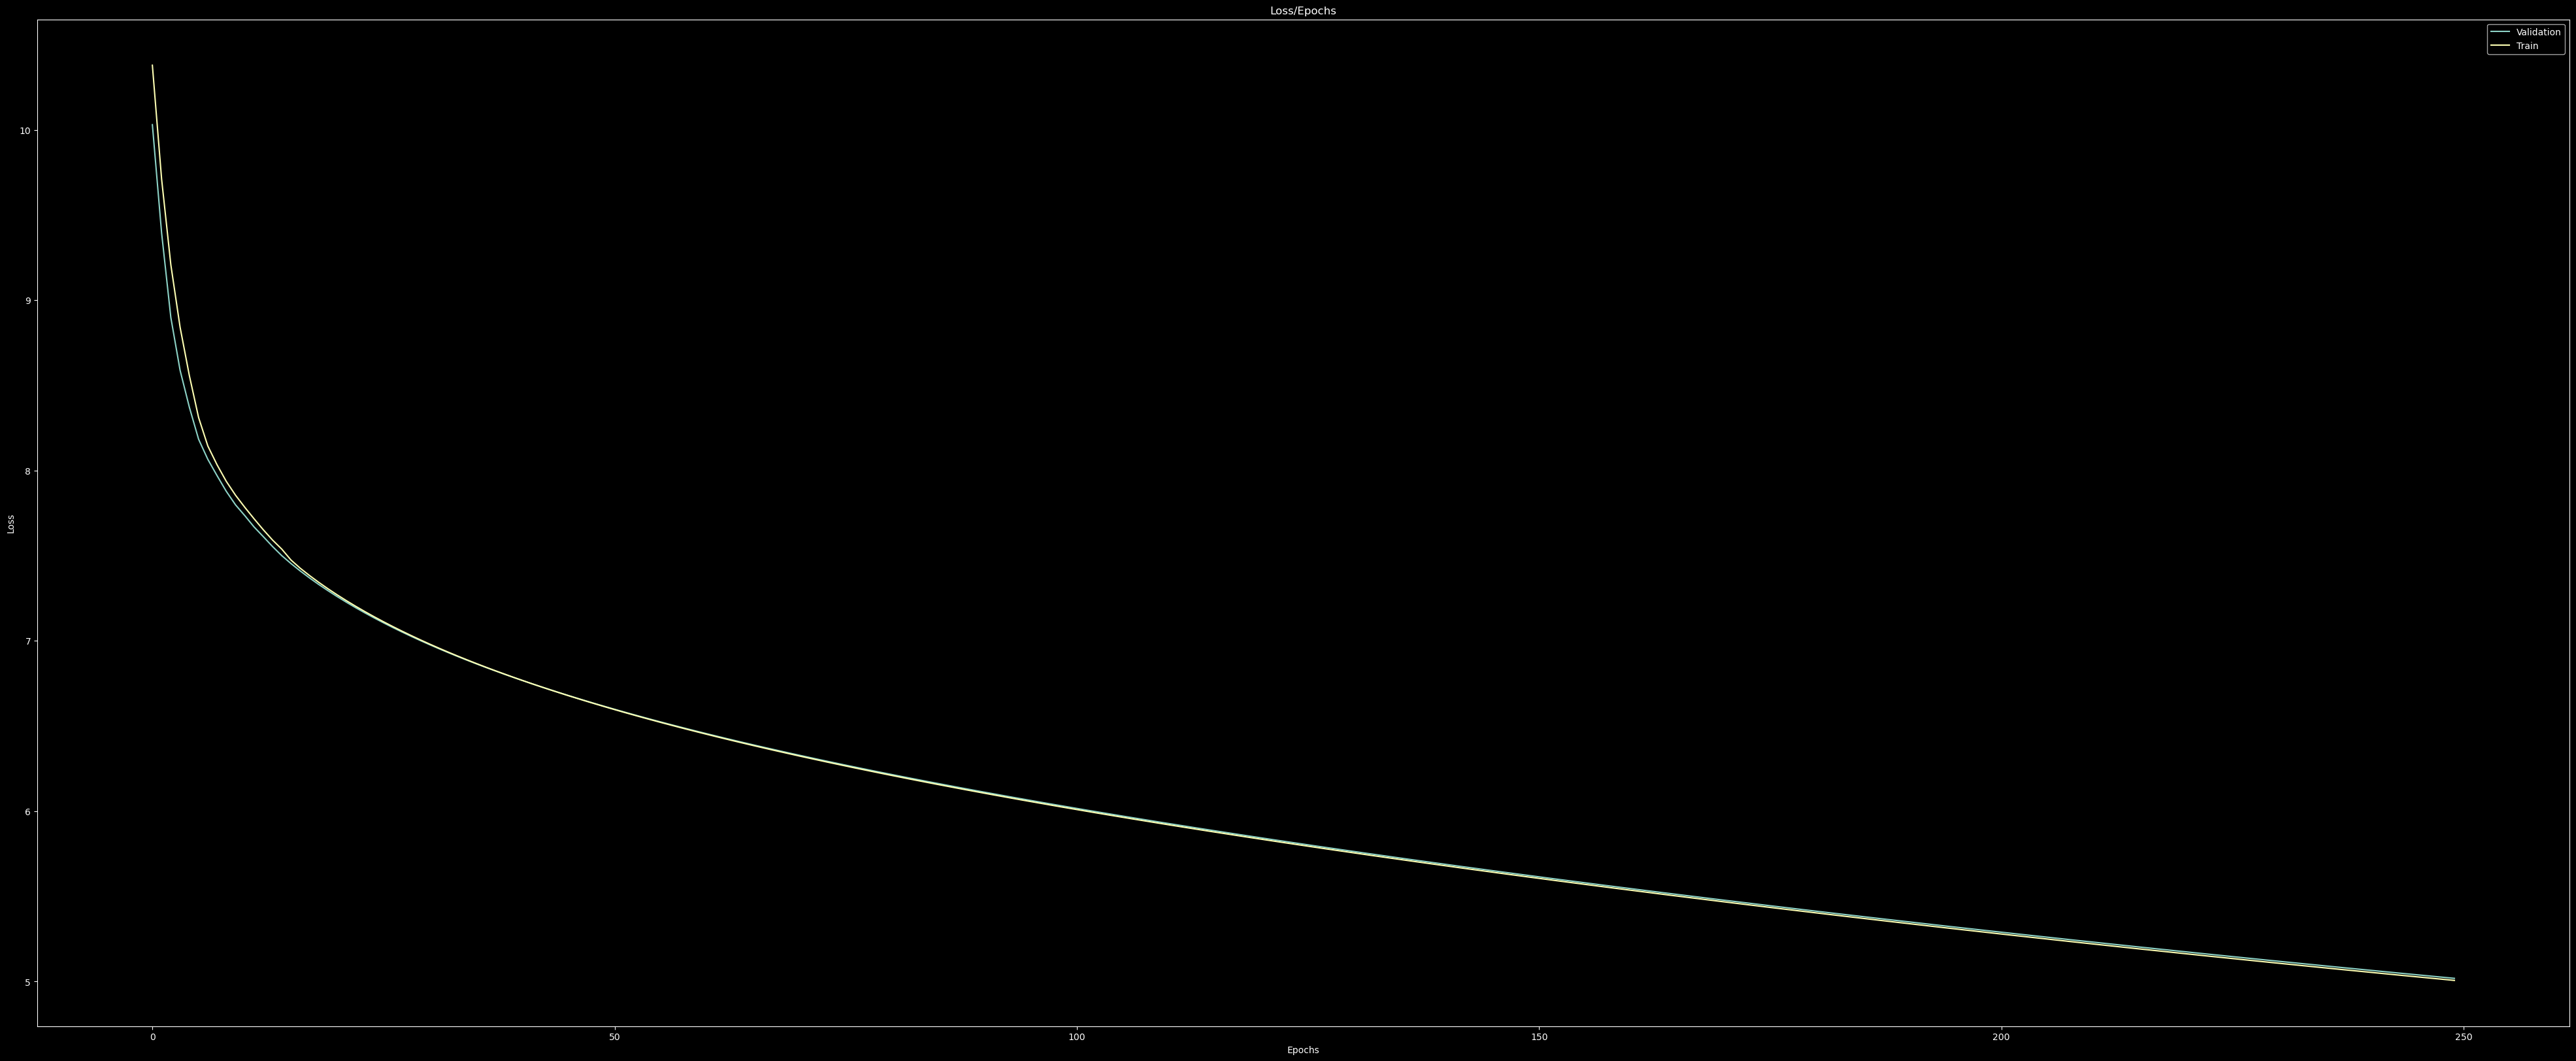

NN with 316 and <function tanh at 0x7e1f012cfeb0>
Last epoch train error 5.006684303283691
Last epoch validation error 5.018771171569824


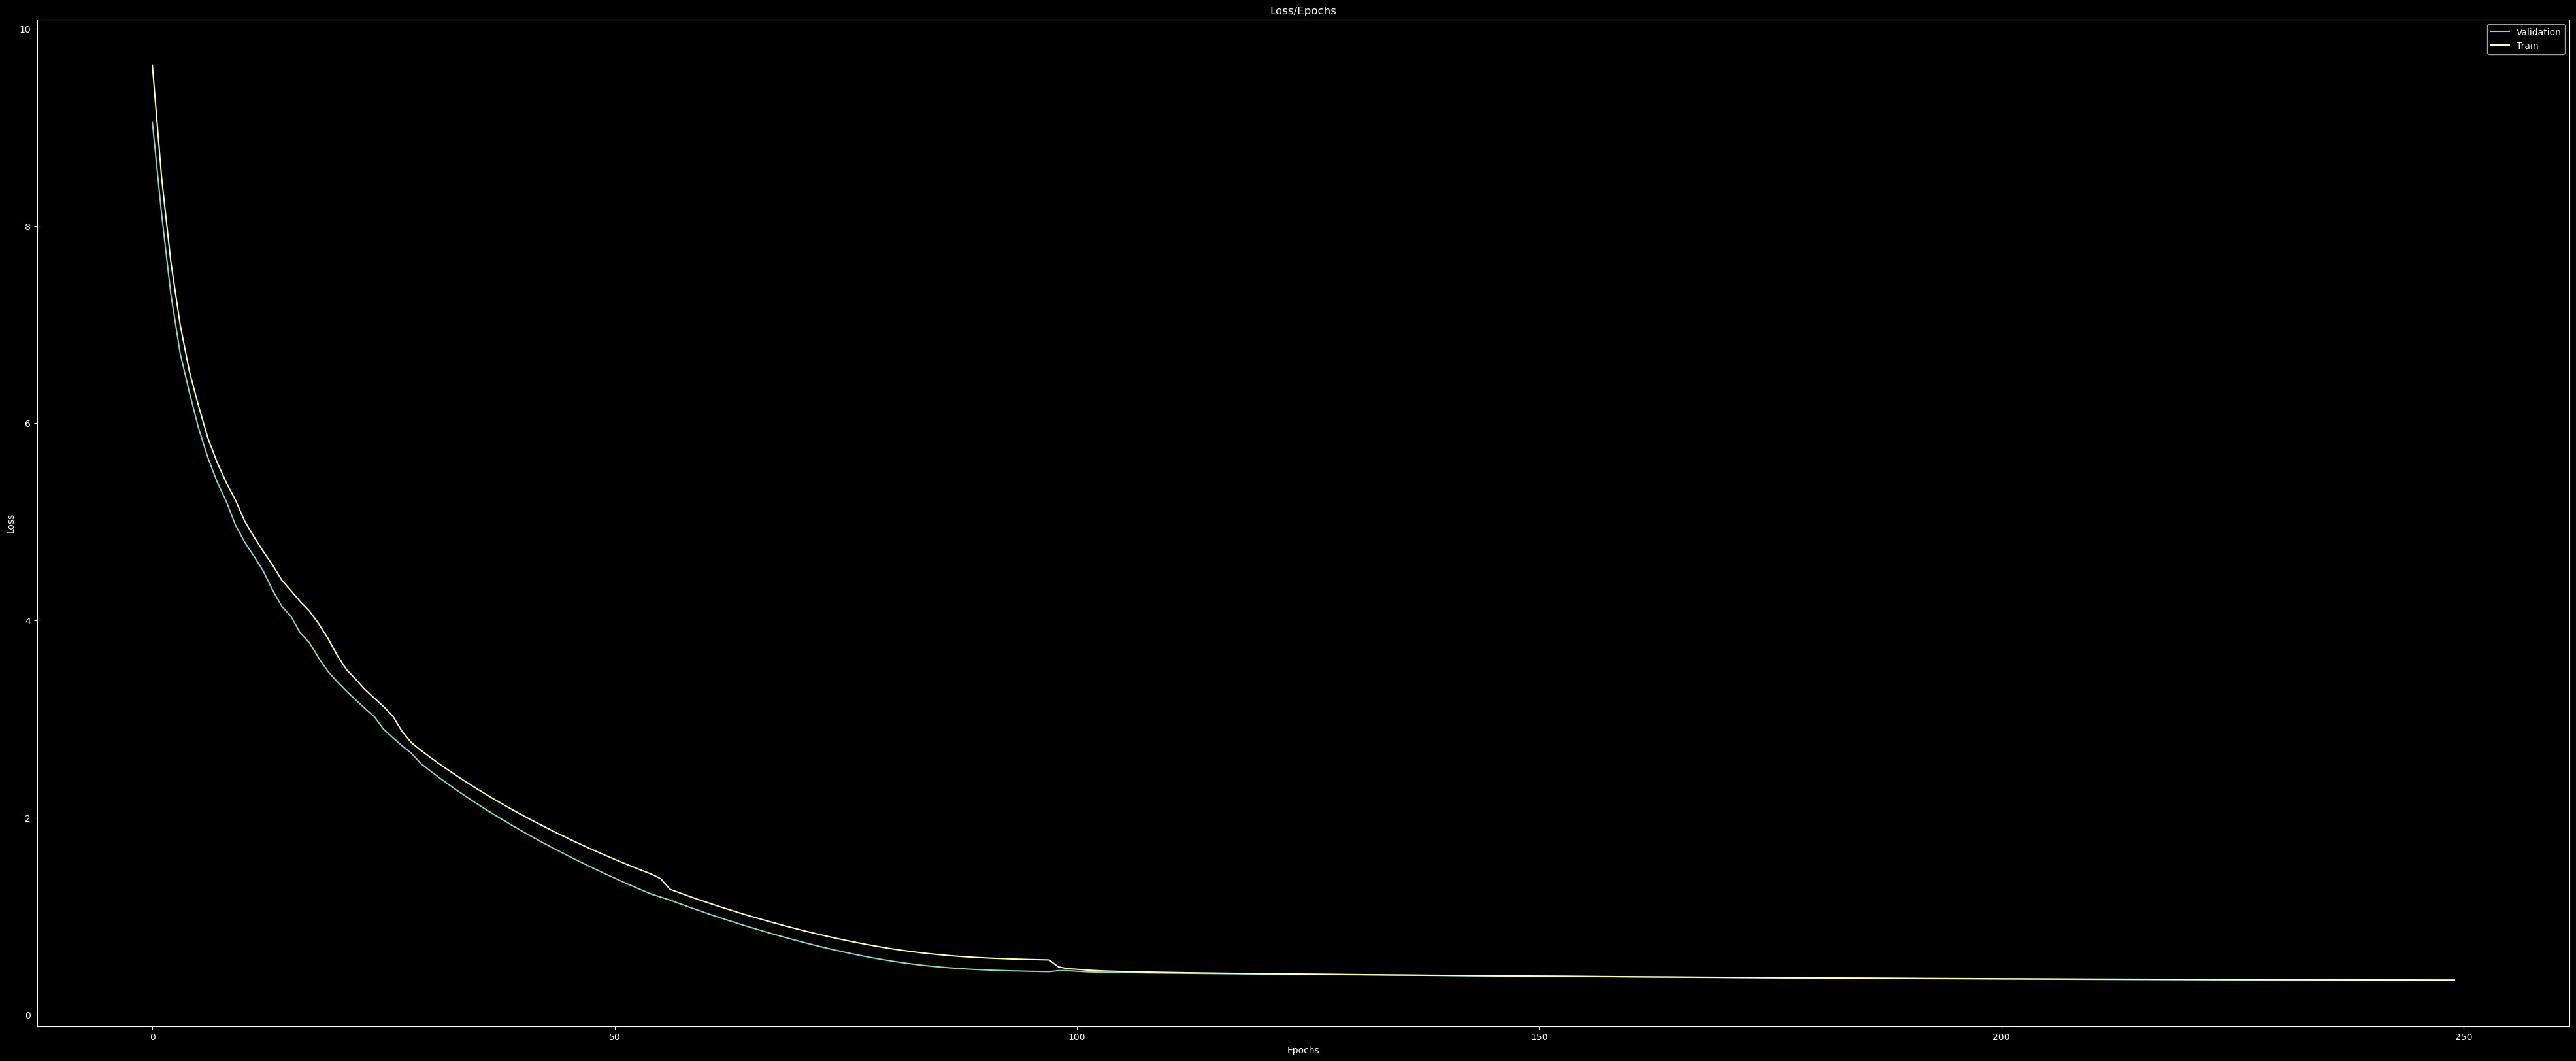

NN with 316 and <function leaky_relu at 0x7e1f013623b0>
Last epoch train error 0.3505549728870392
Last epoch validation error 0.34727784991264343


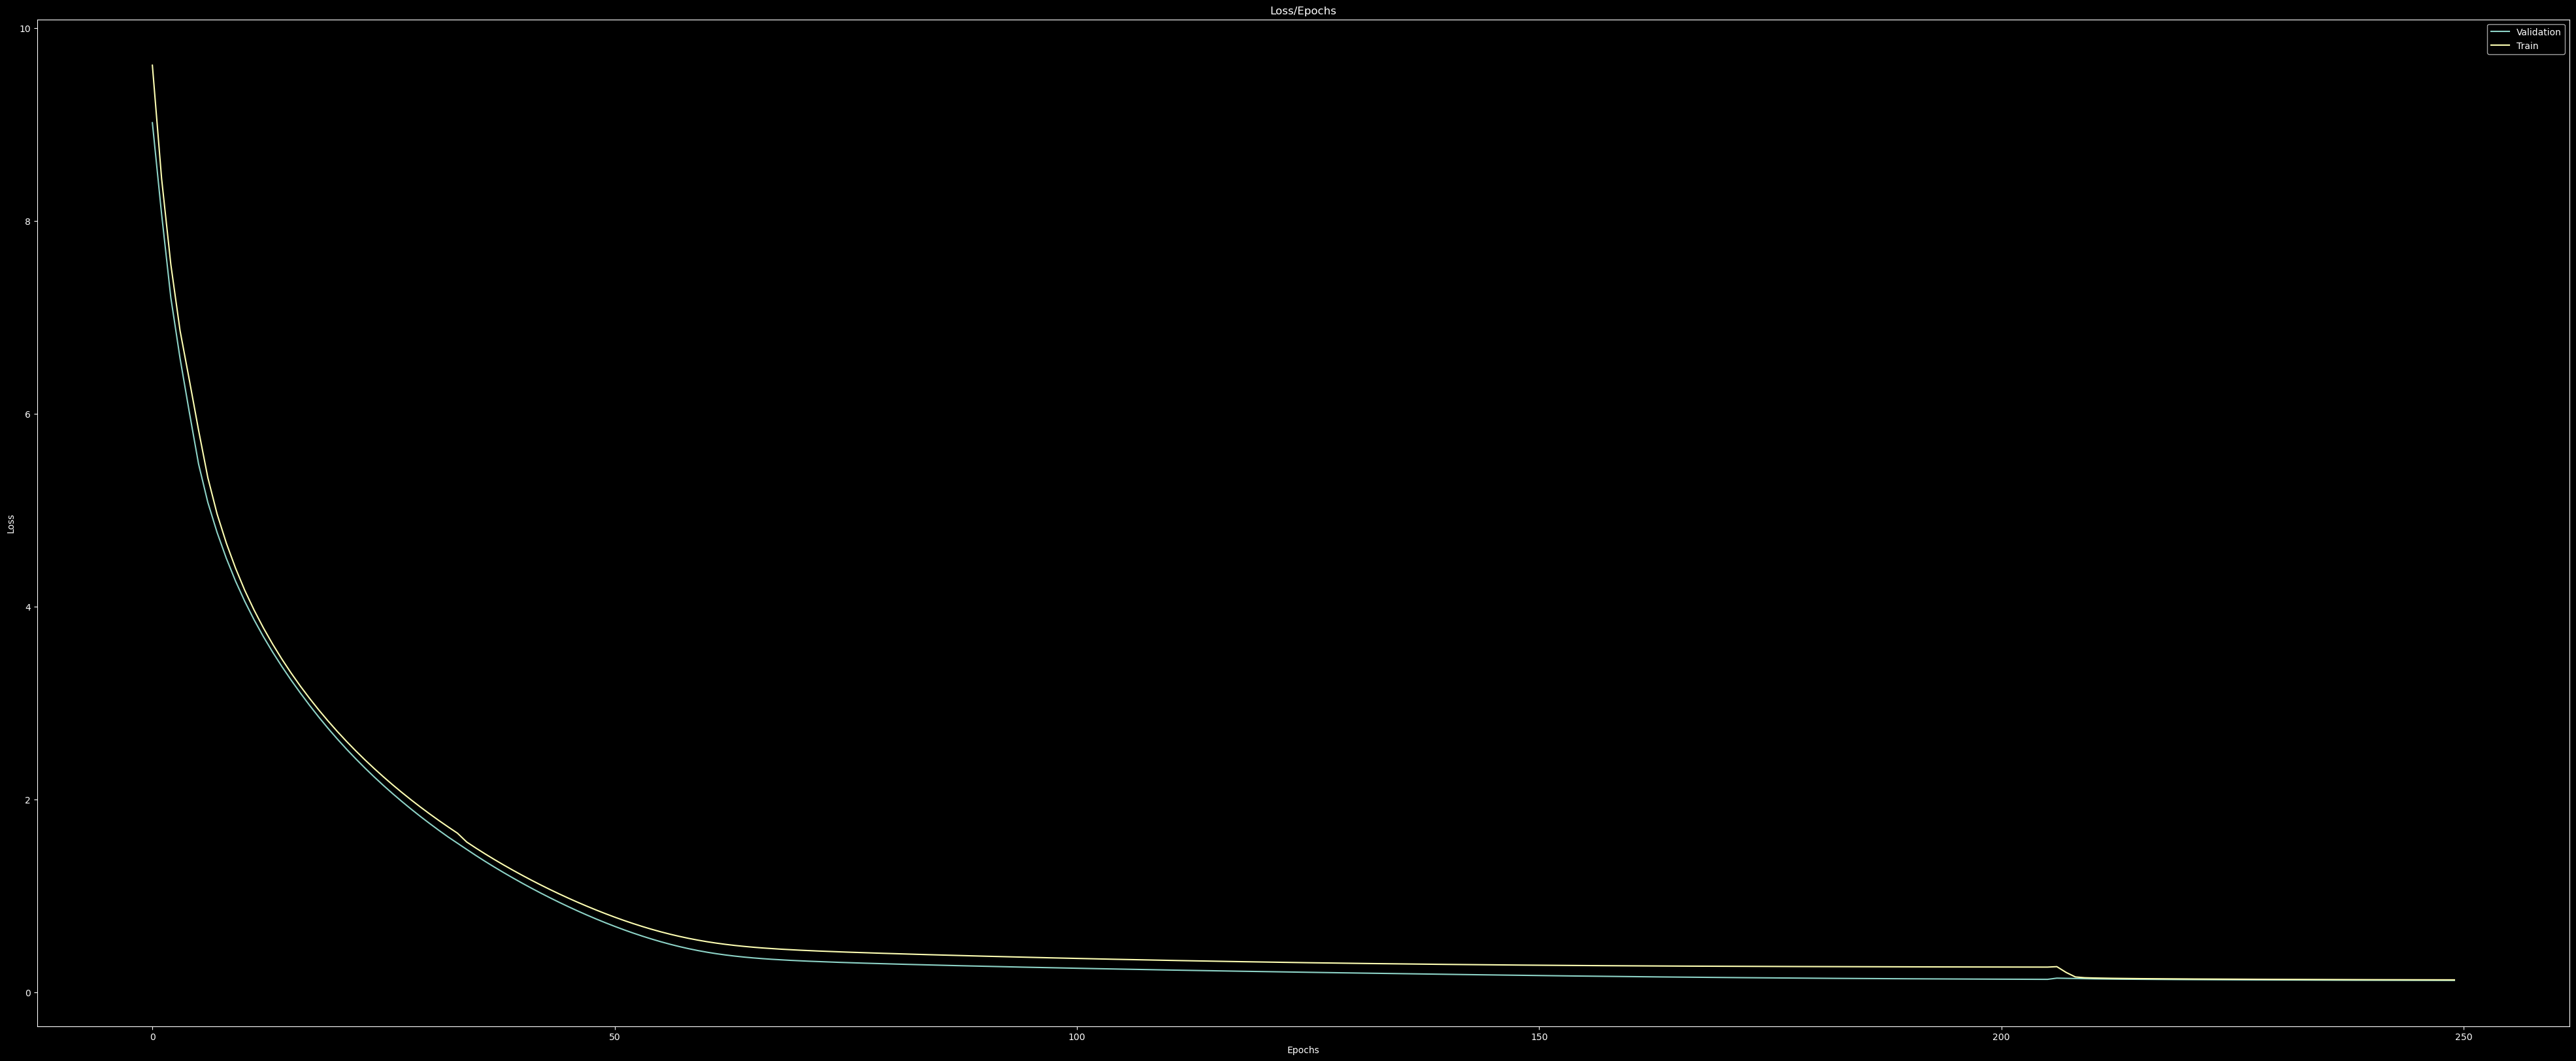

NN with 316 and <function relu at 0x7e1f01917d00>
Last epoch train error 0.12659212946891785
Last epoch validation error 0.12087607383728027


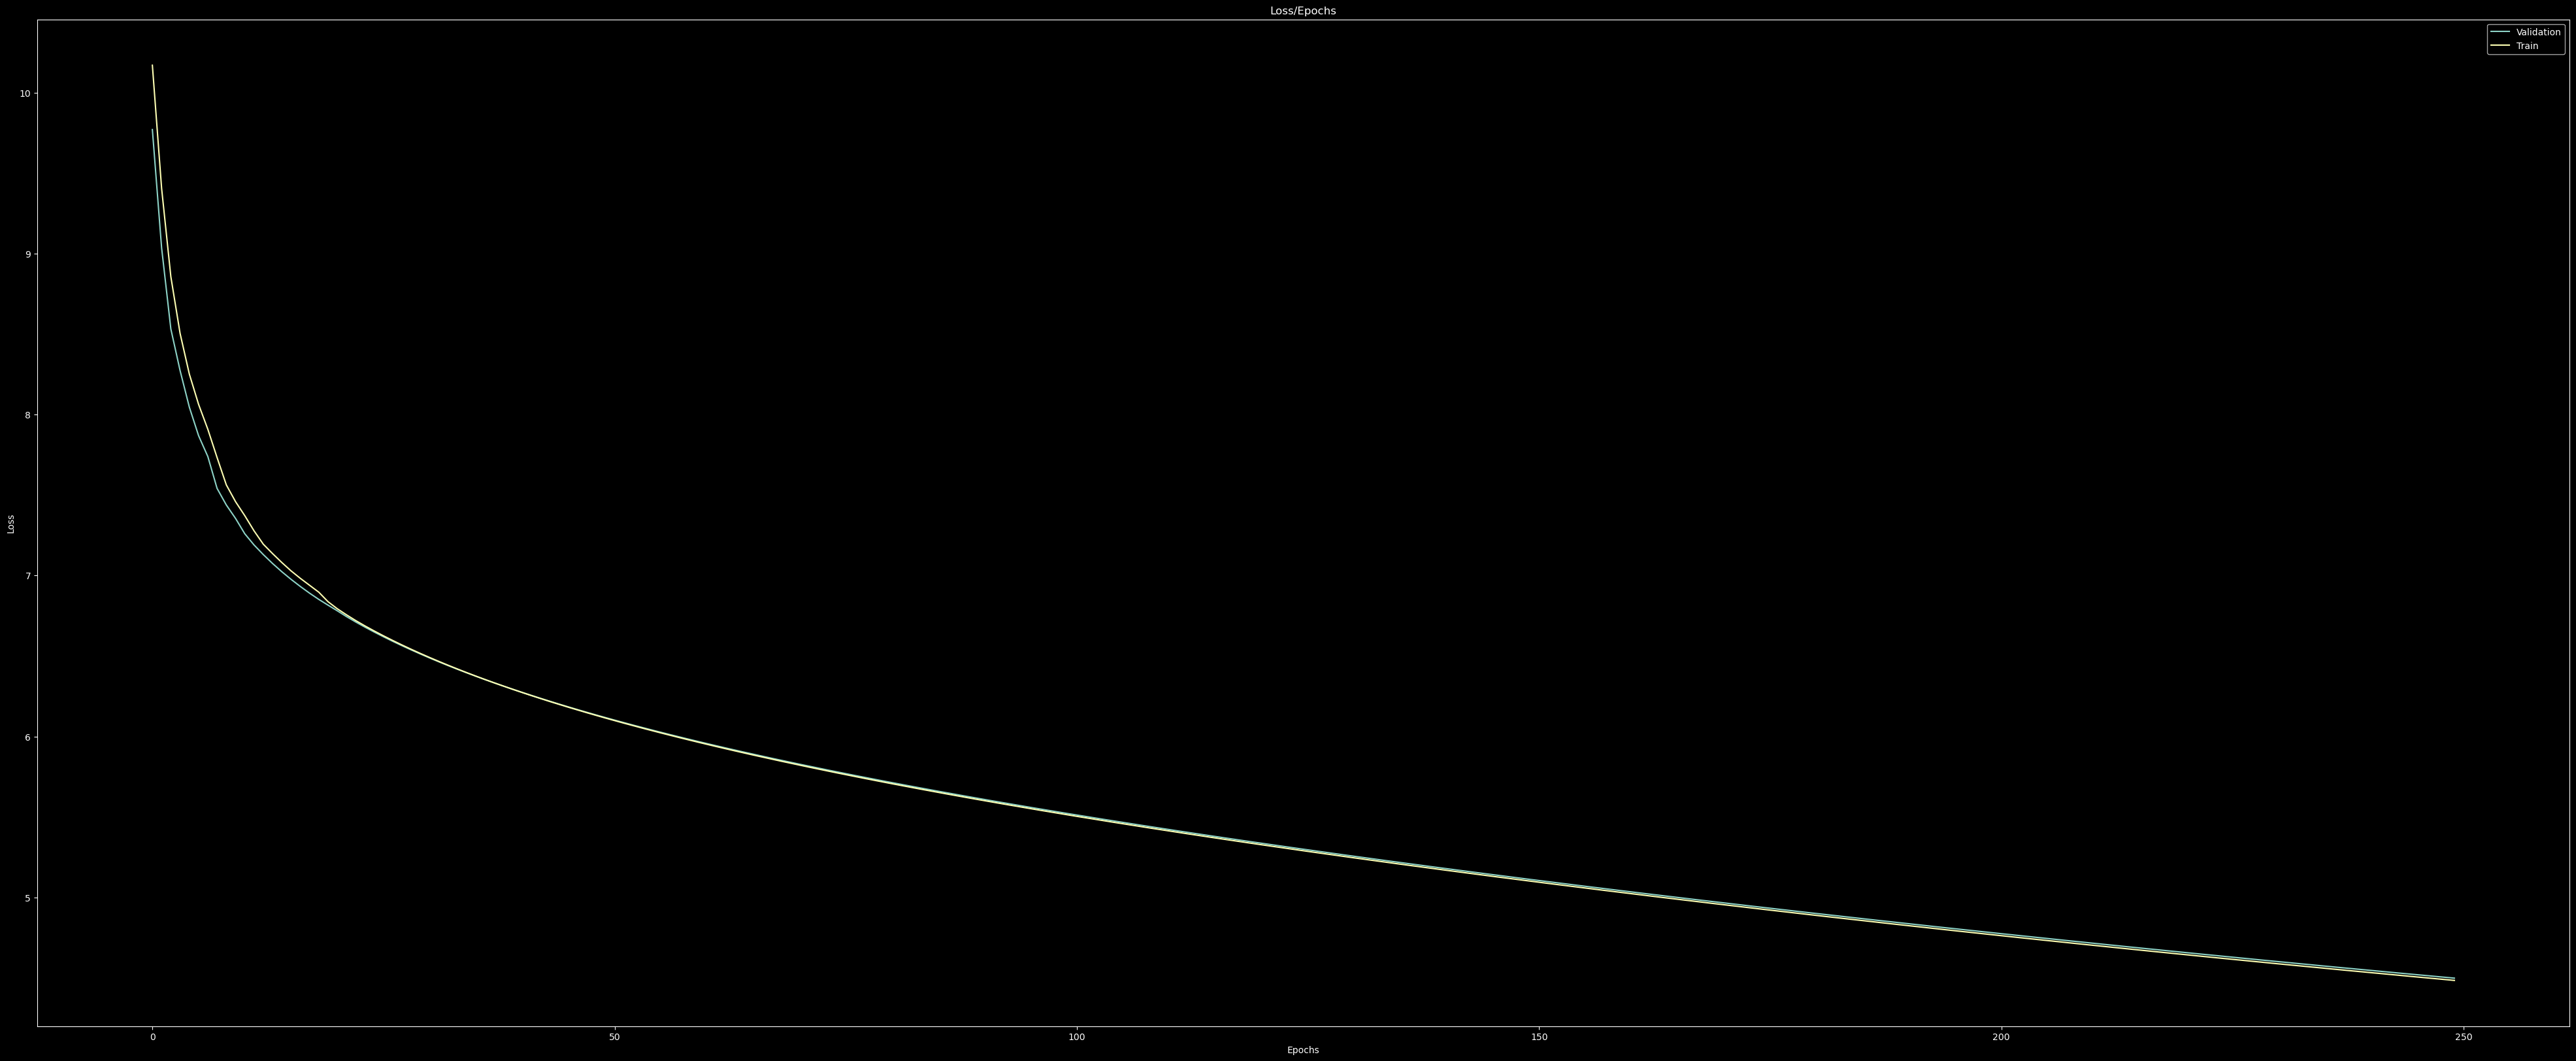

NN with 562 and <function tanh at 0x7e1f012cfeb0>
Last epoch train error 4.484704971313477
Last epoch validation error 4.4987874031066895


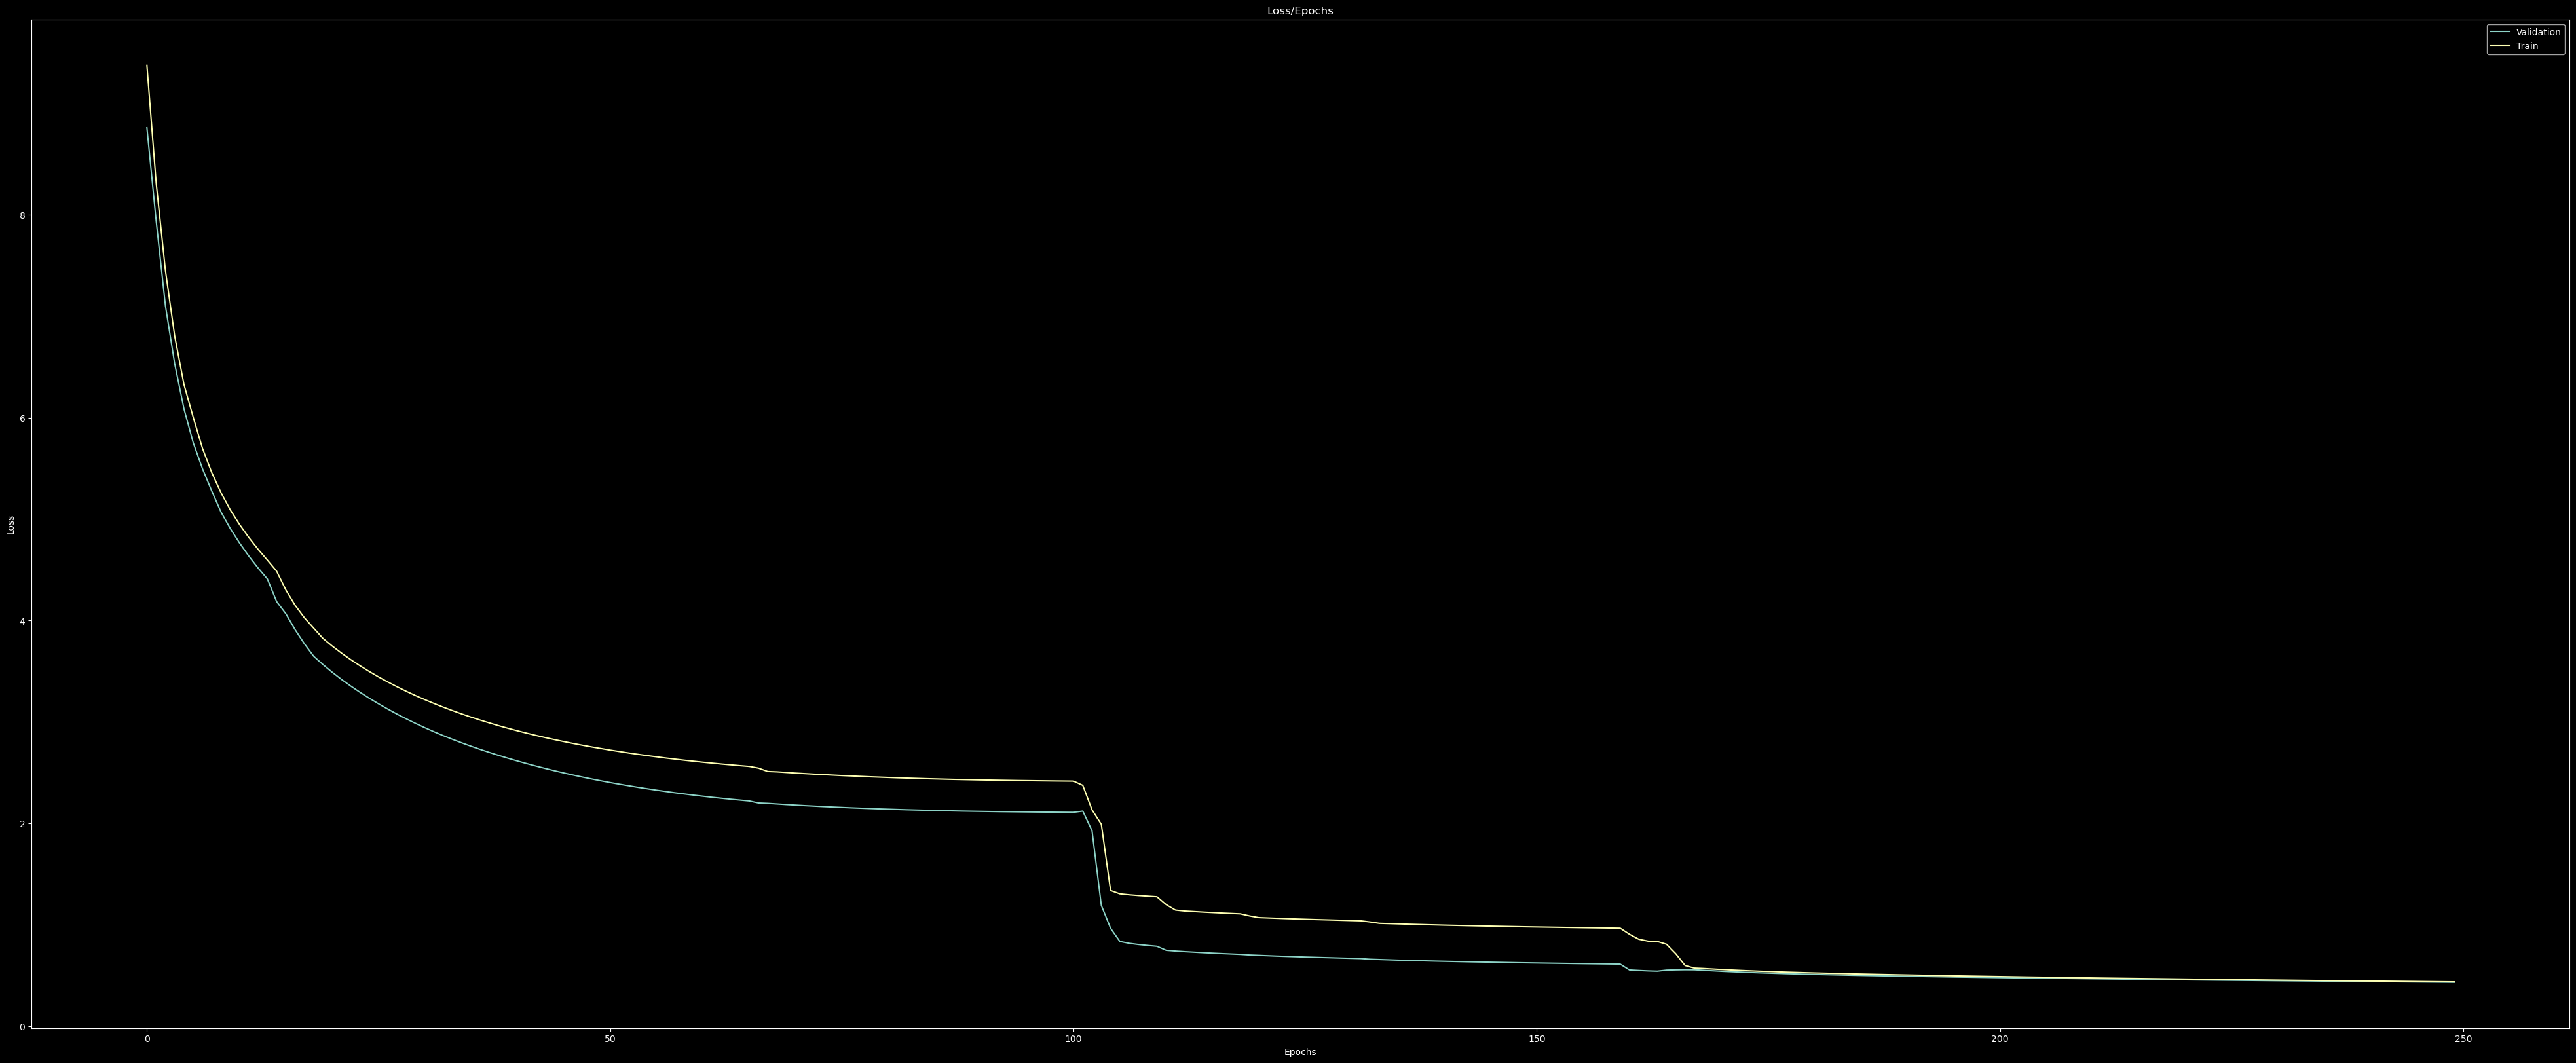

NN with 562 and <function leaky_relu at 0x7e1f013623b0>
Last epoch train error 0.43813037872314453
Last epoch validation error 0.43388959765434265


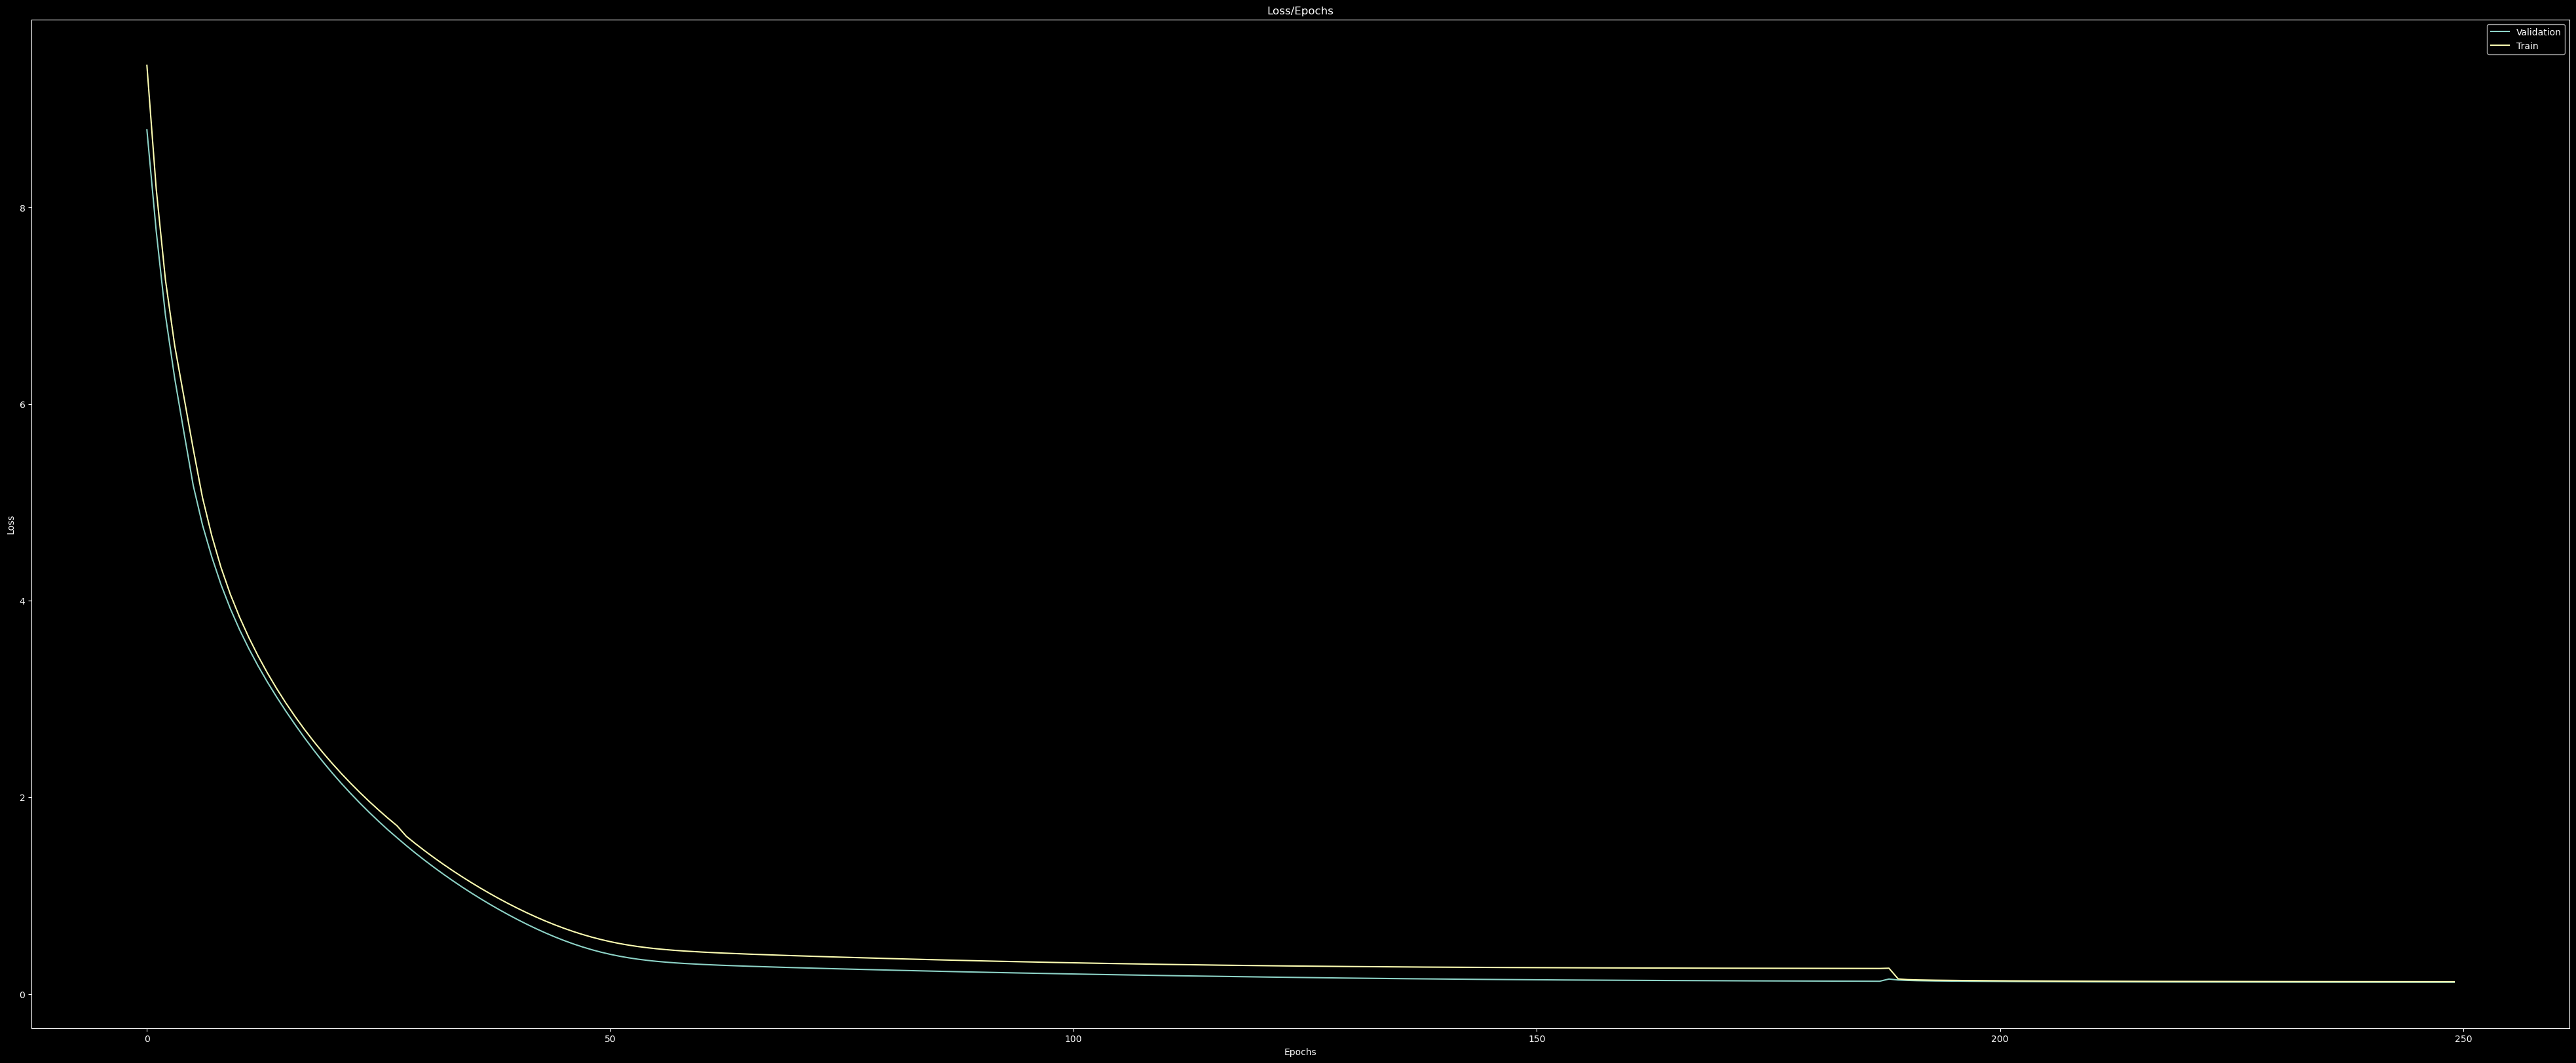

NN with 562 and <function relu at 0x7e1f01917d00>
Last epoch train error 0.12439220398664474
Last epoch validation error 0.11908295005559921


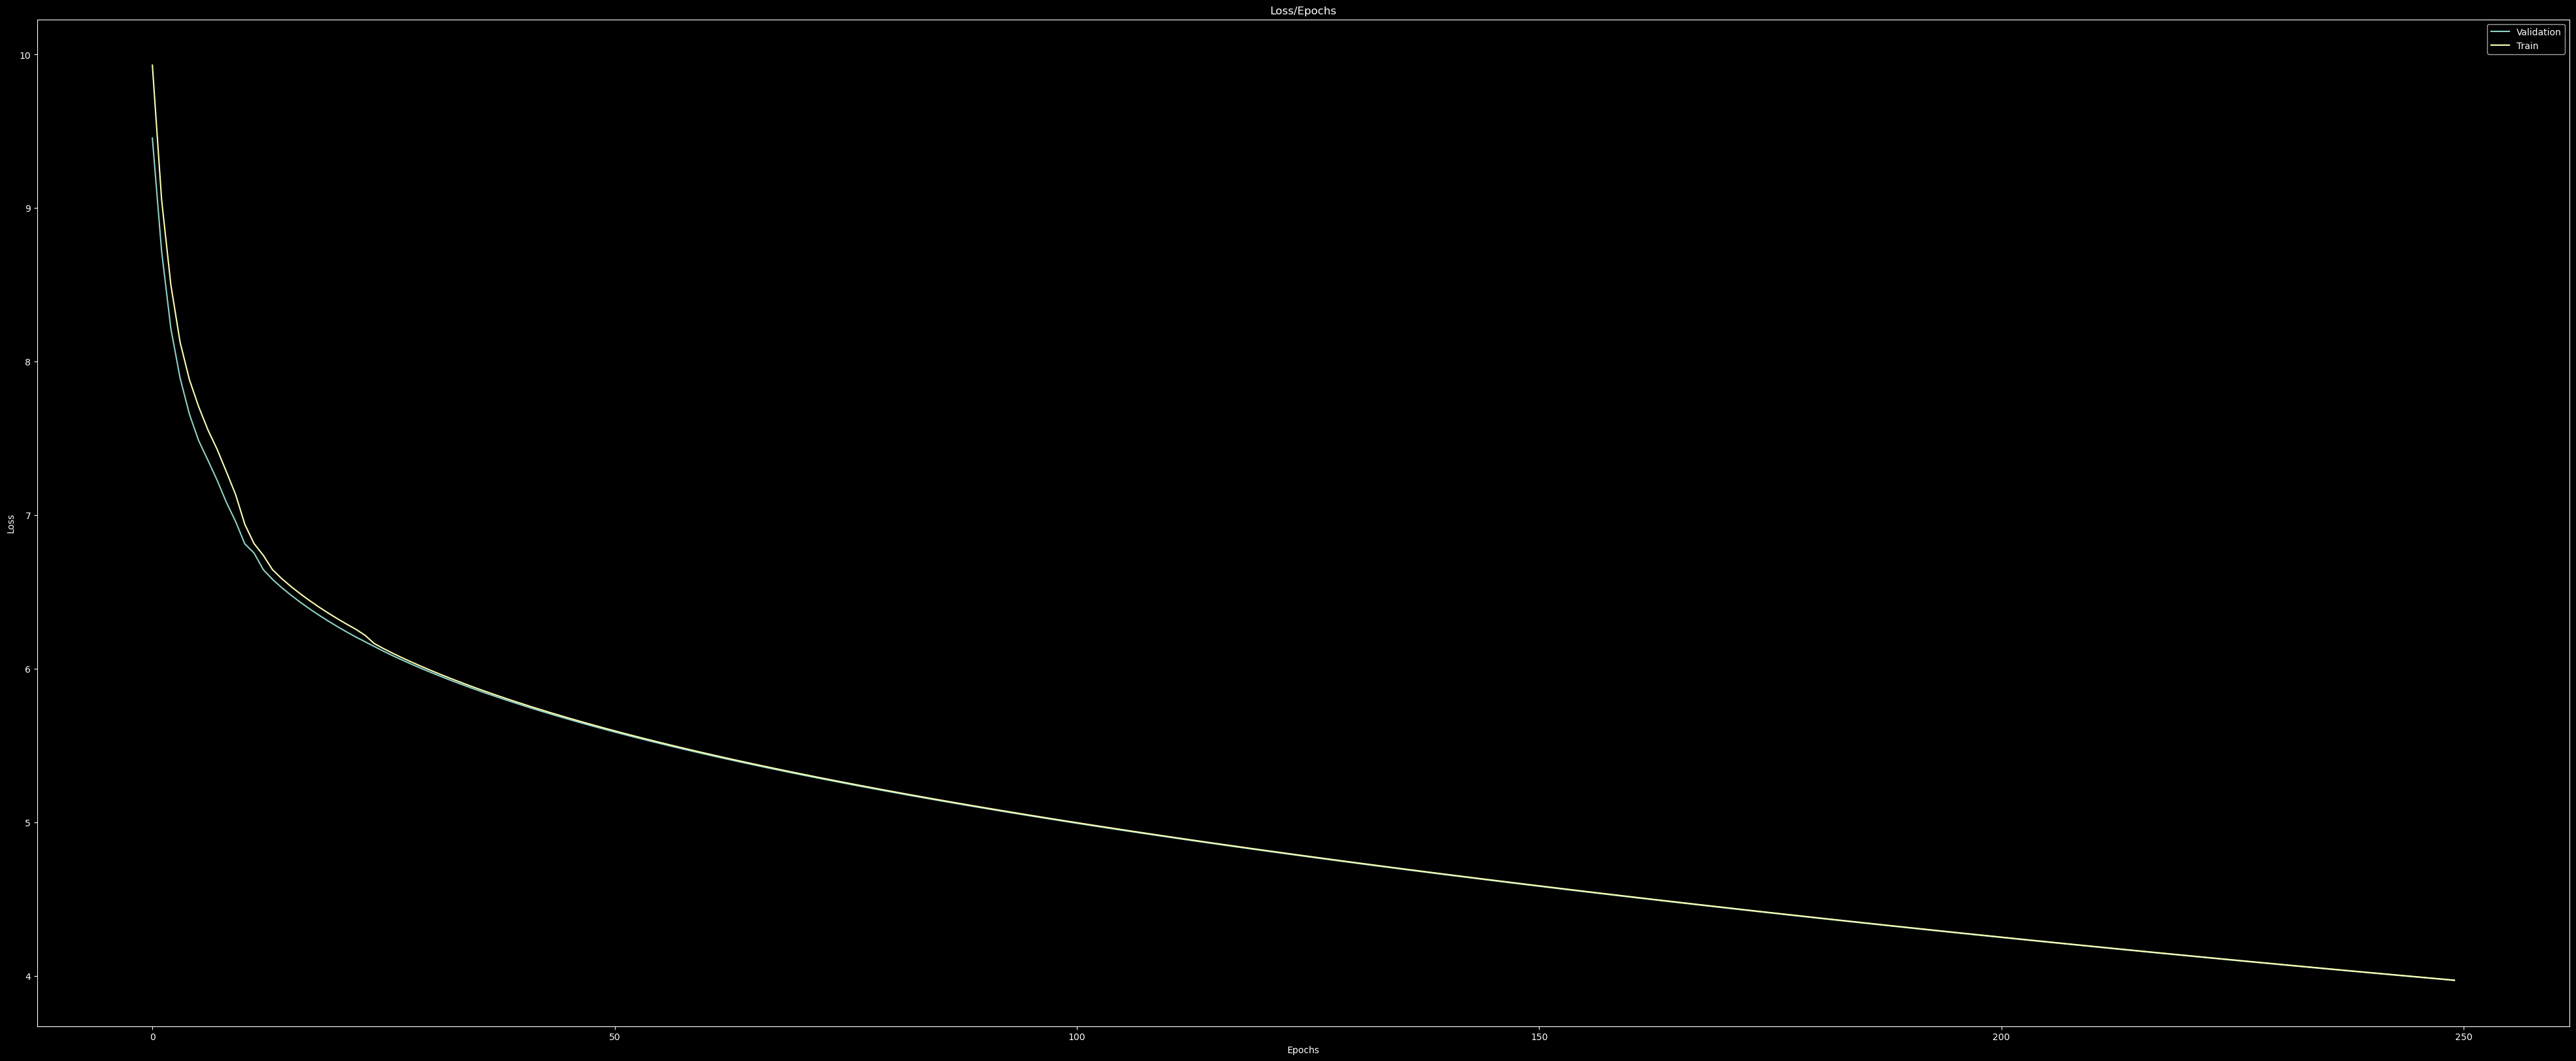

NN with 1000 and <function tanh at 0x7e1f012cfeb0>
Last epoch train error 3.9724693298339844
Last epoch validation error 3.9707090854644775


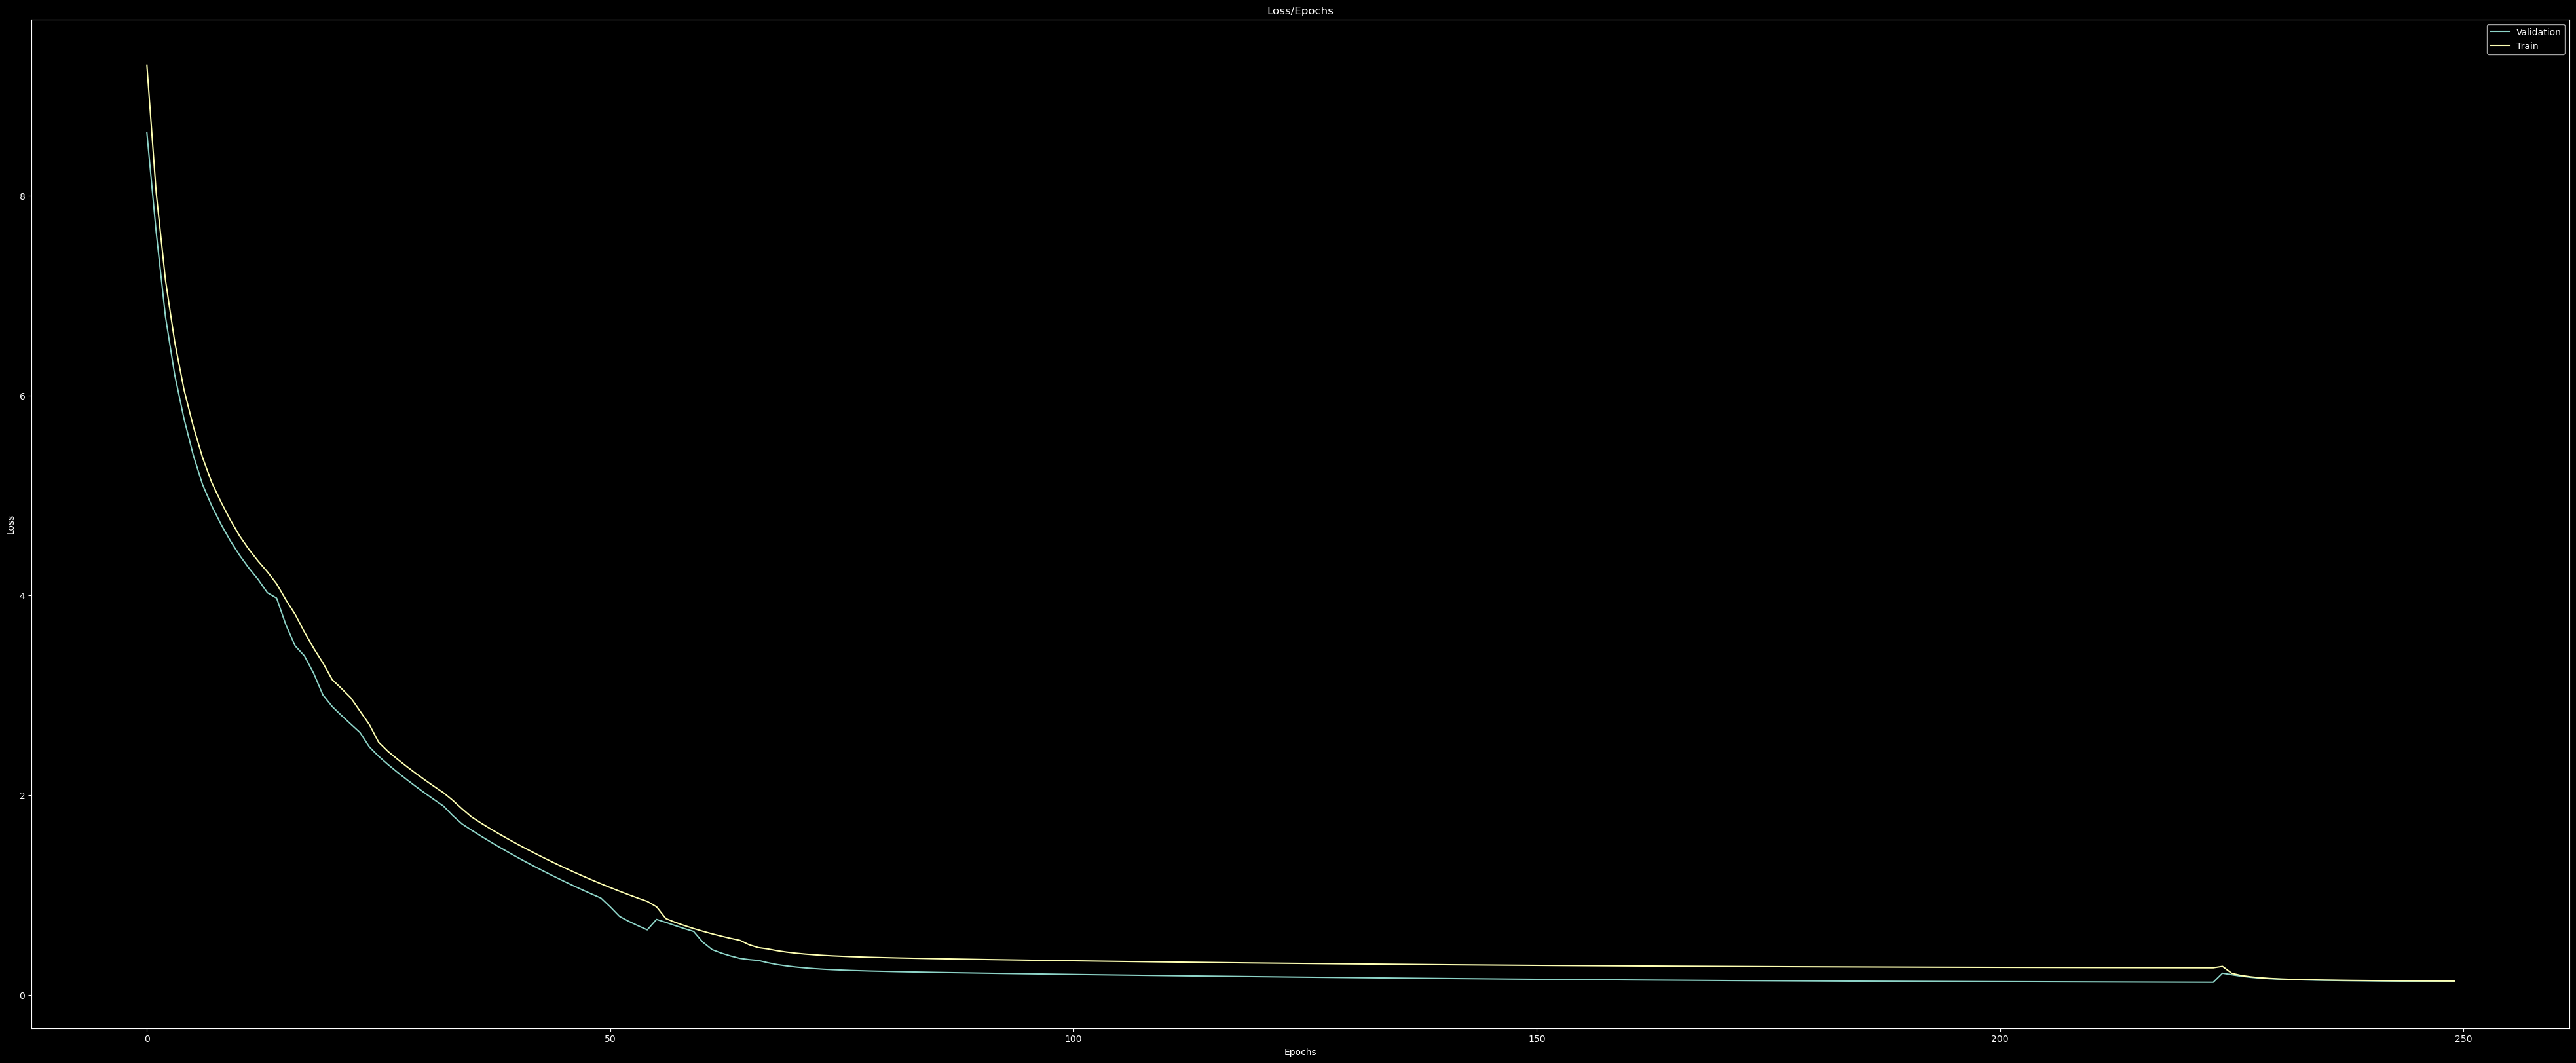

NN with 1000 and <function leaky_relu at 0x7e1f013623b0>
Last epoch train error 0.14108046889305115
Last epoch validation error 0.1363876461982727


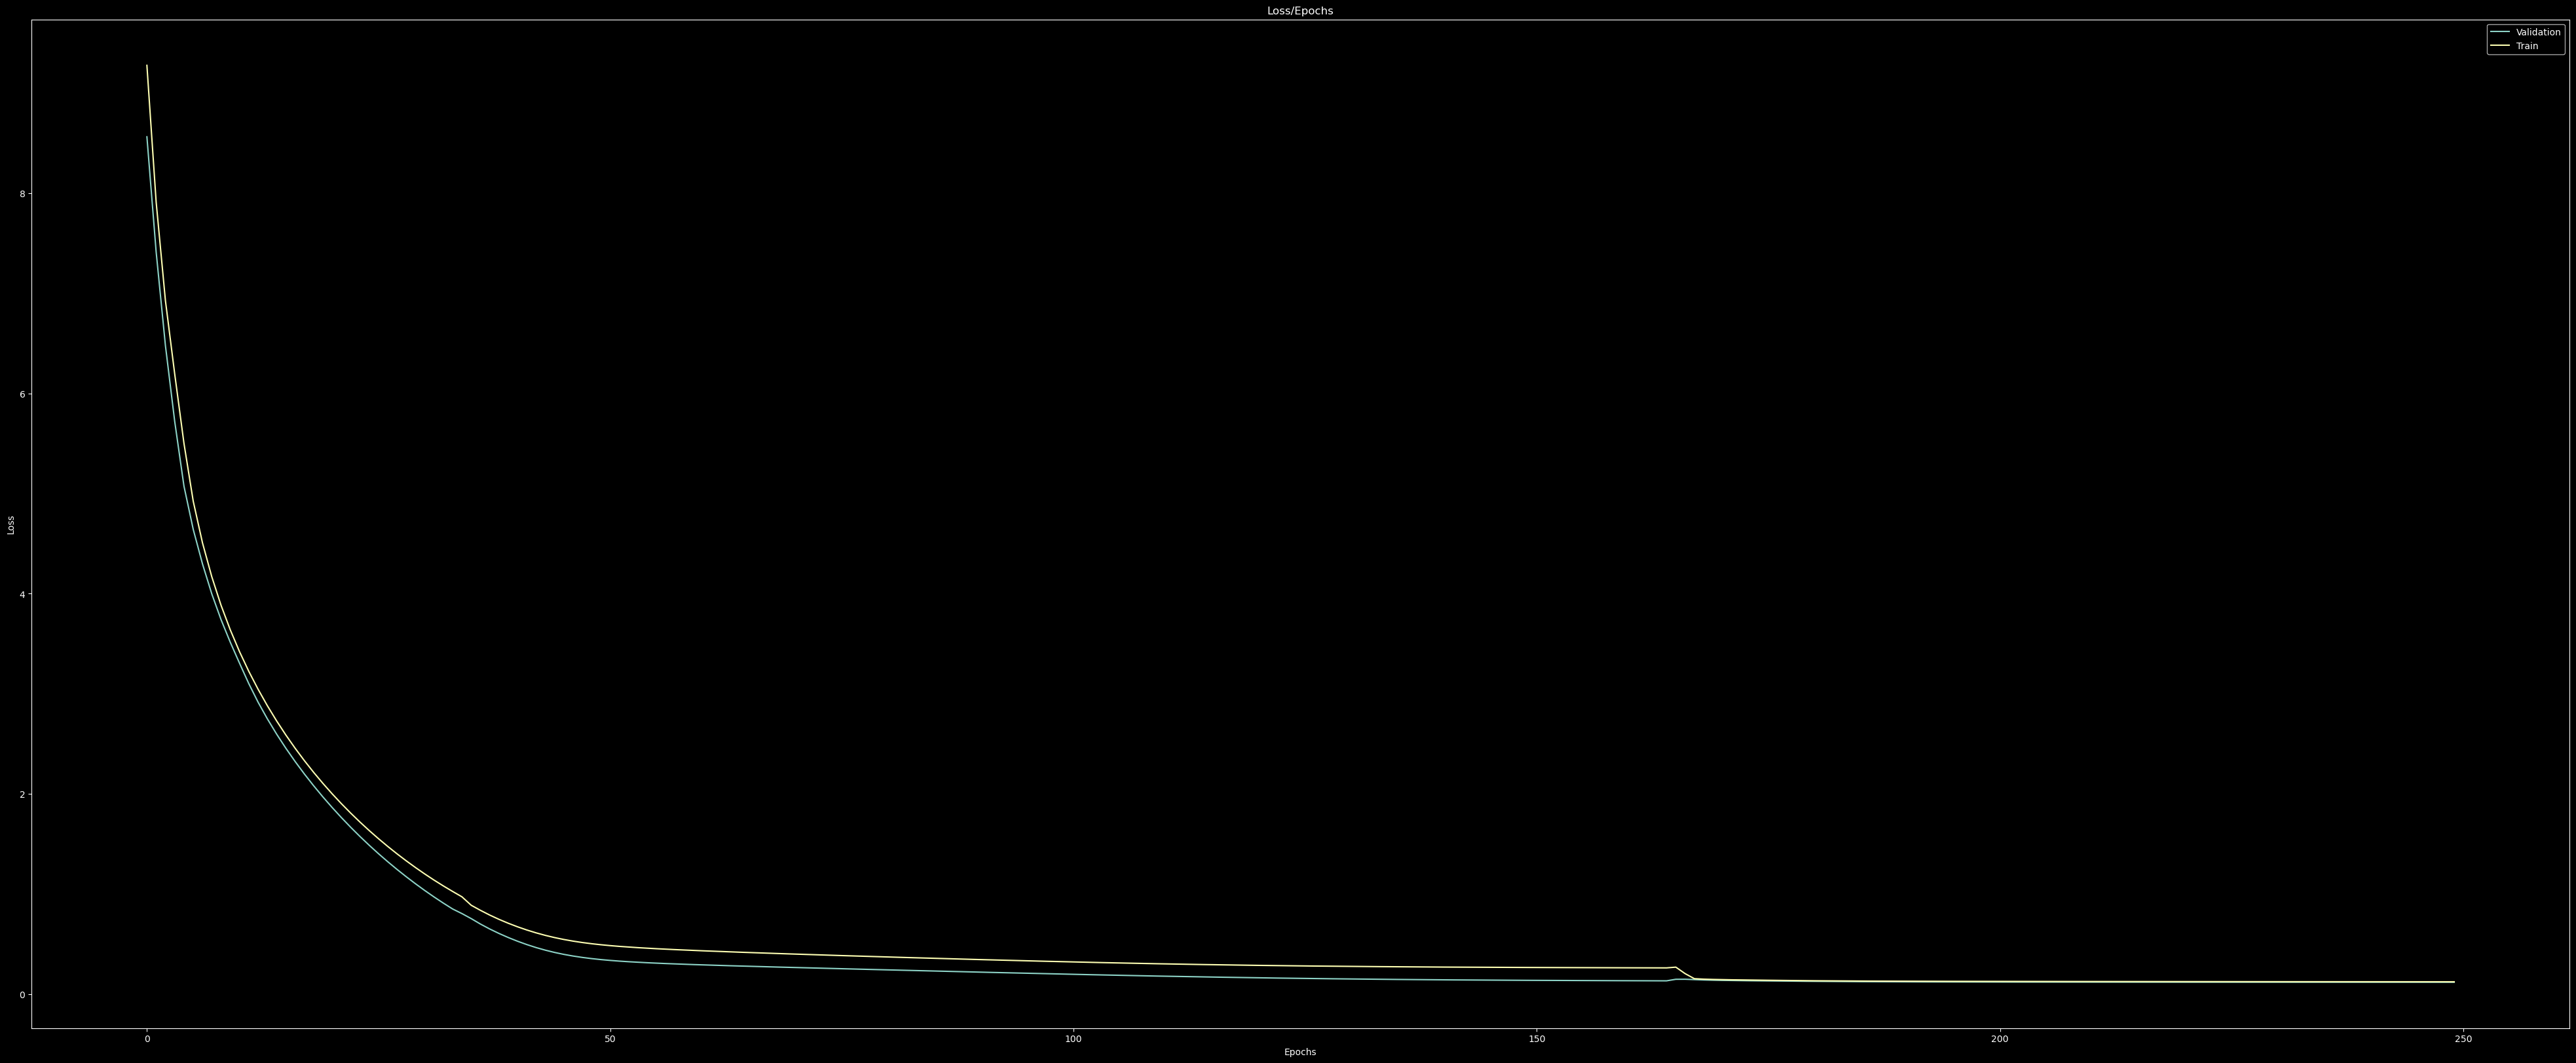

NN with 1000 and <function relu at 0x7e1f01917d00>
Last epoch train error 0.12363514304161072
Last epoch validation error 0.11878561228513718


In [138]:
param_space_neurons=np.logspace(start=2,stop=3,base=10,num=5,dtype=np.int64)
param_space_activations=[
    activations.tanh,
    activations.leaky_relu,
    activations.relu
]

for neurons in param_space_neurons:
    for activation in param_space_activations: 
        nn = models.Sequential(
            [
                layers.Input((X_tr_proc.shape[1],)),
                layers.Dense(
                    1000,
                    activation=activations.leaky_relu,
                    kernel_initializer=GlorotUniform(0),
                    kernel_constraint=layer_constraints.NonNeg(),
                ),
                layers.Dense(
                    neurons,
                    activation=activation,
                    kernel_initializer=GlorotUniform(0),
                    kernel_constraint=layer_constraints.NonNeg(),
                ),
                layers.Dense(
                    units=1,
                    activation=keras.activations.relu,
                    kernel_initializer=GlorotUniform(0),
                    kernel_constraint=layer_constraints.NonNeg(),
                ),
            ]
        )

        train_nn(
            nn=nn,
            X=X_tr_scalled,
            y=Y_tr,
            epochs=250,
            should_print_epoch_losses=True,
            additional_print_msg=f'NN with {neurons} and {str(activation)}'
        )

# LSTM 

In [181]:
X_tr_proc.columns

Index(['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Bsmt1Type', 'Bsmt2Type',
       'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MSZoning',
       'Street', 'Alley', 'Utilities', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'ForFamilyType', 'Stories', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating',
       'CentralAir', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType',
       'SaleCondition', 'MasVnrType', 'Bsmt1Sf', 'Bsmt2Sf', 'BsmtFullBath',
       'BsmtHalfBath', 'MasVnrArea', 'LotFrontage', 'BsmtUnfSF',
       'GarageAgePriSale', 'Index', 'Id', 'MSSubClass', 'LotArea',
       'OverallQual', 'OverallCond', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', '

In [ ]:
param_space_cell_state = np.logspace(start=2, stop=3, base=10, num=5, dtype=np.int64).tolist()
for ns in param_space_cell_state:
    lstm = models.Sequential(
        [
            layers.Input((X_time_series.shape[1], X_time_series.shape[2])),
            layers.LSTM(
                ns,
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg(),
            ),
            layers.Dense(
                1,
                activation=activations.relu,
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg(),
            ),
        ]
    )
    train_nn(
        nn=lstm,
        X=X_time_series,
        y=y_time_series,
        epochs=600,
        should_print_epoch_losses=True,
    )

KeyboardInterrupt: 

In [ ]:
param_space_cell_state = np.logspace(start=2, stop=3, base=10, num=5, dtype=np.int64).tolist()
for ns in param_space_cell_state:
    lstm = models.Sequential(
        [
            layers.Input((X_time_series.shape[1], X_time_series.shape[2])),
            layers.LSTM(
                ns,
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg(),
            ),
            layers.LSTM(
                ns,
                return_sequence=True, 
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg(),
            )
            layers.Dense(
                1,
                activation=activations.relu,
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg(),
            ),
        ]
    )
    train_nn(
        nn=lstm,
        X=X_time_series,
        y=y_time_series,
        epochs=600,
        should_print_epoch_losses=True,
    )

# Test dataset